### Given the scarcity of data in this task, we will use k-Fold cross-validation for training with k set to a large value to make a good use of the available data of a significantly small size.

#### Following are the hyperparameters that can be tuned for a neural network

1. learning rate
2. no of hidden units
3. no of epochs to train
4. dropout probability
5. loss function (NOT TUNED HERE)
6. mini batch size
7. weights initialization (NOT TUNED HERE)
8. l1/ l2 regularizers
9. activation function to use at the nodes (NOT TUNED HERE)
10. no of layers (NOT TUNED HERE)
11. learning rate decay (NOT TUNED HERE)
12. optimizer (NOT TUNED HERE)
13. momentum (only if sgd or rmsprop optimizer used, not with adam, adagrad)
14. momentum_dampening (only if sgd or rmsprop optimizer used, not with adam, adagrad) (NOT TUNED HERE)


There are several methods to tune hyperparameters of a neural network. Two of them are grid search and randomized search that select points in the parameter space and evaluate these points (each point is essestially a unique configuration of hyperparameters in the hyperparameter space) and return the best hyperparameter combination based on the performace on the validation data.

#### How is grid search/ randomized search done with k-fold cross validation?
1. Select n points in the hyperparameter space. For each point, do:
    a. Each point corresponds to a hyperparameter configuration in the hyperparameter space.
    b. Train and evaluate this model k times as follows.
        i. Randomly divide the training data into k partitions. Call them partition 1, partition 2,.........., partition k.
        ii. Repeat for each partition j starting from j = 1 to j = k
            . Train the model with this hyperparameter configuration on the partitions except partition j and test on                     partition j.
            . Store the performance of the model.
        iii. Calculate the average performance of the model with this hyperparameter configuration over the k folds.
2. Declare the model that was trained using the hyperparameters corresponding to the point that achieved the best              validation result as the best model and declare this choice of hyperparameters as the best hyperparameters.
3. Predict the labels of the testing data using this model.

### Import Libraries

In [1]:
import time
import copy
import sys
import os
import random
import csv
from math import sqrt


import numpy as np

import pandas as pd

import seaborn as sns


import sklearn
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetRegressor
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate


from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skorch.callbacks import Callback
from Custom_Skorch_Callback import Epoch_TestData_Loss

from joblib import dump, load

### Custom Callback Class for skorch

In [2]:
class Epoch_TestData_Loss(Callback):
    
    def __init__(self, testing_X, testing_Y, counter):
        self.testing_X = torch.FloatTensor(testing_X)
        self.testing_Y = torch.FloatTensor(testing_Y)
        self.counter = counter
        
    def on_epoch_begin(self, net, **kwargs):
        """Called at the beginning of each epoch."""
        
        
        net.module_.train()  # Since we switch to eval() mode at the end of each epoch, need to revert back
        
    def on_epoch_end(self, net, **kwargs):
        """Called at the end of each epoch."""        
        
        
        
        # switch to eval mode for torch nn
        net.module_.eval()
        
        test_predictions = net.module_(self.testing_X)
        criterion = torch.nn.MSELoss()
        #print(test_predictions.shape, self.testing_Y.shape)
        
        assert len(test_predictions) == len(self.testing_Y)
        
        loss = criterion(test_predictions, self.testing_Y)
        
        # Store the test loss for the current epoch
        
        # skorch neural net has a history
        # history : a list of dicts for each epoch, that, again, contains a list of dicts for each batch
        
        history = net.history # skorch neural net has a history
                              # history : a list of dicts for each epoch, that, again, 
                              # contains a list of dicts for each batch
        
        # add an entry to the current epoch
        # (here we want to record the test data performance at the end of each epoch)
        history.record('test_loss', loss)
        
    def on_train_end(self, net, ** kwargs):
        '''Called once at the end of the training process.'''
        
        # Plot loss graph for the model at the end of the last epoch of training
        
        train_loss = net.history[:,'train_loss']
        test_loss = net.history[:,'test_loss']
        epochs = [i for i in range(len(train_loss))]
        
        
        import matplotlib.pyplot as plt0
        
        plt0.plot(epochs,train_loss,'g-')
        plt0.plot(epochs,test_loss,'r-')
        plt0.title('Loss Curves')
        plt0.xlabel('Epochs')
        plt0.ylabel('Mean Squared Error')
        plt0.legend(['Train','Test'])
        
        # Save the figure and show
        plt0.tight_layout()
        plt0.savefig('../plots/train_and_test_loss_' + str(self.counter) +'.png')
        plt0.show()
        
       

In [3]:
print("The python version used is {}".format(sys.version))
print("The torch version used is {}".format(torch.__version__))
print("The sklearn version used is {}".format(sklearn.__version__))

The python version used is 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
The torch version used is 1.4.0
The sklearn version used is 0.20.3


## Import Data

In [4]:
training_data = pd.read_csv("normalized_training_features_and_targets.csv", sep = ",")
training_data.head()

% of Cr  % of Hf  % of Mo  % of Nb  % of Ta  % of Ti  % of V   % of Zr  \
0      0.0      0.0   0.0000    0.470     0.44  0.97491  0.0000  0.992366   
1      0.0      0.0   0.7500    0.200     0.25  0.00000  0.4000  0.000000   
2      0.0      0.0   0.5815    0.000     0.00  0.00000  0.4026  0.000000   
3      0.0      0.0   0.5000    0.800     0.25  0.00000  0.4000  0.000000   
4      0.0      0.0   0.0000    0.468     0.33  0.97491  0.0860  1.000000   

    % of Ni   % of Al  % of Mn  %Cu   %C   Entropy  Hardness  
0  0.000000  0.138686      0.0  0.0  0.0  0.602527  0.429768  
1  0.000000  0.000000      0.0  0.0  0.0  0.589731  0.539457  
2  0.396171  0.000000      0.0  0.0  0.0  0.733380  0.559966  
3  0.000000  0.000000      0.0  0.0  0.0  0.541151  0.351534  
4  0.000000  0.138686      0.0  0.0  0.0  0.741308  0.441290

In [5]:
num_features = len( training_data.iloc[0,:] ) - 1
print("The number of features is {}".format(num_features))
X_training = training_data.iloc[:,0:num_features]

X_training.head()

The number of features is 14


% of Cr  % of Hf  % of Mo  % of Nb  % of Ta  % of Ti  % of V   % of Zr  \
0      0.0      0.0   0.0000    0.470     0.44  0.97491  0.0000  0.992366   
1      0.0      0.0   0.7500    0.200     0.25  0.00000  0.4000  0.000000   
2      0.0      0.0   0.5815    0.000     0.00  0.00000  0.4026  0.000000   
3      0.0      0.0   0.5000    0.800     0.25  0.00000  0.4000  0.000000   
4      0.0      0.0   0.0000    0.468     0.33  0.97491  0.0860  1.000000   

    % of Ni   % of Al  % of Mn  %Cu   %C   Entropy  
0  0.000000  0.138686      0.0  0.0  0.0  0.602527  
1  0.000000  0.000000      0.0  0.0  0.0  0.589731  
2  0.396171  0.000000      0.0  0.0  0.0  0.733380  
3  0.000000  0.000000      0.0  0.0  0.0  0.541151  
4  0.000000  0.138686      0.0  0.0  0.0  0.741308

In [6]:
Y_training = pd.DataFrame(training_data["Hardness"])
Y_training.head()

Hardness
0  0.429768
1  0.539457
2  0.559966
3  0.351534
4  0.441290

## Initialize Seeds for Reproducibility

In [7]:
np.random.seed(0)
torch.manual_seed(0)

# Wont be using cuda for such a small model
#torch.cuda.manual_seed(0)
#device_to_use = "cuda" if torch.cuda.device_count() > 0 else "cpu"
device_to_use = "cpu"

## torch Regression Model definition

In [8]:
class Regression_Module(nn.Module):
    def __init__(self, num_units = 10, dropout = 0.5, activation = F.leaky_relu, input_dim = num_features, output_dim = 1):
           
        
        super(Regression_Module, self).__init__()
        self.activation = activation
        
        
        self.L1 = nn.Linear(input_dim, num_units)
        self.L2 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_1 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_1 = nn.Dropout(p=dropout)
        
        self.L3 = nn.Linear(num_units, num_units)
        self.L4 = nn.Linear(num_units, num_units)
        
        #self.batchnorm_2 = nn.BatchNorm1d(num_units, 1e-12, affine=True, track_running_stats=True)
        self.dropout_2 = nn.Dropout(p=dropout)
        
        self.L5 = nn.Linear(num_units, num_units)
        self.L6 = nn.Linear(num_units, output_dim)



    def forward(self, input):
        
                
        input = self.activation(self.L1(input.float()))
        input = self.L2(input.float())

        # input = input.unsqueeze(0) #https://discuss.pytorch.org/t/batchnorm1d-valueerror-expected-2d-or-3d-input-got-1d-input/42081
        # input = self.batchnorm_1(input)

        input = self.activation(input.float())
        input = self.dropout_1(input.float())

        input = self.activation(self.L3(input.float()))
        input = self.L4(input.float())

        # input = input.unsqueeze(0)
        # input = self.batchnorm_2(input)

        input = self.activation(input.float())
        input = self.dropout_2(input.float())

        input = self.activation(self.L5(input.float()))

        input = self.L6(input.float())


        #VVI: need to return in double format instead of a float
        return input.double()

## Wrap Pytorch Neural Network in Skorch Wrapper
Takes torch regressor as an argument.

In [9]:
skorch_regressor = NeuralNetRegressor(module = Regression_Module,  #pass a torch module class
                                      device = device_to_use,                  # <-- No cuda.
                                      iterator_train__shuffle = True,
                                      
                                      train_split = None, #       <-- VVI to do this, else sets 20% for validation 
                                      
                                     ) 
                                      

## Generate hyperparameters for hyperparameter tuning using sklearn's Randomized Search


In [10]:
#lr = np.random.uniform(low = 0.000001,high = 0.05, size = 20).tolist()
lr = [0.00005, 0.0001, 0.0003, 0.0005, 0.001, 0.003, 0.005]

weight_decay_for_regularization = [1e-5, 5e-5, 1e-4, 5e-5, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]      #weight decay equals L2 regularization for SGD

momentum_vals = [0.5, 0.75, 0.99]

momentum_dampening = [0.]

nesterov = [True, False]

no_of_nodes_per_layer = [num_features, int(num_features * 1.25), int(num_features * 1.5), int(num_features * 1.75), int(num_features *2), int(num_features * 2.5)]

#max_epochs = [epoch_num for epoch_num in range(25, 400, 25)]
max_epochs = [50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]

dropout_probability_per_node = [0., 0.3, 0.5]

#We will use onle mse as the loss function for now. so skip tuning the loss function.

minibatch_size = [1, 2, 4, 8, 16, 32, 64] #should always be less than the size of the trianing set

#optimizers = [torch.optim.SGD, torch.optim.RMSprop, torch.optim.Adagrad]
optimizers = [torch.optim.SGD] #Using only SGD

### Manually generate a list of random points in the hyperparameter space

In [11]:
hyperparam_space_list = [lr,weight_decay_for_regularization, momentum_vals, momentum_dampening, nesterov, 
                        no_of_nodes_per_layer, max_epochs, dropout_probability_per_node, minibatch_size, optimizers]

random_hyperparameter_configurations = []

no_of_hyperparam_configs = 350
no_of_cv_folds = 10

for idx1 in range(0, no_of_hyperparam_configs):
    configuration = []
        
    for idx2 in range(len(hyperparam_space_list)):
        configuration.append(random.choice(hyperparam_space_list[idx2]))

    random_hyperparameter_configurations.append(configuration)

    configuration = []

# Print and save the random hyperparameters' configurations
for idx3 in range(no_of_hyperparam_configs):
    print(random_hyperparameter_configurations[idx3])

#random_hyperparam_configs = np.savetxt("random_hyperparam_configs.csv", np.array(random_hyperparameter_configurations), delimiter = ",")

column_names = ["lr", "weight_decay_for_regularization", "momentum_vals", "momentum_dampening", "nesterov", "no_of_nodes_per_layer", 
                "max_epochs", "dropout_probability_per_node", "minibatch_size", "optimizers"]
with open('random_hyperparam_configs', 'w') as f: 

    write = csv.writer(f) 
    write.writerow(column_names) 
    write.writerows(random_hyperparameter_configurations)            
    

[0.0003, 5e-05, 0.5, 0.0, False, 14, 225, 0.0, 1, <class 'torch.optim.sgd.SGD'>]
[5e-05, 1e-05, 0.5, 0.0, False, 21, 325, 0.3, 2, <class 'torch.optim.sgd.SGD'>]
[5e-05, 5e-05, 0.99, 0.0, False, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>]
[0.0001, 0.1, 0.75, 0.0, False, 21, 250, 0.5, 8, <class 'torch.optim.sgd.SGD'>]
[0.0003, 0.05, 0.5, 0.0, False, 24, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>]
[0.0001, 5e-05, 0.99, 0.0, True, 28, 225, 0.5, 2, <class 'torch.optim.sgd.SGD'>]
[0.005, 0.05, 0.99, 0.0, True, 24, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>]
[0.005, 0.05, 0.75, 0.0, False, 28, 200, 0.3, 32, <class 'torch.optim.sgd.SGD'>]
[5e-05, 0.1, 0.5, 0.0, True, 28, 400, 0.3, 4, <class 'torch.optim.sgd.SGD'>]
[0.0003, 0.01, 0.75, 0.0, False, 24, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>]
[0.003, 5e-05, 0.5, 0.0, False, 21, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>]
[0.005, 1e-05, 0.99, 0.0, True, 21, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>]
[0.003, 5e-05, 0.99, 0.0, False, 17,

#### Run a for loop for each of the hyperparameter configuration generated above


In [12]:


individual_cv_estimators_for_all_splits = []
mse_on_each_validation_split = []
average_mse_on_validation_list = []

# total_unique_estimators =  no_of_hyperparam_configs * no_of_cv_folds
estimators_counter = 0

initial_time = time.time()

for idx4 in range(len(random_hyperparameter_configurations)):
    
    start_time = time.time()
    
    
    print("\nConfig no: " + str(idx4)+ ", Training with hyperparam config: \n")
    print(random_hyperparameter_configurations[idx4], "\n")
    
    
    net = NeuralNetRegressor(       module=Regression_Module,
                        
                                    optimizer__lr = random_hyperparameter_configurations[idx4][0],
                                    optimizer__weight_decay = random_hyperparameter_configurations[idx4][1],
                                    optimizer__momentum = random_hyperparameter_configurations[idx4][2],
                                    optimizer__dampening = random_hyperparameter_configurations[idx4][3],
                                    optimizer__nesterov = random_hyperparameter_configurations[idx4][4],
                                    module__num_units = random_hyperparameter_configurations[idx4][5],
                                    max_epochs = random_hyperparameter_configurations[idx4][6],
                                    module__dropout = random_hyperparameter_configurations[idx4][7],
                                    iterator_train__batch_size = random_hyperparameter_configurations[idx4][8],
                                    optimizer = random_hyperparameter_configurations[idx4][9],
                                    verbose = 0,
                                    warm_start = False,
                                    device = device_to_use,      #   <-- using cpu since the model size is small
                                                         #       using cpu is much faster in such cases
                                    # No callbacks here since dont need to track the test loss while cross-validation

                                    )
    
    scores = cross_validate( estimator = net,
                             X = X_training.values,
                             y = Y_training.values,
                             scoring='neg_mean_squared_error',
                             cv = 2,
                             return_estimator = True,
                             verbose = 0)
    
    
    # Store each split's estimator from cross-validation
    individual_cv_estimators_for_all_splits.append(scores["estimator"])
    
    dict_of_params = scores["estimator"][0].get_params() #    <-- First fold estimator since passed 0
                                                         #        But all folds have the same hyperparams
    
    
#     print("\n")
#     for param in dict_of_params:
#         if isinstance(dict_of_params[param], int) or isinstance(dict_of_params[param], float) or isinstance(dict_of_params[param], str):
#             print(param + " : " + str(dict_of_params[param]))
#     print("\n")
    
    
    
    
    # Save uncertainty among different folds for the same estimator
    mse_on_each_validation_split.append(scores["test_score"])
    
    # Salve also the average validatoin set MSE for this hyperparam config
    avg_mse = (-1 * scores["test_score"].mean()) # using -1 because the scoring is the negative of mse
    average_mse_on_validation_list.append(avg_mse)
    
    
    
    # Save the current estimator parameters
    for idx5 in range(len(scores["estimator"])):
        
        dump(scores["estimator"][idx5],"../Saved_Models/NN_model_hyperparam_config_"+ str(estimators_counter)+".joblib")
    
    print("For current hyperparam config, time taken: ", time.time() - start_time)
    
print("\nTotal time take for allhyperparam configs: ",time.time() - initial_time)


Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, False, 14, 225, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  34.50481200218201

Traing with hyperparam config: 

[5e-05, 1e-05, 0.5, 0.0, False, 21, 325, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  31.416436433792114

Traing with hyperparam config: 

[5e-05, 5e-05, 0.99, 0.0, False, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.4206392765045166

Traing with hyperparam config: 

[0.0001, 0.1, 0.75, 0.0, False, 21, 250, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.0277063846588135

Traing with hyperparam config: 

[0.0003, 0.05, 0.5, 0.0, False, 24, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  38.06953310966492

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 28, 225, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  19.607126474380493

Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, True, 24, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.608840465545654

Traing with hyperparam config: 

[0.005, 0.05, 0.75, 0.0, False, 28, 200, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.6157426834106445

Traing with hyperparam config: 

[5e-05, 0.1, 0.5, 0.0, True, 28, 400, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  24.316002368927002

Traing with hyperparam config: 

[0.0003, 0.01, 0.75, 0.0, False, 24, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.192179441452026

Traing with hyperparam config: 

[0.003, 5e-05, 0.5, 0.0, False, 21, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.537939310073853

Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, True, 21, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.3416645526885986

Traing with hyperparam config: 

[0.003, 5e-05, 0.99, 0.0, False, 17, 300, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  15.688262701034546

Traing with hyperparam config: 

[0.0005, 0.05, 0.5, 0.0, False, 35, 100, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.128124475479126

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 24, 100, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.1709415912628174

Traing with hyperparam config: 

[0.003, 0.001, 0.75, 0.0, True, 17, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.453909397125244

Traing with hyperparam config: 

[5e-05, 0.05, 0.5, 0.0, False, 28, 300, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.453094005584717

Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, False, 21, 400, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.150092124938965

Traing with hyperparam config: 

[0.0005, 0.1, 0.75, 0.0, True, 28, 325, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  31.97107172012329

Traing with hyperparam config: 

[0.0005, 0.001, 0.75, 0.0, True, 28, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.5718376636505127

Traing with hyperparam config: 

[0.005, 0.001, 0.5, 0.0, True, 35, 175, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.195070743560791

Traing with hyperparam config: 

[0.003, 0.001, 0.99, 0.0, False, 35, 350, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.639361381530762

Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, True, 28, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.733753204345703

Traing with hyperparam config: 

[0.0001, 0.0001, 0.99, 0.0, False, 21, 350, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.704756259918213

Traing with hyperparam config: 

[0.001, 5e-05, 0.75, 0.0, False, 35, 200, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  28.661693811416626

Traing with hyperparam config: 

[0.003, 1e-05, 0.75, 0.0, False, 21, 300, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  15.8704195022583

Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, False, 35, 200, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.314732789993286

Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, False, 21, 75, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.7756242752075195

Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 17, 375, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  20.703943729400635

Traing with hyperparam config: 

[0.0005, 0.0001, 0.75, 0.0, False, 35, 250, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.420169115066528

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 24, 400, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  23.548482418060303

Traing with hyperparam config: 

[0.0001, 0.01, 0.99, 0.0, False, 14, 225, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  6.157594919204712

Traing with hyperparam config: 

[0.0001, 0.1, 0.5, 0.0, True, 35, 200, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.126225709915161

Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, True, 21, 175, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.512974977493286

Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, True, 24, 375, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.328628063201904

Traing with hyperparam config: 

[0.001, 5e-05, 0.75, 0.0, False, 17, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.5167145729064941

Traing with hyperparam config: 

[0.005, 0.005, 0.75, 0.0, False, 17, 325, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.1401050090789795

Traing with hyperparam config: 

[5e-05, 0.1, 0.5, 0.0, True, 24, 175, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.7191004753112793

Traing with hyperparam config: 

[0.0001, 1e-05, 0.99, 0.0, True, 14, 75, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0772714614868164

Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, False, 24, 75, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0545859336853027

Traing with hyperparam config: 

[0.0003, 0.0001, 0.5, 0.0, True, 14, 400, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  13.781923055648804

Traing with hyperparam config: 

[0.001, 1e-05, 0.5, 0.0, False, 28, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.6393780708312988

Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, True, 21, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.757711410522461

Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, False, 28, 175, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  13.533417224884033

Traing with hyperparam config: 

[0.005, 0.001, 0.5, 0.0, True, 17, 300, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.673709392547607

Traing with hyperparam config: 

[0.003, 0.1, 0.5, 0.0, True, 28, 275, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  25.040562868118286

Traing with hyperparam config: 

[0.003, 0.1, 0.99, 0.0, False, 17, 400, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  44.506821632385254

Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, True, 14, 225, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  37.759201526641846

Traing with hyperparam config: 

[0.0005, 0.05, 0.5, 0.0, False, 14, 175, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  3.7358365058898926

Traing with hyperparam config: 

[0.003, 0.1, 0.99, 0.0, True, 24, 175, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.24910283088684

Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, False, 21, 75, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.368987560272217

Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 21, 75, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0933160781860352

Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, True, 21, 375, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.5455920696258545

Traing with hyperparam config: 

[0.003, 0.001, 0.99, 0.0, True, 35, 375, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.285799980163574

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 35, 100, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.5728235244750977

Traing with hyperparam config: 

[0.001, 0.01, 0.5, 0.0, False, 21, 250, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  23.723406076431274

Traing with hyperparam config: 

[5e-05, 1e-05, 0.99, 0.0, False, 28, 400, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  6.003995180130005

Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, True, 28, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.4414103031158447

Traing with hyperparam config: 

[0.001, 0.0001, 0.75, 0.0, False, 28, 100, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.019857168197632

Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, True, 35, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.9595274925231934

Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 21, 400, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.950801849365234

Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 35, 200, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.3306429386138916

Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, True, 17, 350, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.919718265533447

Traing with hyperparam config: 

[0.003, 0.05, 0.75, 0.0, False, 24, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.385788679122925

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 21, 375, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  43.95536422729492

Traing with hyperparam config: 

[5e-05, 1e-05, 0.99, 0.0, False, 14, 50, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.5768861770629883

Traing with hyperparam config: 

[0.0001, 0.01, 0.5, 0.0, True, 21, 250, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.271796703338623

Traing with hyperparam config: 

[0.0003, 1e-05, 0.99, 0.0, True, 28, 400, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  86.19941329956055

Traing with hyperparam config: 

[0.003, 0.01, 0.5, 0.0, False, 35, 50, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.5824425220489502

Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, True, 24, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.4570302963256836

Traing with hyperparam config: 

[0.0001, 0.05, 0.75, 0.0, False, 17, 150, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.4138166904449463

Traing with hyperparam config: 

[0.003, 0.05, 0.5, 0.0, False, 17, 200, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.3445277214050293

Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, False, 24, 50, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.721954107284546

Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, True, 21, 150, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  13.56976580619812

Traing with hyperparam config: 

[0.0005, 0.005, 0.5, 0.0, False, 35, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.9335169792175293

Traing with hyperparam config: 

[0.0001, 0.01, 0.75, 0.0, False, 28, 350, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.842036962509155

Traing with hyperparam config: 

[0.0005, 0.01, 0.99, 0.0, True, 21, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.531917572021484

Traing with hyperparam config: 

[0.003, 0.005, 0.75, 0.0, False, 14, 225, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.2377817630767822

Traing with hyperparam config: 

[0.003, 0.0001, 0.75, 0.0, True, 17, 375, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  82.24172258377075

Traing with hyperparam config: 

[0.003, 0.001, 0.99, 0.0, True, 35, 75, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.954614639282227

Traing with hyperparam config: 

[0.0005, 0.1, 0.5, 0.0, False, 24, 225, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.230856418609619

Traing with hyperparam config: 

[5e-05, 0.001, 0.5, 0.0, False, 14, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.573749542236328

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 28, 50, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.6960642337799072

Traing with hyperparam config: 

[0.0003, 0.01, 0.99, 0.0, True, 17, 100, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.5693297386169434

Traing with hyperparam config: 

[5e-05, 0.01, 0.99, 0.0, False, 28, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.1281864643096924

Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, True, 14, 150, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.5439488887786865

Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, False, 24, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.057510137557983

Traing with hyperparam config: 

[0.005, 0.1, 0.99, 0.0, True, 35, 250, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.2765161991119385

Traing with hyperparam config: 

[0.0005, 0.005, 0.99, 0.0, False, 21, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.239783763885498

Traing with hyperparam config: 

[0.001, 0.001, 0.5, 0.0, False, 24, 325, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  62.17251491546631

Traing with hyperparam config: 

[0.0001, 1e-05, 0.5, 0.0, True, 28, 350, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  11.996814966201782

Traing with hyperparam config: 

[0.0003, 0.0001, 0.99, 0.0, True, 14, 375, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.774976015090942

Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, False, 28, 100, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.9370639324188232

Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, True, 28, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.718242645263672

Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, True, 17, 175, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.0091938972473145

Traing with hyperparam config: 

[0.001, 0.0001, 0.99, 0.0, True, 28, 50, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0878255367279053

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 24, 375, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  23.67566680908203

Traing with hyperparam config: 

[0.003, 0.0001, 0.99, 0.0, True, 14, 100, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.854717493057251

Traing with hyperparam config: 

[5e-05, 0.001, 0.99, 0.0, False, 28, 175, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.091391801834106

Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, False, 17, 400, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.46852707862854

Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, False, 14, 350, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.112466096878052

Traing with hyperparam config: 

[0.003, 0.001, 0.75, 0.0, False, 14, 300, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.655150175094604

Traing with hyperparam config: 

[0.0005, 0.001, 0.75, 0.0, False, 21, 350, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  12.650379180908203

Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, True, 21, 275, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.982718467712402

Traing with hyperparam config: 

[0.0001, 0.01, 0.75, 0.0, False, 28, 125, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.5307424068450928

Traing with hyperparam config: 

[0.003, 1e-05, 0.75, 0.0, True, 35, 250, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  41.0930335521698

Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 35, 300, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  3.4328103065490723

Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, True, 24, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  41.92628598213196

Traing with hyperparam config: 

[0.001, 5e-05, 0.99, 0.0, True, 28, 150, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.039860010147095

Traing with hyperparam config: 

[0.0001, 0.001, 0.99, 0.0, False, 14, 200, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.126484632492065

Traing with hyperparam config: 

[5e-05, 1e-05, 0.5, 0.0, True, 14, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.761442184448242

Traing with hyperparam config: 

[0.001, 0.01, 0.99, 0.0, False, 24, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.6041638851165771

Traing with hyperparam config: 

[0.0003, 5e-05, 0.75, 0.0, False, 14, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.5962083339691162

Traing with hyperparam config: 

[5e-05, 0.0001, 0.75, 0.0, False, 35, 300, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  16.024611711502075

Traing with hyperparam config: 

[0.0003, 1e-05, 0.5, 0.0, False, 17, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.067967176437378

Traing with hyperparam config: 

[0.003, 0.005, 0.75, 0.0, True, 14, 150, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  22.636008501052856

Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 35, 250, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  2.941699743270874

Traing with hyperparam config: 

[0.0005, 0.01, 0.99, 0.0, True, 14, 100, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  13.77095890045166

Traing with hyperparam config: 

[0.005, 0.001, 0.99, 0.0, False, 17, 325, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.419482946395874

Traing with hyperparam config: 

[0.0005, 1e-05, 0.99, 0.0, False, 35, 350, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.301951885223389

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 24, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.8669919967651367

Traing with hyperparam config: 

[0.0001, 0.005, 0.99, 0.0, True, 17, 250, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.658405303955078

Traing with hyperparam config: 

[0.005, 0.0001, 0.5, 0.0, True, 14, 275, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.352039337158203

Traing with hyperparam config: 

[0.0003, 0.001, 0.5, 0.0, False, 35, 300, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  17.176708936691284

Traing with hyperparam config: 

[0.003, 0.01, 0.99, 0.0, False, 24, 50, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.674278736114502

Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, True, 21, 375, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.576014757156372

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, False, 24, 375, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.186639070510864

Traing with hyperparam config: 

[0.001, 0.0001, 0.5, 0.0, True, 14, 200, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  17.749605417251587

Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 35, 225, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  20.087940216064453

Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, True, 21, 275, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  27.016257524490356

Traing with hyperparam config: 

[0.0001, 0.01, 0.5, 0.0, True, 24, 375, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  13.691592454910278

Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, True, 24, 175, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.36419153213501

Traing with hyperparam config: 

[5e-05, 0.001, 0.75, 0.0, True, 28, 325, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  19.39103364944458

Traing with hyperparam config: 

[0.001, 0.0001, 0.5, 0.0, True, 17, 250, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  44.01097917556763

Traing with hyperparam config: 

[0.001, 0.005, 0.99, 0.0, False, 21, 375, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  6.751969575881958

Traing with hyperparam config: 

[5e-05, 1e-05, 0.75, 0.0, True, 35, 200, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  34.58111619949341

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 28, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  9.954605340957642

Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, False, 24, 50, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.7956485748291016

Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, True, 35, 200, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  30.45593547821045

Traing with hyperparam config: 

[0.0003, 0.1, 0.5, 0.0, True, 24, 250, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  12.54753303527832

Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, True, 35, 75, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.7054214477539062

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, True, 28, 300, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.811089038848877

Traing with hyperparam config: 

[0.0005, 1e-05, 0.5, 0.0, True, 35, 325, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.662474870681763

Traing with hyperparam config: 

[0.001, 0.0001, 0.99, 0.0, False, 28, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.2145912647247314

Traing with hyperparam config: 

[0.003, 5e-05, 0.99, 0.0, False, 35, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.373317003250122

Traing with hyperparam config: 

[0.0003, 0.005, 0.99, 0.0, False, 21, 275, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.0851168632507324

Traing with hyperparam config: 

[0.0001, 0.001, 0.5, 0.0, True, 21, 350, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  71.85106348991394

Traing with hyperparam config: 

[0.0003, 0.05, 0.75, 0.0, False, 14, 100, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  13.131052732467651

Traing with hyperparam config: 

[0.0003, 0.01, 0.99, 0.0, False, 21, 150, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.8399770259857178

Traing with hyperparam config: 

[0.0001, 1e-05, 0.5, 0.0, True, 14, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.810062408447266

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, False, 28, 300, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.23685359954834

Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, False, 14, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.700392484664917

Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, True, 35, 250, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  46.07812809944153

Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, False, 17, 350, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.269856691360474

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 14, 250, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  21.72093963623047

Traing with hyperparam config: 

[0.005, 0.001, 0.99, 0.0, False, 21, 100, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  6.732617616653442

Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 35, 50, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0187373161315918

Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, True, 35, 325, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.4557716846466064

Traing with hyperparam config: 

[0.003, 0.01, 0.5, 0.0, True, 24, 175, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.223222255706787

Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 14, 100, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.1610658168792725

Traing with hyperparam config: 

[0.003, 1e-05, 0.5, 0.0, False, 28, 150, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.8246474266052246

Traing with hyperparam config: 

[0.0001, 5e-05, 0.75, 0.0, True, 21, 200, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.333660364151001

Traing with hyperparam config: 

[0.005, 0.05, 0.5, 0.0, True, 28, 300, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.539687156677246

Traing with hyperparam config: 

[0.0001, 0.005, 0.5, 0.0, True, 17, 175, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.302162408828735

Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, True, 21, 50, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.5673694610595703

Traing with hyperparam config: 

[0.0005, 0.1, 0.5, 0.0, False, 28, 350, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.527873992919922

Traing with hyperparam config: 

[0.0005, 1e-05, 0.99, 0.0, True, 14, 225, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.287125587463379

Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, True, 35, 150, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  13.244926929473877

Traing with hyperparam config: 

[0.005, 1e-05, 0.5, 0.0, True, 21, 150, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  23.16920018196106

Traing with hyperparam config: 

[0.001, 0.001, 0.5, 0.0, True, 35, 175, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  2.4622225761413574

Traing with hyperparam config: 

[0.003, 1e-05, 0.5, 0.0, False, 35, 300, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  17.749590158462524

Traing with hyperparam config: 

[0.0003, 0.005, 0.99, 0.0, True, 14, 300, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  16.967782258987427

Traing with hyperparam config: 

[0.0001, 0.01, 0.99, 0.0, False, 21, 300, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  60.993836402893066

Traing with hyperparam config: 

[0.001, 0.005, 0.5, 0.0, True, 28, 175, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  3.2047667503356934

Traing with hyperparam config: 

[0.0003, 0.1, 0.75, 0.0, True, 35, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.073930263519287

Traing with hyperparam config: 

[0.005, 0.005, 0.99, 0.0, False, 14, 250, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.968064069747925

Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 17, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.483856678009033

Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, False, 14, 175, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  16.60246753692627

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 35, 350, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  23.155001878738403

Traing with hyperparam config: 

[5e-05, 0.005, 0.99, 0.0, False, 28, 200, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  2.8375132083892822

Traing with hyperparam config: 

[0.0001, 0.1, 0.75, 0.0, False, 14, 400, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.624871492385864

Traing with hyperparam config: 

[0.0001, 1e-05, 0.99, 0.0, False, 24, 200, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.863093376159668

Traing with hyperparam config: 

[0.0005, 0.005, 0.75, 0.0, False, 21, 375, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  80.25414204597473

Traing with hyperparam config: 

[5e-05, 1e-05, 0.99, 0.0, True, 21, 75, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.6912953853607178

Traing with hyperparam config: 

[0.0005, 1e-05, 0.99, 0.0, False, 24, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.131134271621704

Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, False, 17, 250, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.4710583686828613

Traing with hyperparam config: 

[0.0001, 0.05, 0.99, 0.0, True, 24, 50, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.277618169784546

Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 21, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.456542491912842

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 28, 225, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  38.47682595252991

Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, False, 28, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.6379473209381104

Traing with hyperparam config: 

[0.005, 5e-05, 0.75, 0.0, True, 17, 75, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.063042163848877

Traing with hyperparam config: 

[0.001, 0.1, 0.99, 0.0, False, 24, 325, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  19.79671835899353

Traing with hyperparam config: 

[5e-05, 1e-05, 0.5, 0.0, True, 24, 50, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.4487650394439697

Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, True, 14, 125, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.101393222808838

Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, False, 14, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.9507906436920166

Traing with hyperparam config: 

[0.005, 0.001, 0.99, 0.0, False, 35, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.907363653182983

Traing with hyperparam config: 

[0.001, 1e-05, 0.75, 0.0, False, 17, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.707202911376953

Traing with hyperparam config: 

[0.003, 1e-05, 0.99, 0.0, True, 14, 50, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.7560131549835205

Traing with hyperparam config: 

[0.0001, 0.1, 0.75, 0.0, True, 35, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.9870312213897705

Traing with hyperparam config: 

[5e-05, 0.0001, 0.75, 0.0, False, 17, 50, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0903711318969727

Traing with hyperparam config: 

[5e-05, 0.005, 0.75, 0.0, False, 21, 325, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  62.5550799369812

Traing with hyperparam config: 

[0.0003, 0.001, 0.75, 0.0, True, 14, 300, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  10.378474235534668

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 35, 325, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  64.57960796356201

Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, False, 24, 200, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  32.73098635673523

Traing with hyperparam config: 

[0.001, 0.01, 0.99, 0.0, False, 21, 225, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  3.036663770675659

Traing with hyperparam config: 

[0.001, 0.1, 0.99, 0.0, False, 14, 300, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.528034448623657

Traing with hyperparam config: 

[0.003, 0.001, 0.5, 0.0, True, 21, 200, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  17.725817918777466

Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, False, 21, 325, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.2613279819488525

Traing with hyperparam config: 

[0.0005, 0.1, 0.5, 0.0, False, 21, 250, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  45.71042537689209

Traing with hyperparam config: 

[0.003, 1e-05, 0.99, 0.0, False, 24, 150, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  2.6398110389709473

Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, False, 14, 350, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.100279331207275

Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 24, 300, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.525405645370483

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, True, 35, 275, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.154922962188721

Traing with hyperparam config: 

[0.0001, 0.001, 0.75, 0.0, False, 28, 125, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.177897214889526

Traing with hyperparam config: 

[0.0005, 0.005, 0.5, 0.0, True, 14, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.637879610061646

Traing with hyperparam config: 

[0.001, 0.001, 0.5, 0.0, True, 21, 125, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.1027162075042725

Traing with hyperparam config: 

[5e-05, 1e-05, 0.75, 0.0, True, 17, 225, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  21.987821102142334

Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, True, 17, 75, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  0.7044248580932617

Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, True, 35, 200, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.6930434703826904

Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, True, 17, 225, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.1802215576171875

Traing with hyperparam config: 

[0.003, 5e-05, 0.99, 0.0, False, 24, 125, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.9746346473693848

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 35, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  14.35384464263916

Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, True, 28, 175, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.676802396774292

Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 14, 325, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.8781347274780273

Traing with hyperparam config: 

[0.003, 1e-05, 0.75, 0.0, False, 35, 350, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.457698583602905

Traing with hyperparam config: 

[0.005, 0.005, 0.5, 0.0, False, 35, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.7119624614715576

Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, True, 17, 375, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  77.1049177646637

Traing with hyperparam config: 

[0.005, 0.005, 0.5, 0.0, False, 35, 200, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.1530961990356445

Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 35, 100, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.8207180500030518

Traing with hyperparam config: 

[0.003, 0.005, 0.99, 0.0, True, 14, 275, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  45.612853050231934

Traing with hyperparam config: 

[0.005, 0.005, 0.99, 0.0, True, 24, 50, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.83371901512146

Traing with hyperparam config: 

[0.003, 0.05, 0.5, 0.0, False, 14, 200, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.240164279937744

Traing with hyperparam config: 

[0.0003, 0.0001, 0.99, 0.0, True, 14, 150, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.326369285583496

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 24, 75, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.5967848300933838

Traing with hyperparam config: 

[0.003, 0.0001, 0.5, 0.0, False, 21, 125, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.4097046852111816

Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, False, 14, 250, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.6226234436035156

Traing with hyperparam config: 

[0.0001, 0.001, 0.5, 0.0, False, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.353771686553955

Traing with hyperparam config: 

[0.0003, 0.001, 0.99, 0.0, False, 28, 175, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.649515151977539

Traing with hyperparam config: 

[0.0005, 5e-05, 0.5, 0.0, False, 28, 125, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.5081515312194824

Traing with hyperparam config: 

[0.003, 5e-05, 0.5, 0.0, False, 24, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.035595893859863

Traing with hyperparam config: 

[0.0001, 5e-05, 0.5, 0.0, False, 14, 175, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.7362210750579834

Traing with hyperparam config: 

[0.0005, 0.05, 0.99, 0.0, True, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.3512086868286133

Traing with hyperparam config: 

[5e-05, 0.0001, 0.99, 0.0, True, 17, 50, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.522057294845581

Traing with hyperparam config: 

[5e-05, 0.001, 0.5, 0.0, False, 35, 300, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  28.74343228340149

Traing with hyperparam config: 

[0.005, 0.005, 0.5, 0.0, True, 24, 300, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  16.176839113235474

Traing with hyperparam config: 

[0.0001, 5e-05, 0.5, 0.0, False, 14, 300, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.834497451782227

Traing with hyperparam config: 

[0.001, 0.01, 0.75, 0.0, True, 17, 325, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.299644470214844

Traing with hyperparam config: 

[0.001, 0.1, 0.75, 0.0, True, 21, 275, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.1476540565490723

Traing with hyperparam config: 

[0.0001, 0.01, 0.5, 0.0, False, 28, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.756106376647949

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 21, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.5656564235687256

Traing with hyperparam config: 

[0.005, 1e-05, 0.75, 0.0, True, 35, 300, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.5698022842407227

Traing with hyperparam config: 

[0.001, 1e-05, 0.99, 0.0, True, 35, 275, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.161913156509399

Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, False, 17, 400, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  80.11208820343018

Traing with hyperparam config: 

[0.003, 1e-05, 0.99, 0.0, True, 35, 300, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  15.902408361434937

Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, False, 21, 325, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  31.78533434867859

Traing with hyperparam config: 

[0.0005, 0.0001, 0.99, 0.0, False, 24, 75, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.5915932655334473

Traing with hyperparam config: 

[0.003, 0.001, 0.5, 0.0, True, 35, 200, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.648516893386841

Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, False, 28, 400, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.011948823928833

Traing with hyperparam config: 

[0.005, 0.05, 0.5, 0.0, False, 21, 175, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  25.28854727745056

Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, False, 17, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  39.284260988235474

Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, True, 21, 125, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.242063283920288

Traing with hyperparam config: 

[0.0001, 0.0001, 0.5, 0.0, True, 17, 50, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.3840017318725586

Traing with hyperparam config: 

[5e-05, 0.0001, 0.99, 0.0, True, 21, 50, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.699422121047974

Traing with hyperparam config: 

[0.0003, 0.01, 0.99, 0.0, True, 14, 100, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.81919264793396

Traing with hyperparam config: 

[0.0005, 0.001, 0.99, 0.0, True, 14, 125, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.932330846786499

Traing with hyperparam config: 

[0.003, 0.05, 0.5, 0.0, True, 17, 300, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  27.757003784179688

Traing with hyperparam config: 

[0.0005, 0.05, 0.99, 0.0, False, 28, 125, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  1.4128425121307373

Traing with hyperparam config: 

[0.0001, 1e-05, 0.75, 0.0, True, 17, 250, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  21.429771423339844

Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, False, 35, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  8.825607061386108

Traing with hyperparam config: 

[5e-05, 0.05, 0.99, 0.0, True, 35, 50, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.3861262798309326

Traing with hyperparam config: 

[0.0003, 0.05, 0.5, 0.0, True, 35, 375, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.765779256820679

Traing with hyperparam config: 

[0.003, 0.01, 0.5, 0.0, False, 21, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  38.761430501937866

Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 35, 275, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  4.161610841751099

Traing with hyperparam config: 

[5e-05, 0.0001, 0.75, 0.0, False, 21, 100, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.9183037281036377

Traing with hyperparam config: 

[0.0003, 0.001, 0.75, 0.0, False, 28, 375, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.858250379562378

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 17, 150, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  11.629262208938599

Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, True, 24, 125, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.982765197753906

Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 24, 400, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  8.954170227050781

Traing with hyperparam config: 

[0.001, 0.0001, 0.99, 0.0, False, 21, 300, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.6451966762542725

Traing with hyperparam config: 

[0.0001, 1e-05, 0.75, 0.0, False, 21, 250, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  12.288288354873657

Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, True, 17, 300, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.717265367507935

Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, True, 17, 350, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  11.321773290634155

Traing with hyperparam config: 

[0.005, 0.005, 0.75, 0.0, True, 35, 300, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  16.358875513076782

Traing with hyperparam config: 

[0.0001, 0.005, 0.99, 0.0, False, 21, 175, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.188450574874878

Traing with hyperparam config: 

[5e-05, 0.001, 0.99, 0.0, True, 14, 50, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.0421626567840576

Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, False, 24, 325, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.420887470245361

Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, False, 28, 275, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.054251194000244

Traing with hyperparam config: 

[0.003, 0.1, 0.75, 0.0, False, 17, 100, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.966555595397949

Traing with hyperparam config: 

[5e-05, 0.005, 0.75, 0.0, False, 35, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.4431397914886475

Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 28, 50, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.8578448295593262

Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 14, 400, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  79.16353273391724

Traing with hyperparam config: 

[5e-05, 0.005, 0.75, 0.0, False, 21, 200, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  16.35013222694397

Traing with hyperparam config: 

[0.003, 0.001, 0.5, 0.0, False, 35, 150, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  6.609516143798828

Traing with hyperparam config: 

[0.0001, 5e-05, 0.75, 0.0, False, 24, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.71388578414917

Traing with hyperparam config: 

[0.0003, 0.05, 0.75, 0.0, False, 21, 75, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.7709393501281738

Traing with hyperparam config: 

[0.003, 0.0001, 0.5, 0.0, True, 14, 150, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.280236005783081

Traing with hyperparam config: 

[0.0005, 0.005, 0.75, 0.0, True, 24, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.898552656173706

Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, False, 24, 125, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.885599374771118

Traing with hyperparam config: 

[0.005, 0.001, 0.75, 0.0, True, 35, 125, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.8633975982666016

Traing with hyperparam config: 

[0.001, 0.005, 0.5, 0.0, True, 24, 300, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.276674270629883

Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, False, 24, 100, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.7437572479248047

Traing with hyperparam config: 

[0.0003, 0.001, 0.5, 0.0, False, 14, 275, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.987731695175171

Traing with hyperparam config: 

[0.001, 0.01, 0.99, 0.0, True, 21, 400, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.015874624252319

Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, True, 35, 275, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.030935764312744

Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, False, 14, 375, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  21.926188468933105

Traing with hyperparam config: 

[0.0003, 0.001, 0.75, 0.0, False, 24, 225, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  2.991976022720337

Traing with hyperparam config: 

[0.001, 0.05, 0.99, 0.0, True, 21, 300, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.643827676773071

Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, True, 21, 400, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  14.1771719455719

Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, False, 35, 50, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.209801435470581

Traing with hyperparam config: 

[5e-05, 0.001, 0.99, 0.0, True, 24, 125, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.8445658683776855

Traing with hyperparam config: 

[5e-05, 0.0001, 0.5, 0.0, True, 28, 350, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  19.744568824768066

Traing with hyperparam config: 

[0.0005, 0.001, 0.99, 0.0, True, 28, 325, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  5.275090932846069

Traing with hyperparam config: 

[0.005, 0.001, 0.5, 0.0, True, 17, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  0.8331630229949951

Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, False, 14, 225, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.63273549079895

Traing with hyperparam config: 

[0.0001, 1e-05, 0.5, 0.0, True, 17, 150, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.272540807723999

Traing with hyperparam config: 

[0.005, 0.1, 0.75, 0.0, True, 14, 150, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  11.085965633392334

Traing with hyperparam config: 

[0.001, 0.1, 0.5, 0.0, True, 24, 75, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.144718408584595

Traing with hyperparam config: 

[0.0003, 5e-05, 0.75, 0.0, True, 28, 100, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.929318189620972

Traing with hyperparam config: 

[0.0001, 0.005, 0.75, 0.0, True, 14, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  7.368117332458496

Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 35, 325, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.420166969299316

Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, True, 24, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.636723518371582

Traing with hyperparam config: 

[0.001, 0.005, 0.99, 0.0, True, 21, 325, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.367204427719116

Traing with hyperparam config: 

[0.003, 0.01, 0.99, 0.0, True, 21, 175, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.2629666328430176

Traing with hyperparam config: 

[0.0001, 0.001, 0.99, 0.0, False, 17, 125, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.869786262512207

Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 28, 225, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.3571174144744873

Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 17, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.240548372268677

Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, False, 28, 225, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  19.299418449401855

Traing with hyperparam config: 

[0.0005, 5e-05, 0.5, 0.0, False, 35, 100, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  12.925325393676758

Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, True, 21, 325, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.8674232959747314

Traing with hyperparam config: 

[0.005, 0.1, 0.75, 0.0, False, 14, 250, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.436163902282715

Traing with hyperparam config: 

[0.003, 0.0001, 0.99, 0.0, True, 24, 150, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  11.598145723342896

Traing with hyperparam config: 

[0.003, 0.0001, 0.75, 0.0, True, 28, 325, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  6.504528045654297

Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 17, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  2.6714441776275635

Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 28, 325, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  17.98935842514038

Traing with hyperparam config: 

[0.0005, 0.0001, 0.5, 0.0, True, 24, 350, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  35.82764220237732

Traing with hyperparam config: 

[0.001, 0.0001, 0.5, 0.0, False, 21, 75, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  2.702043056488037

Traing with hyperparam config: 

[0.0001, 0.0001, 0.99, 0.0, False, 24, 125, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.847360610961914

Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, True, 17, 200, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  9.370770454406738

Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, False, 24, 350, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  69.66745519638062

Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, False, 14, 250, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  23.668858289718628

Traing with hyperparam config: 

[0.0001, 0.001, 0.99, 0.0, False, 35, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  9.362223863601685

Traing with hyperparam config: 

[0.005, 5e-05, 0.75, 0.0, True, 17, 50, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  1.8821775913238525

Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, True, 21, 300, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.7668020725250244

Traing with hyperparam config: 

[0.0005, 0.001, 0.75, 0.0, False, 17, 400, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  14.723193883895874

Traing with hyperparam config: 

[0.001, 1e-05, 0.5, 0.0, True, 17, 300, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  10.512012481689453

Traing with hyperparam config: 

[5e-05, 0.0001, 0.99, 0.0, True, 14, 400, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 

For current hyperparam config, time taken:  7.636425256729126

Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, False, 14, 250, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  4.800812482833862

Traing with hyperparam config: 

[0.0003, 0.05, 0.5, 0.0, False, 17, 50, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  3.199323892593384

Traing with hyperparam config: 

[0.001, 5e-05, 0.75, 0.0, False, 24, 125, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  5.156134605407715

Traing with hyperparam config: 

[0.001, 5e-05, 0.99, 0.0, True, 28, 100, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


For current hyperparam config, time taken:  13.282662630081177

Total time take for allhyperparam configs:  3932.302213907242


c:\users\being_aerys\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Regression_Module. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Plot variance of average mse on validation data for each hyperparameter configuration

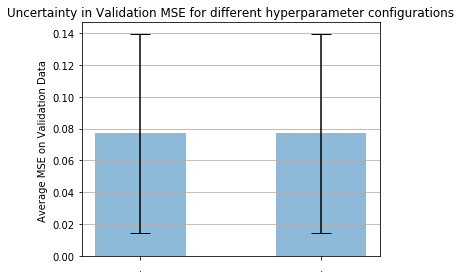

In [13]:
mean_of_average_mse_on_validation_list = np.mean(average_mse_on_validation_list)

std_of_average_mse_on_validation_list = np.std(average_mse_on_validation_list)

# Define individual_agents_name_list, positions, bar heights and list_of_standard_deviations_of_costs_of_all_agents bar heights
individual_agents_name_list = ['.',".",]
x_pos = np.arange(len(individual_agents_name_list))
list_of_mean_of_average_mse_on_validation_list = [mean_of_average_mse_on_validation_list,mean_of_average_mse_on_validation_list]
list_of_std_of_average_mse_on_validation_list = [std_of_average_mse_on_validation_list,std_of_average_mse_on_validation_list]

import matplotlib.pyplot as plt1

# Build the plot
fig, ax = plt1.subplots()
ax.bar(x_pos, list_of_mean_of_average_mse_on_validation_list,
       yerr=list_of_std_of_average_mse_on_validation_list,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10,
       width = 0.5, # defines the width of each bar, can pass a list of distince bar widths as well
        )
ax.set_ylabel('Average MSE on Validation Data ')
ax.set_xticks(x_pos)
ax.set_xticklabels(individual_agents_name_list)
ax.set_title('Uncertainty in Validation MSE for different hyperparameter configurations')
ax.yaxis.grid(True)

# Save the figure and show
plt1.tight_layout()
plt1.savefig('../plots/bar_plot_with_error_bars_for_average_validation_mse.png')
#plt1.show()

### Find the best hyperparameter configuration among all the trained estimators

In [14]:
estimator_index_for_least_avg_mse = average_mse_on_validation_list.index(min(average_mse_on_validation_list))
print("The best hyperparameter configuration index: {}".format(estimator_index_for_least_avg_mse))

The best hyperparameter configuration index: 349


## Train all 350 models on all the training samples (No cross-validation now.)


Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, False, 14, 225, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



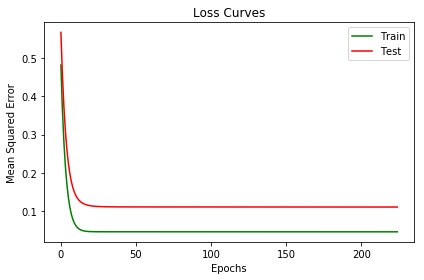


Traing with hyperparam config: 

[5e-05, 1e-05, 0.5, 0.0, False, 21, 325, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



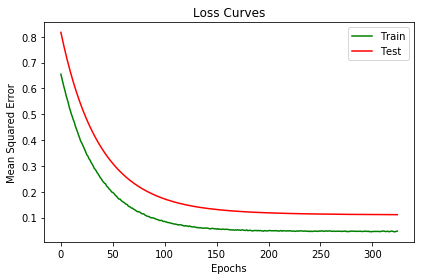


Traing with hyperparam config: 

[5e-05, 5e-05, 0.99, 0.0, False, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



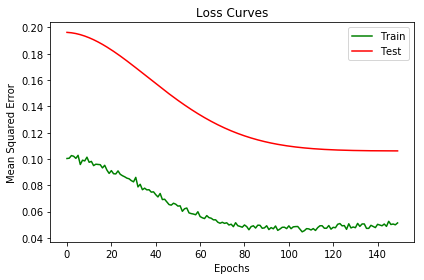


Traing with hyperparam config: 

[0.0001, 0.1, 0.75, 0.0, False, 21, 250, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



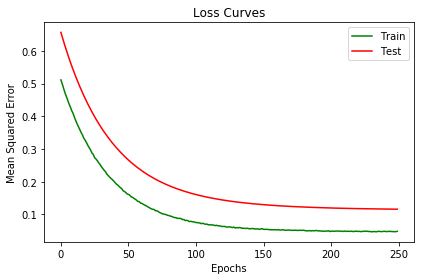


Traing with hyperparam config: 

[0.0003, 0.05, 0.5, 0.0, False, 24, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



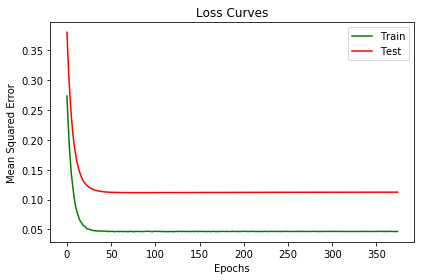


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 28, 225, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



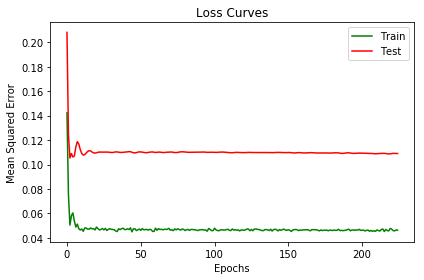


Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, True, 24, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



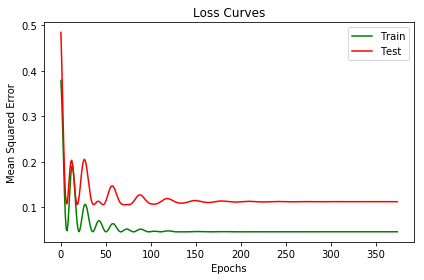


Traing with hyperparam config: 

[0.005, 0.05, 0.75, 0.0, False, 28, 200, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



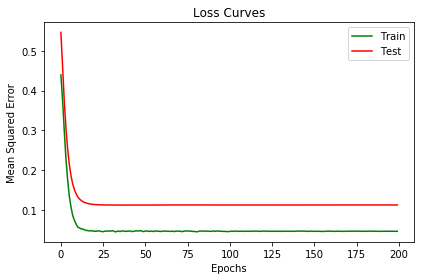


Traing with hyperparam config: 

[5e-05, 0.1, 0.5, 0.0, True, 28, 400, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



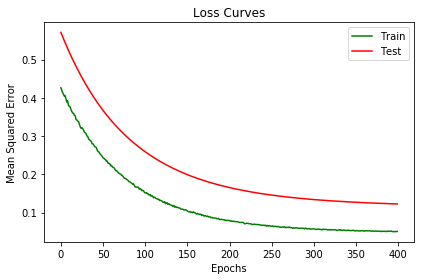


Traing with hyperparam config: 

[0.0003, 0.01, 0.75, 0.0, False, 24, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



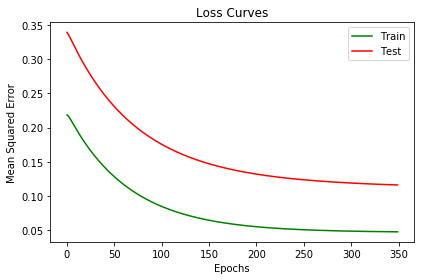


Traing with hyperparam config: 

[0.003, 5e-05, 0.5, 0.0, False, 21, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



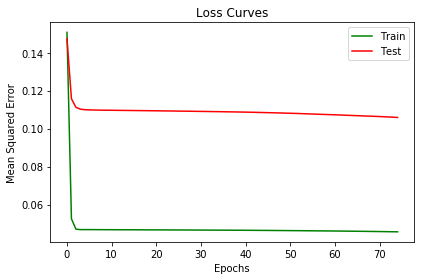


Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, True, 21, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



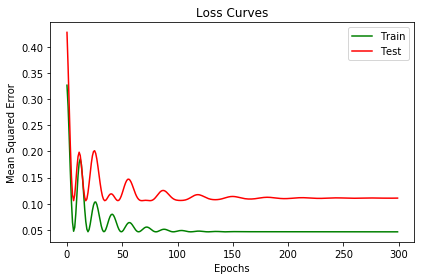


Traing with hyperparam config: 

[0.003, 5e-05, 0.99, 0.0, False, 17, 300, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



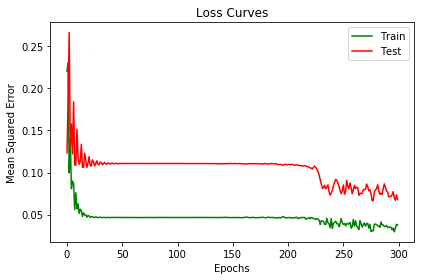


Traing with hyperparam config: 

[0.0005, 0.05, 0.5, 0.0, False, 35, 100, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



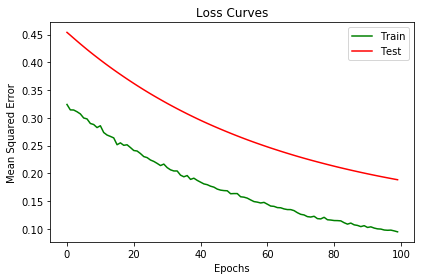


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 24, 100, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



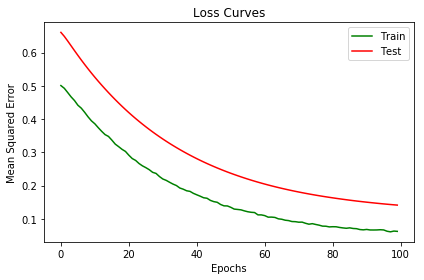


Traing with hyperparam config: 

[0.003, 0.001, 0.75, 0.0, True, 17, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



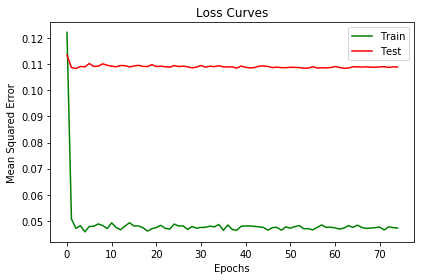


Traing with hyperparam config: 

[5e-05, 0.05, 0.5, 0.0, False, 28, 300, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



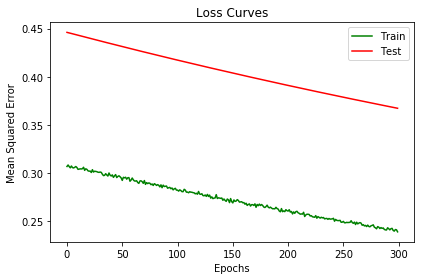


Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, False, 21, 400, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



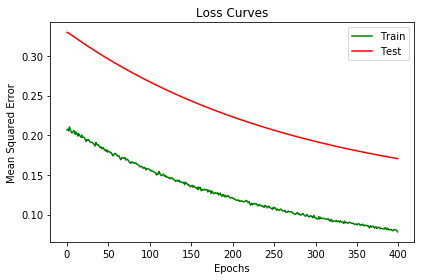


Traing with hyperparam config: 

[0.0005, 0.1, 0.75, 0.0, True, 28, 325, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



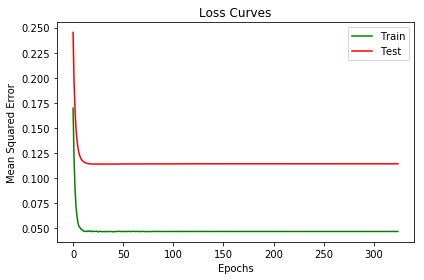


Traing with hyperparam config: 

[0.0005, 0.001, 0.75, 0.0, True, 28, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



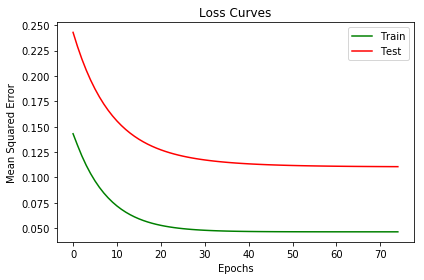


Traing with hyperparam config: 

[0.005, 0.001, 0.5, 0.0, True, 35, 175, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



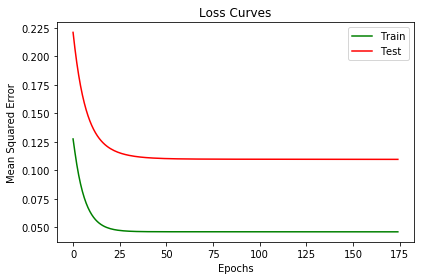


Traing with hyperparam config: 

[0.003, 0.001, 0.99, 0.0, False, 35, 350, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



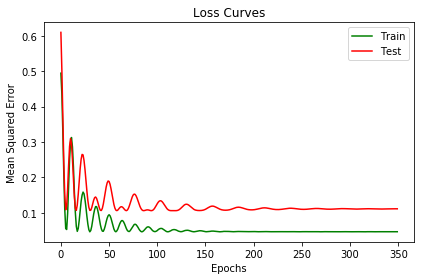


Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, True, 28, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



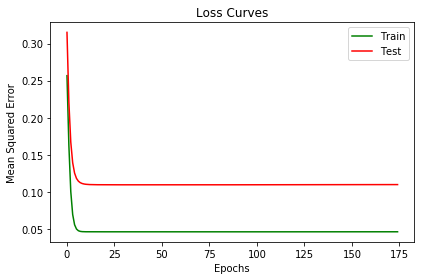


Traing with hyperparam config: 

[0.0001, 0.0001, 0.99, 0.0, False, 21, 350, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



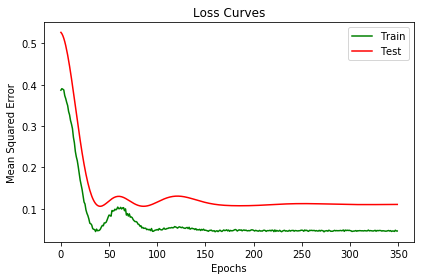


Traing with hyperparam config: 

[0.001, 5e-05, 0.75, 0.0, False, 35, 200, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



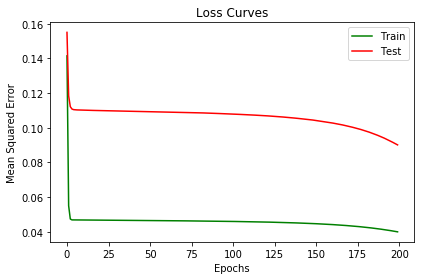


Traing with hyperparam config: 

[0.003, 1e-05, 0.75, 0.0, False, 21, 300, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



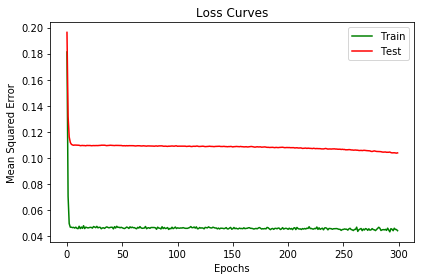


Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, False, 35, 200, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



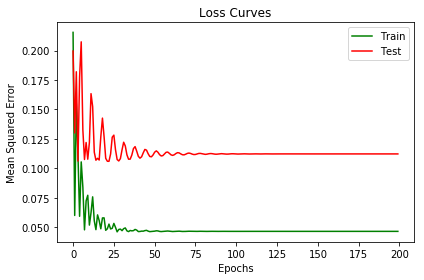


Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, False, 21, 75, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



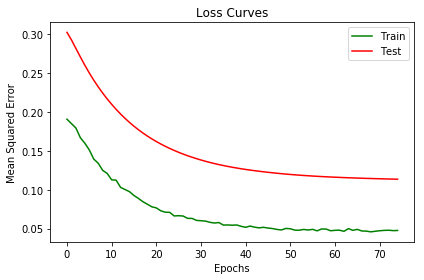


Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 17, 375, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



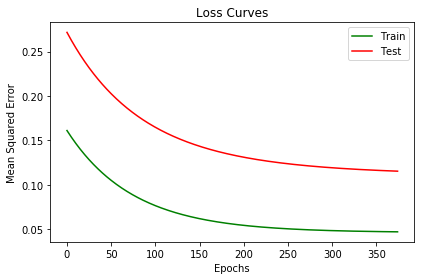


Traing with hyperparam config: 

[0.0005, 0.0001, 0.75, 0.0, False, 35, 250, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



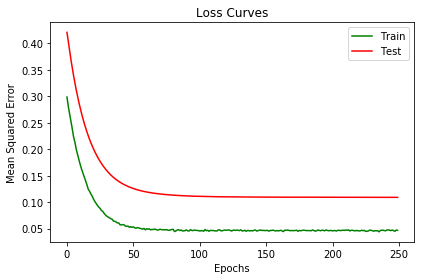


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 24, 400, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



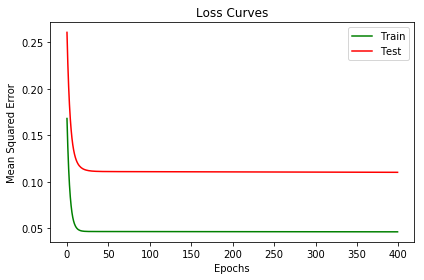


Traing with hyperparam config: 

[0.0001, 0.01, 0.99, 0.0, False, 14, 225, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



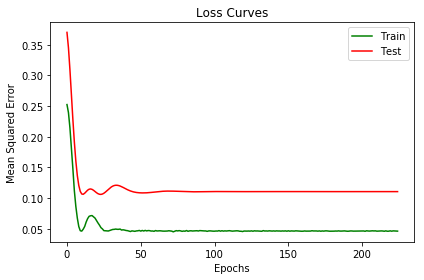


Traing with hyperparam config: 

[0.0001, 0.1, 0.5, 0.0, True, 35, 200, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



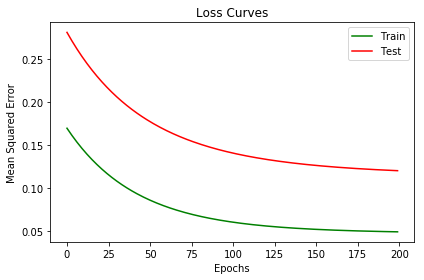


Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, True, 21, 175, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



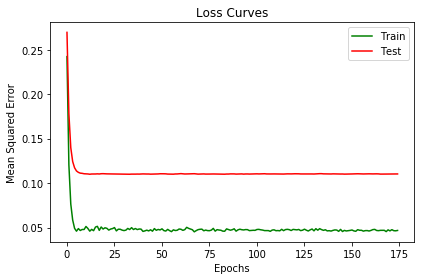


Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, True, 24, 375, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



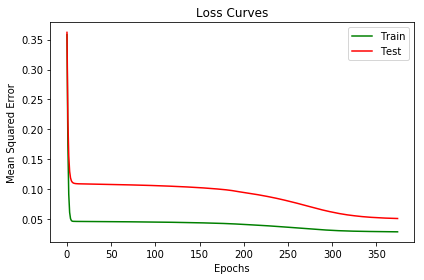


Traing with hyperparam config: 

[0.001, 5e-05, 0.75, 0.0, False, 17, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



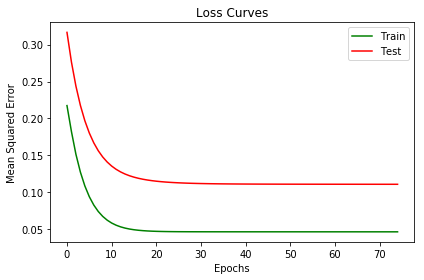


Traing with hyperparam config: 

[0.005, 0.005, 0.75, 0.0, False, 17, 325, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



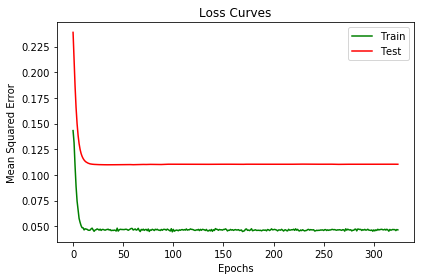


Traing with hyperparam config: 

[5e-05, 0.1, 0.5, 0.0, True, 24, 175, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



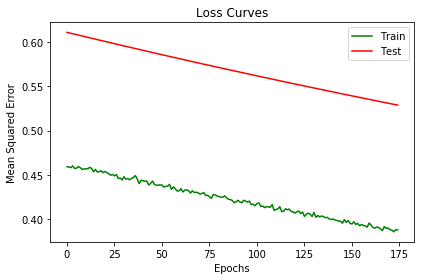


Traing with hyperparam config: 

[0.0001, 1e-05, 0.99, 0.0, True, 14, 75, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



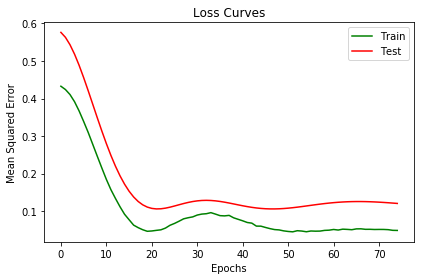


Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, False, 24, 75, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



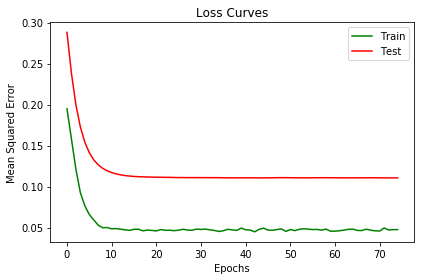


Traing with hyperparam config: 

[0.0003, 0.0001, 0.5, 0.0, True, 14, 400, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



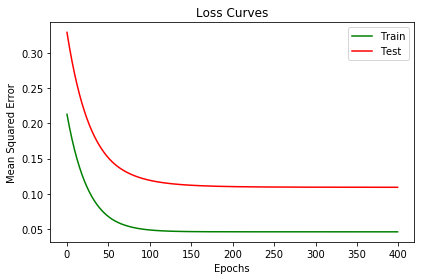


Traing with hyperparam config: 

[0.001, 1e-05, 0.5, 0.0, False, 28, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



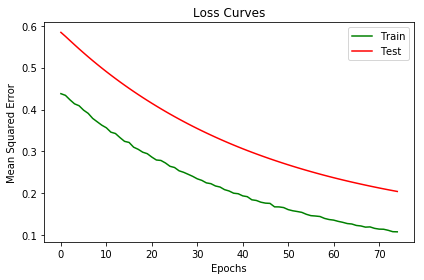


Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, True, 21, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



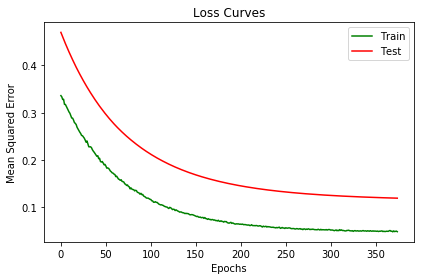


Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, False, 28, 175, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



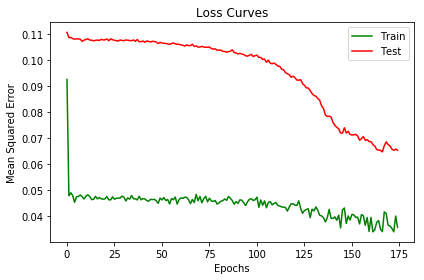


Traing with hyperparam config: 

[0.005, 0.001, 0.5, 0.0, True, 17, 300, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



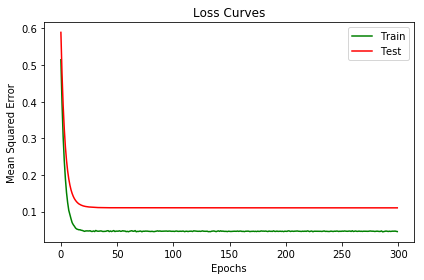


Traing with hyperparam config: 

[0.003, 0.1, 0.5, 0.0, True, 28, 275, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



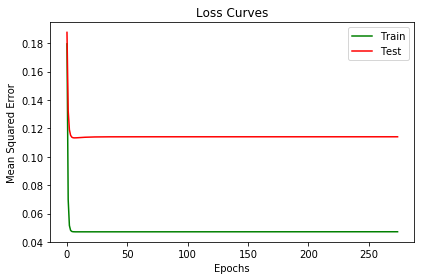


Traing with hyperparam config: 

[0.003, 0.1, 0.99, 0.0, False, 17, 400, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



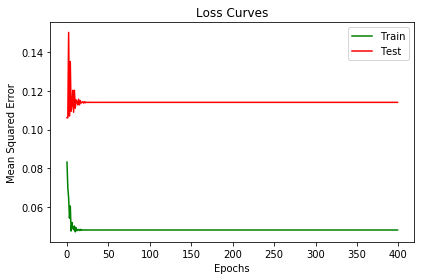


Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, True, 14, 225, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



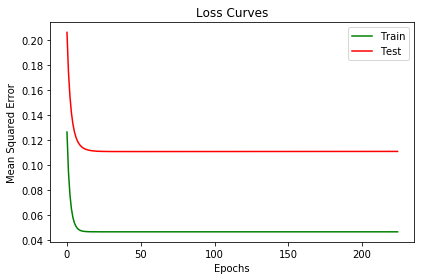


Traing with hyperparam config: 

[0.0005, 0.05, 0.5, 0.0, False, 14, 175, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



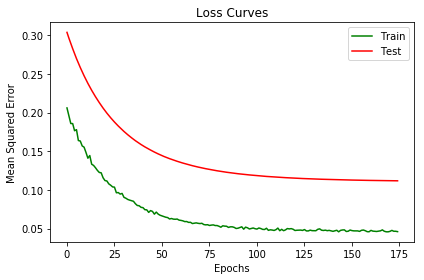


Traing with hyperparam config: 

[0.003, 0.1, 0.99, 0.0, True, 24, 175, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



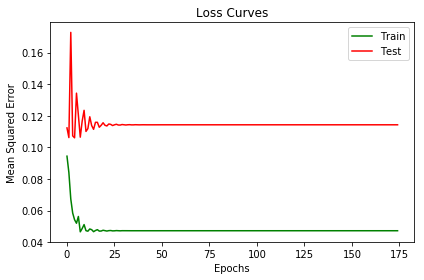


Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, False, 21, 75, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



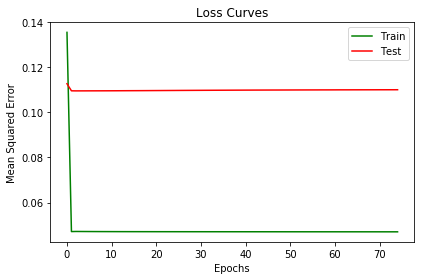


Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 21, 75, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



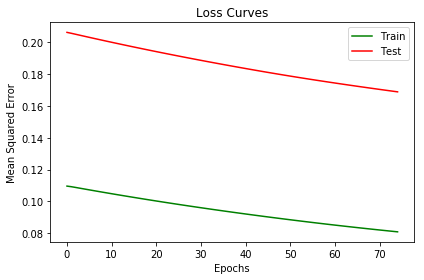


Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, True, 21, 375, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



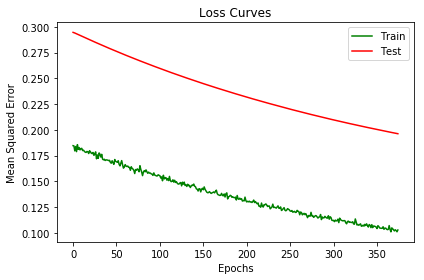


Traing with hyperparam config: 

[0.003, 0.001, 0.99, 0.0, True, 35, 375, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



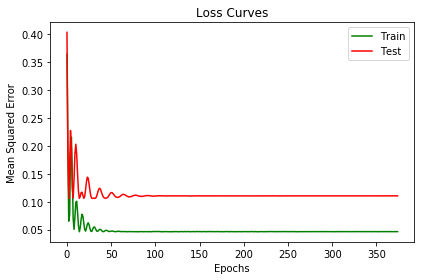


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 35, 100, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



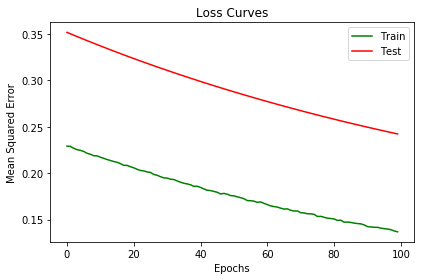


Traing with hyperparam config: 

[0.001, 0.01, 0.5, 0.0, False, 21, 250, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



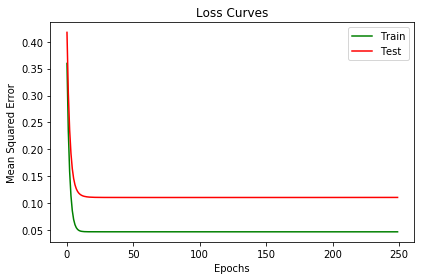


Traing with hyperparam config: 

[5e-05, 1e-05, 0.99, 0.0, False, 28, 400, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



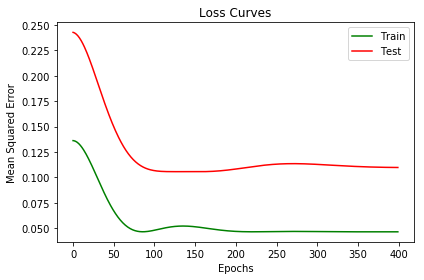


Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, True, 28, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



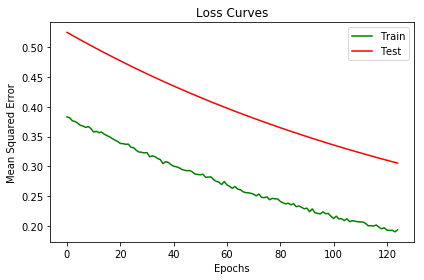


Traing with hyperparam config: 

[0.001, 0.0001, 0.75, 0.0, False, 28, 100, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



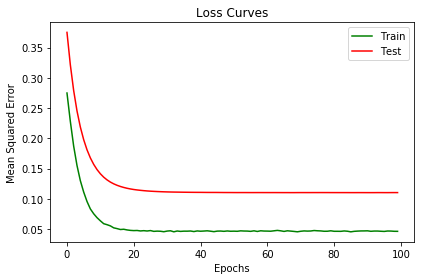


Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, True, 35, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



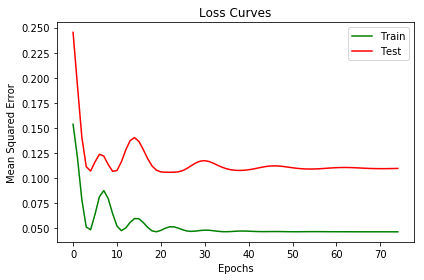


Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 21, 400, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



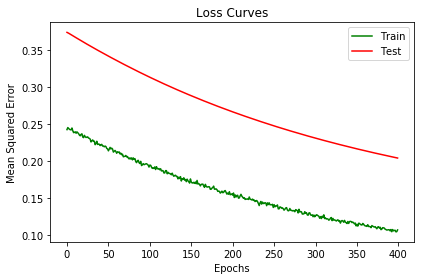


Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 35, 200, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



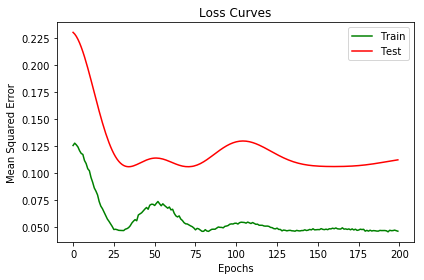


Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, True, 17, 350, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



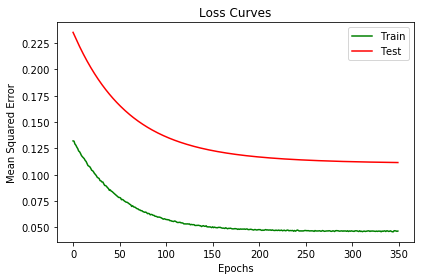


Traing with hyperparam config: 

[0.003, 0.05, 0.75, 0.0, False, 24, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



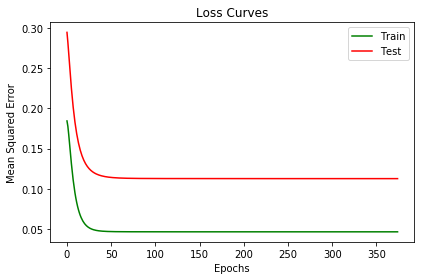


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 21, 375, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



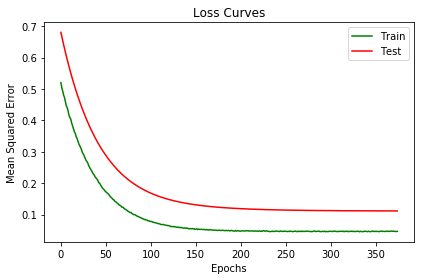


Traing with hyperparam config: 

[5e-05, 1e-05, 0.99, 0.0, False, 14, 50, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



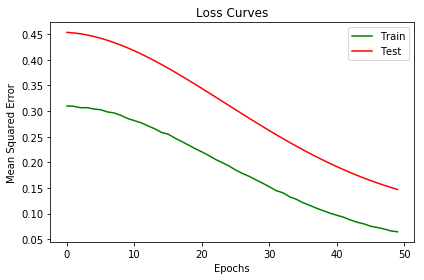


Traing with hyperparam config: 

[0.0001, 0.01, 0.5, 0.0, True, 21, 250, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



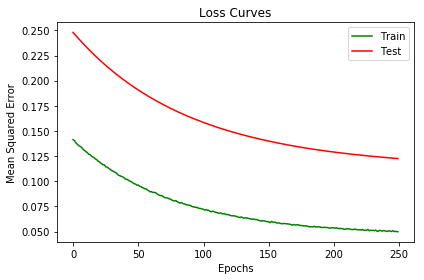


Traing with hyperparam config: 

[0.0003, 1e-05, 0.99, 0.0, True, 28, 400, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



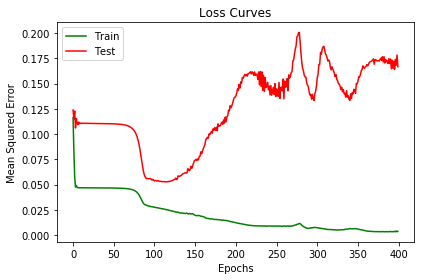


Traing with hyperparam config: 

[0.003, 0.01, 0.5, 0.0, False, 35, 50, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



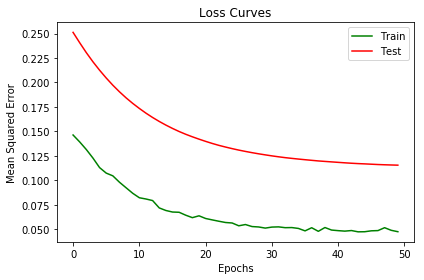


Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, True, 24, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



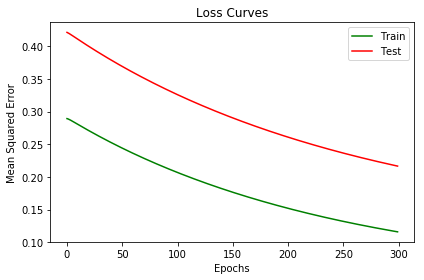


Traing with hyperparam config: 

[0.0001, 0.05, 0.75, 0.0, False, 17, 150, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



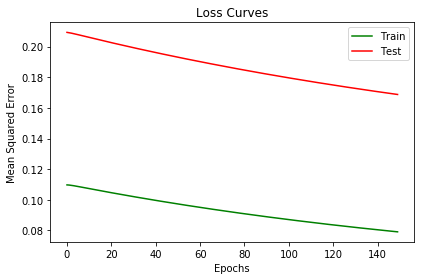


Traing with hyperparam config: 

[0.003, 0.05, 0.5, 0.0, False, 17, 200, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



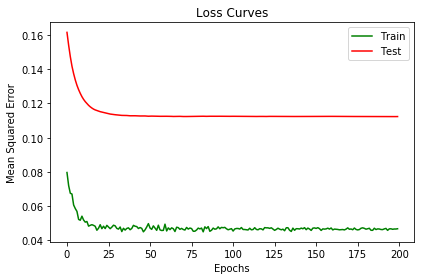


Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, False, 24, 50, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



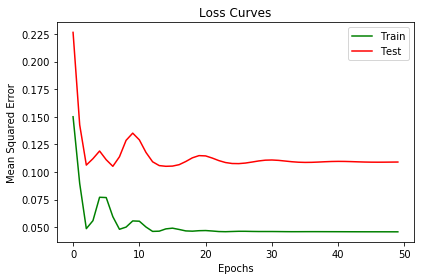


Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, True, 21, 150, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



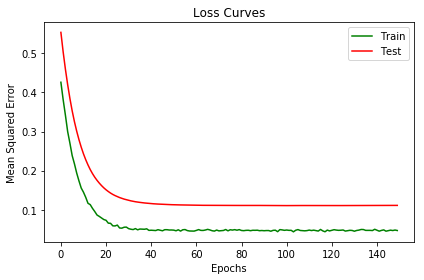


Traing with hyperparam config: 

[0.0005, 0.005, 0.5, 0.0, False, 35, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



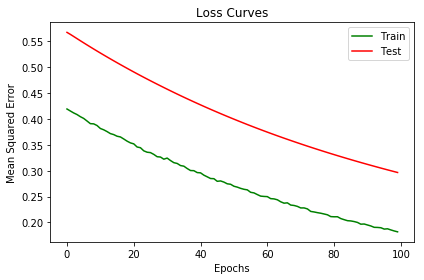


Traing with hyperparam config: 

[0.0001, 0.01, 0.75, 0.0, False, 28, 350, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



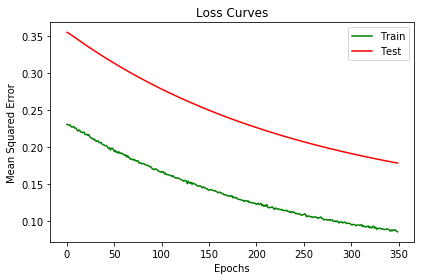


Traing with hyperparam config: 

[0.0005, 0.01, 0.99, 0.0, True, 21, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



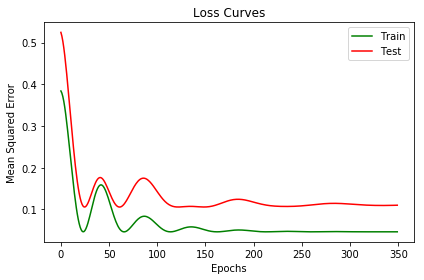


Traing with hyperparam config: 

[0.003, 0.005, 0.75, 0.0, False, 14, 225, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



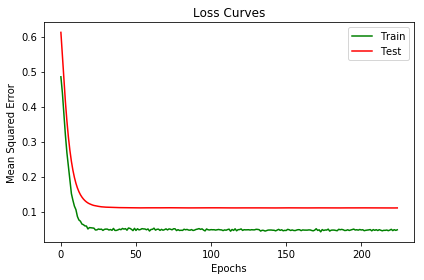


Traing with hyperparam config: 

[0.003, 0.0001, 0.75, 0.0, True, 17, 375, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



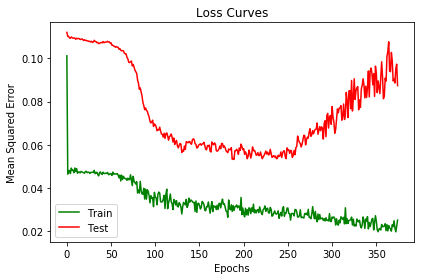


Traing with hyperparam config: 

[0.003, 0.001, 0.99, 0.0, True, 35, 75, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



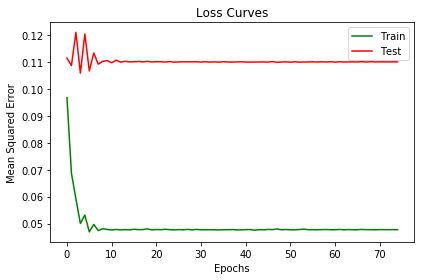


Traing with hyperparam config: 

[0.0005, 0.1, 0.5, 0.0, False, 24, 225, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



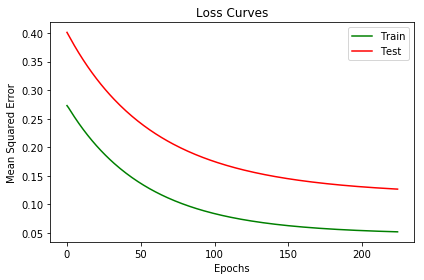


Traing with hyperparam config: 

[5e-05, 0.001, 0.5, 0.0, False, 14, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



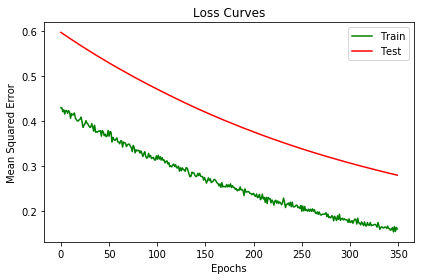


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 28, 50, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



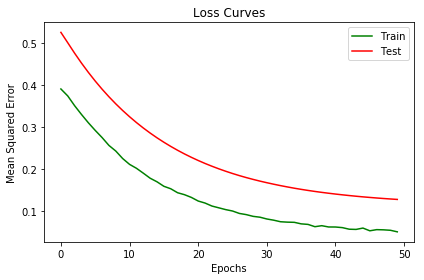


Traing with hyperparam config: 

[0.0003, 0.01, 0.99, 0.0, True, 17, 100, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



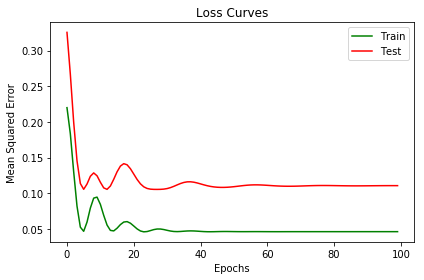


Traing with hyperparam config: 

[5e-05, 0.01, 0.99, 0.0, False, 28, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



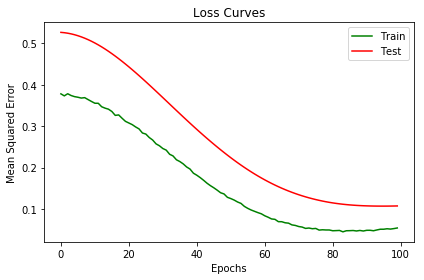


Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, True, 14, 150, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



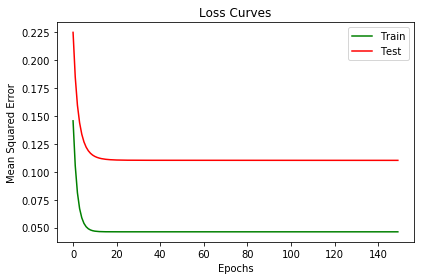


Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, False, 24, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



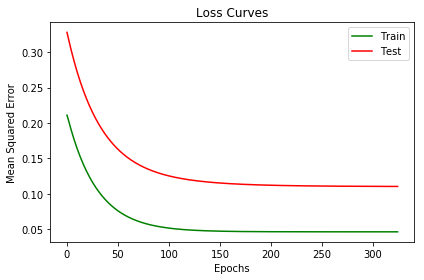


Traing with hyperparam config: 

[0.005, 0.1, 0.99, 0.0, True, 35, 250, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



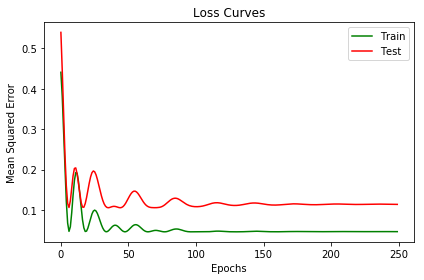


Traing with hyperparam config: 

[0.0005, 0.005, 0.99, 0.0, False, 21, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



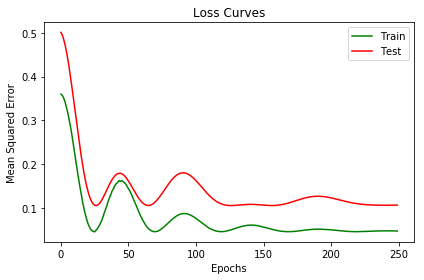


Traing with hyperparam config: 

[0.001, 0.001, 0.5, 0.0, False, 24, 325, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



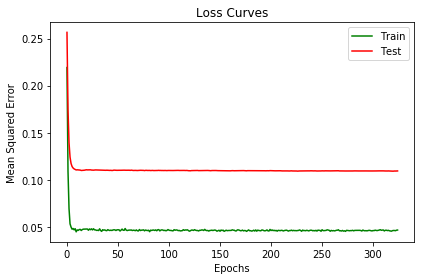


Traing with hyperparam config: 

[0.0001, 1e-05, 0.5, 0.0, True, 28, 350, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



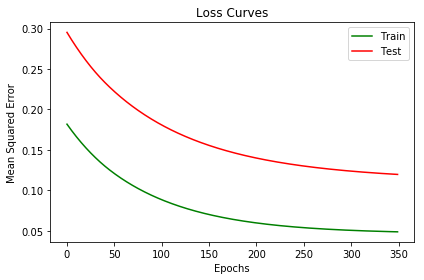


Traing with hyperparam config: 

[0.0003, 0.0001, 0.99, 0.0, True, 14, 375, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



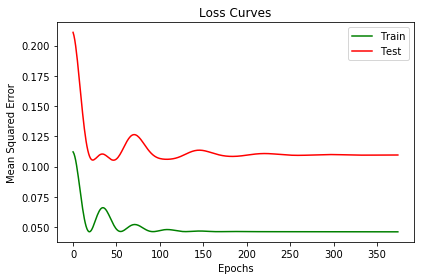


Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, False, 28, 100, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



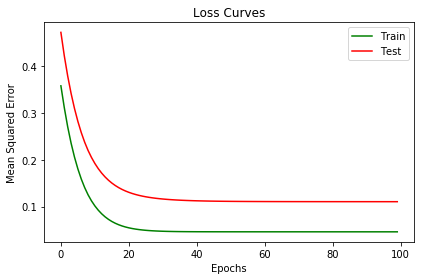


Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, True, 28, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



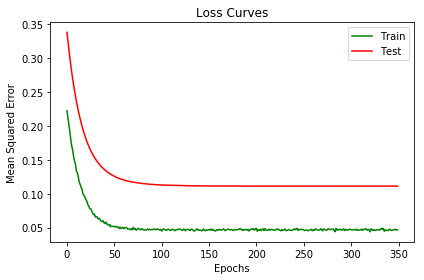


Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, True, 17, 175, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



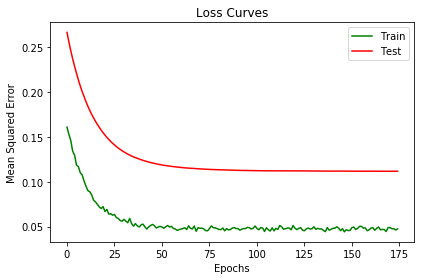


Traing with hyperparam config: 

[0.001, 0.0001, 0.99, 0.0, True, 28, 50, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



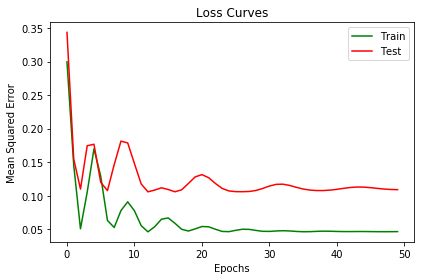


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 24, 375, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



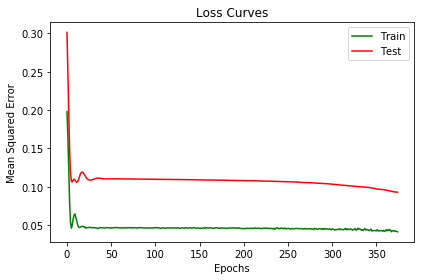


Traing with hyperparam config: 

[0.003, 0.0001, 0.99, 0.0, True, 14, 100, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



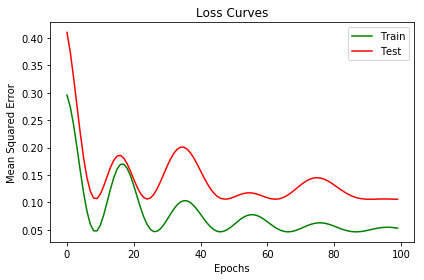


Traing with hyperparam config: 

[5e-05, 0.001, 0.99, 0.0, False, 28, 175, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



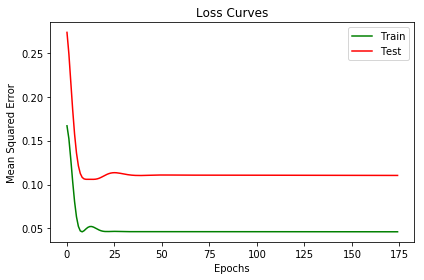


Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, False, 17, 400, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



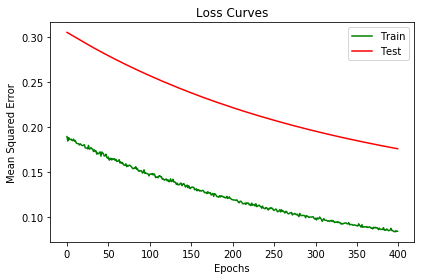


Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, False, 14, 350, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



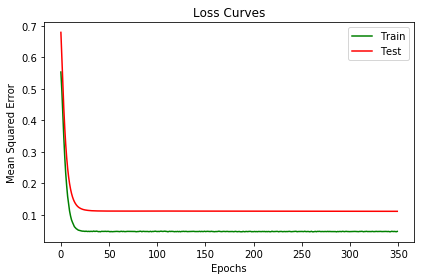


Traing with hyperparam config: 

[0.003, 0.001, 0.75, 0.0, False, 14, 300, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



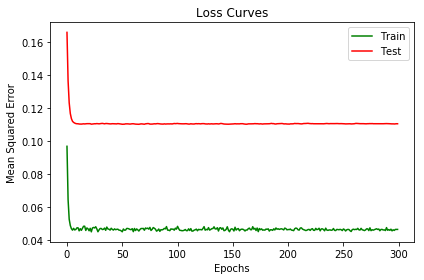


Traing with hyperparam config: 

[0.0005, 0.001, 0.75, 0.0, False, 21, 350, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



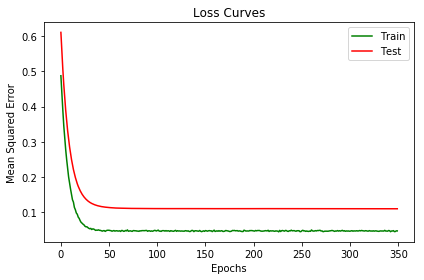


Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, True, 21, 275, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



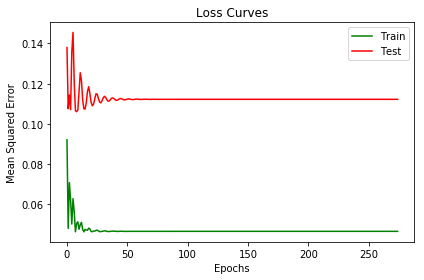


Traing with hyperparam config: 

[0.0001, 0.01, 0.75, 0.0, False, 28, 125, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



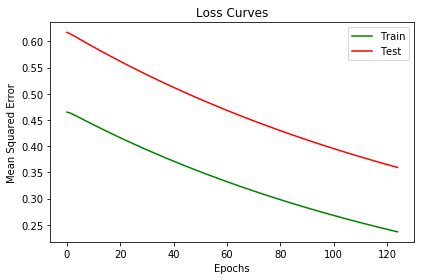


Traing with hyperparam config: 

[0.003, 1e-05, 0.75, 0.0, True, 35, 250, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



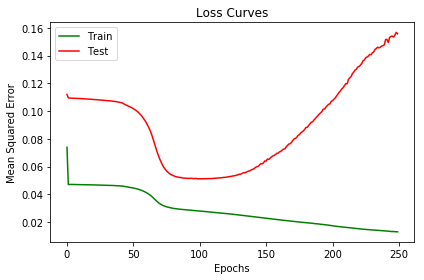


Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 35, 300, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



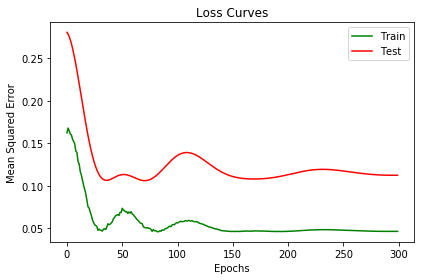


Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, True, 24, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



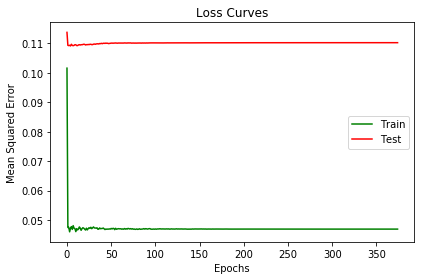


Traing with hyperparam config: 

[0.001, 5e-05, 0.99, 0.0, True, 28, 150, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



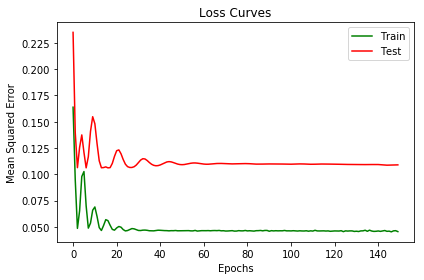


Traing with hyperparam config: 

[0.0001, 0.001, 0.99, 0.0, False, 14, 200, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



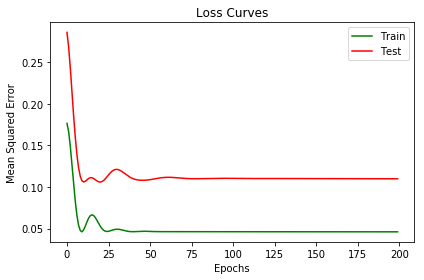


Traing with hyperparam config: 

[5e-05, 1e-05, 0.5, 0.0, True, 14, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



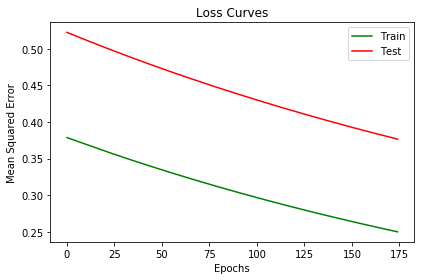


Traing with hyperparam config: 

[0.001, 0.01, 0.99, 0.0, False, 24, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



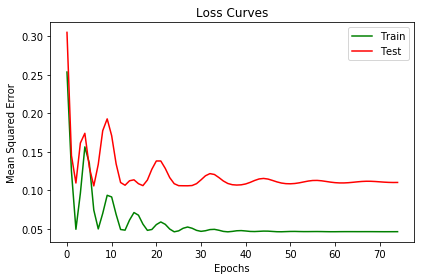


Traing with hyperparam config: 

[0.0003, 5e-05, 0.75, 0.0, False, 14, 75, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



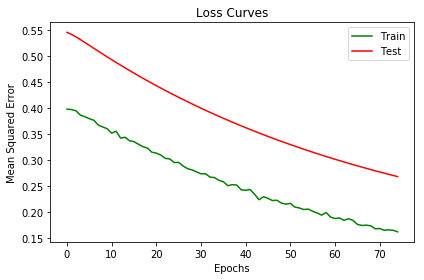


Traing with hyperparam config: 

[5e-05, 0.0001, 0.75, 0.0, False, 35, 300, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



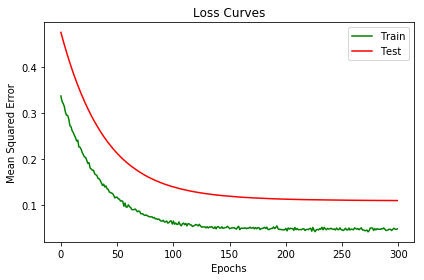


Traing with hyperparam config: 

[0.0003, 1e-05, 0.5, 0.0, False, 17, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



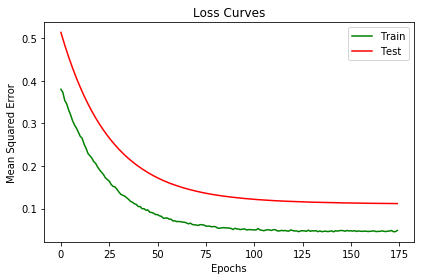


Traing with hyperparam config: 

[0.003, 0.005, 0.75, 0.0, True, 14, 150, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



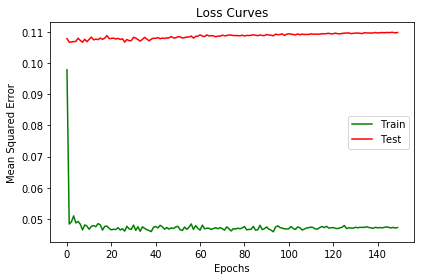


Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 35, 250, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



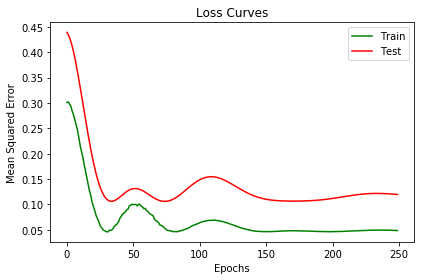


Traing with hyperparam config: 

[0.0005, 0.01, 0.99, 0.0, True, 14, 100, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



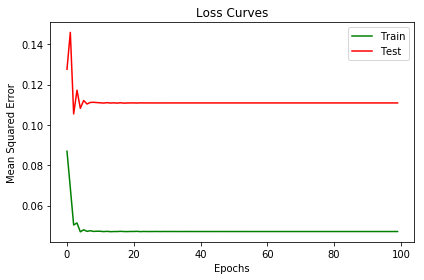


Traing with hyperparam config: 

[0.005, 0.001, 0.99, 0.0, False, 17, 325, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



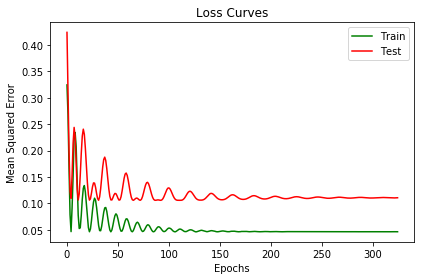


Traing with hyperparam config: 

[0.0005, 1e-05, 0.99, 0.0, False, 35, 350, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



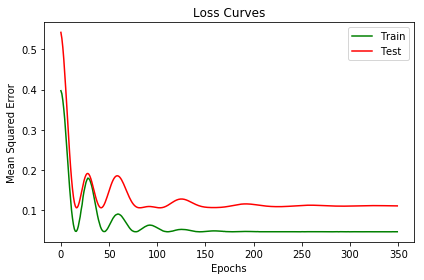


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 24, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



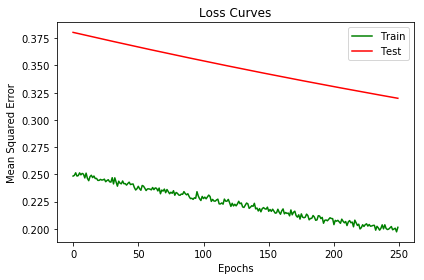


Traing with hyperparam config: 

[0.0001, 0.005, 0.99, 0.0, True, 17, 250, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



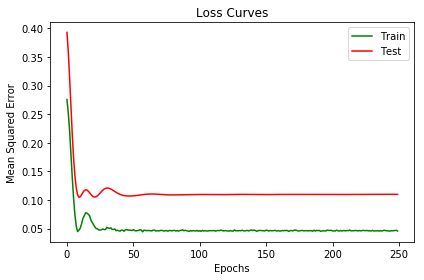


Traing with hyperparam config: 

[0.005, 0.0001, 0.5, 0.0, True, 14, 275, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



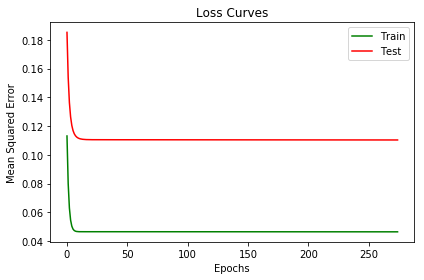


Traing with hyperparam config: 

[0.0003, 0.001, 0.5, 0.0, False, 35, 300, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



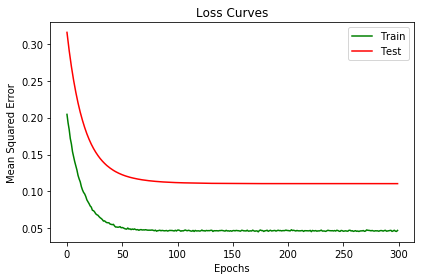


Traing with hyperparam config: 

[0.003, 0.01, 0.99, 0.0, False, 24, 50, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



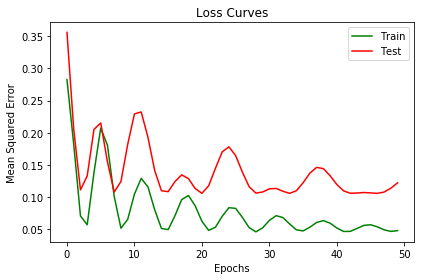


Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, True, 21, 375, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



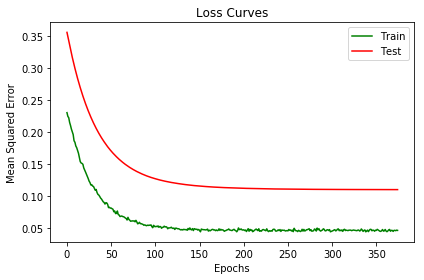


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, False, 24, 375, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



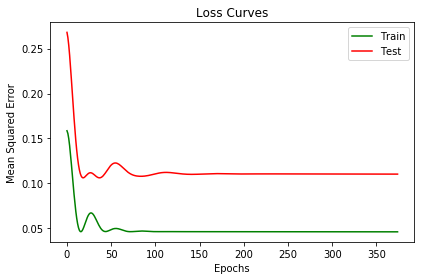


Traing with hyperparam config: 

[0.001, 0.0001, 0.5, 0.0, True, 14, 200, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



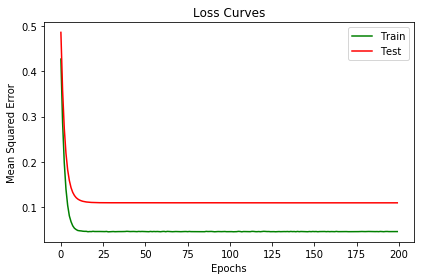


Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 35, 225, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



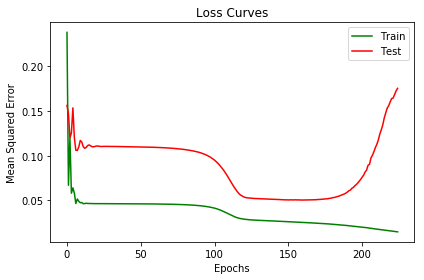


Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, True, 21, 275, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



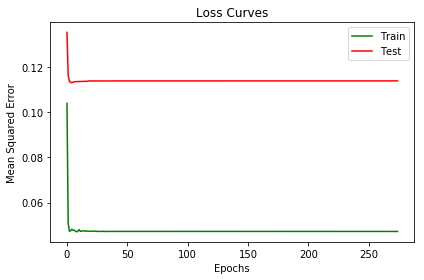


Traing with hyperparam config: 

[0.0001, 0.01, 0.5, 0.0, True, 24, 375, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



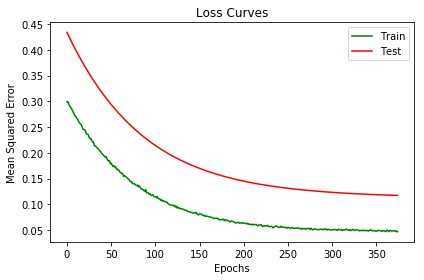


Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, True, 24, 175, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



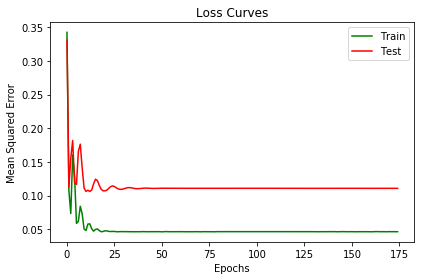


Traing with hyperparam config: 

[5e-05, 0.001, 0.75, 0.0, True, 28, 325, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



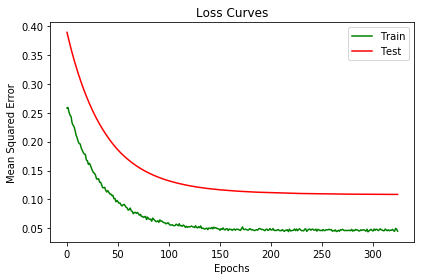


Traing with hyperparam config: 

[0.001, 0.0001, 0.5, 0.0, True, 17, 250, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



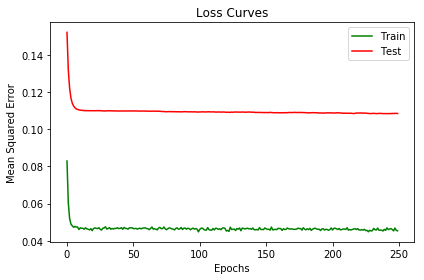


Traing with hyperparam config: 

[0.001, 0.005, 0.99, 0.0, False, 21, 375, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



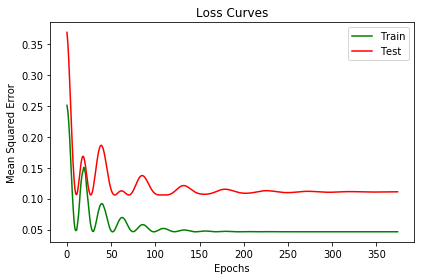


Traing with hyperparam config: 

[5e-05, 1e-05, 0.75, 0.0, True, 35, 200, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



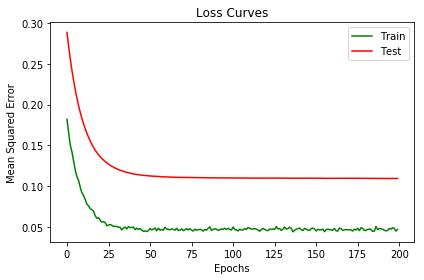


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 28, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



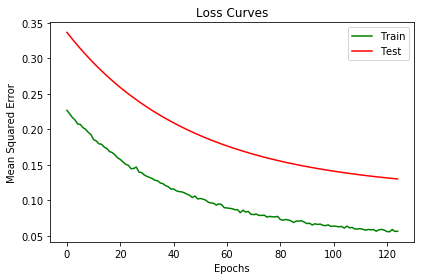


Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, False, 24, 50, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



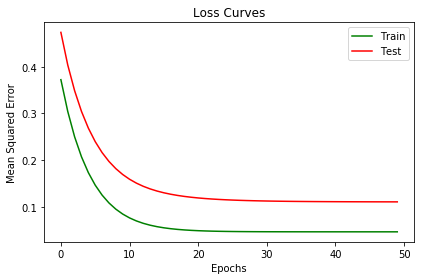


Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, True, 35, 200, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



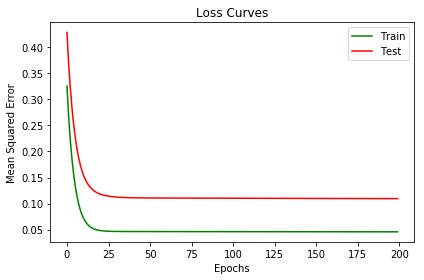


Traing with hyperparam config: 

[0.0003, 0.1, 0.5, 0.0, True, 24, 250, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



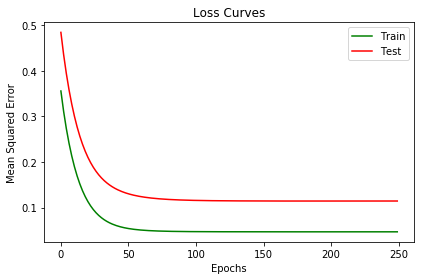


Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, True, 35, 75, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



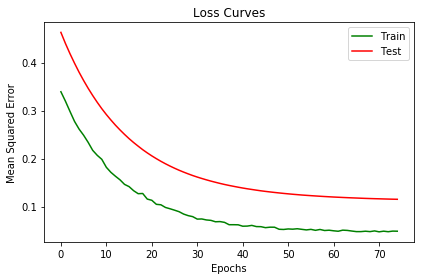


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, True, 28, 300, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



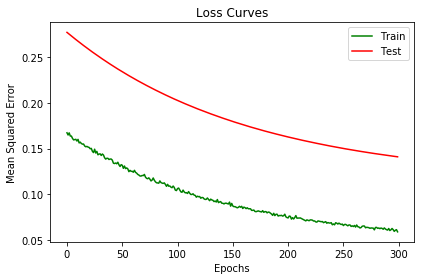


Traing with hyperparam config: 

[0.0005, 1e-05, 0.5, 0.0, True, 35, 325, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



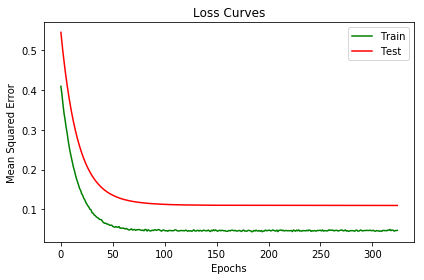


Traing with hyperparam config: 

[0.001, 0.0001, 0.99, 0.0, False, 28, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



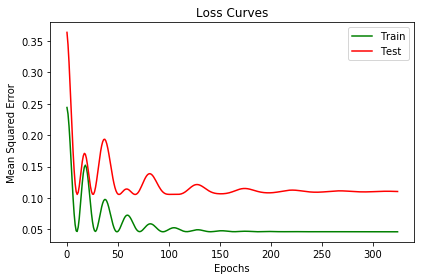


Traing with hyperparam config: 

[0.003, 5e-05, 0.99, 0.0, False, 35, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



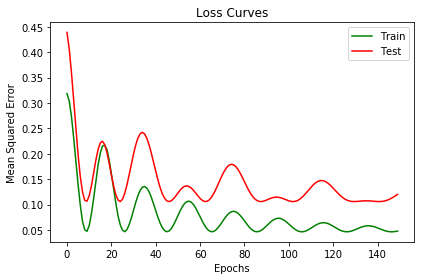


Traing with hyperparam config: 

[0.0003, 0.005, 0.99, 0.0, False, 21, 275, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



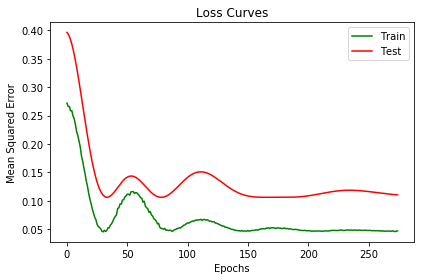


Traing with hyperparam config: 

[0.0001, 0.001, 0.5, 0.0, True, 21, 350, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



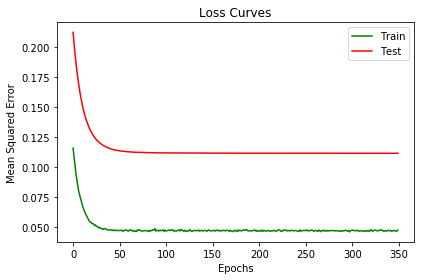


Traing with hyperparam config: 

[0.0003, 0.05, 0.75, 0.0, False, 14, 100, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



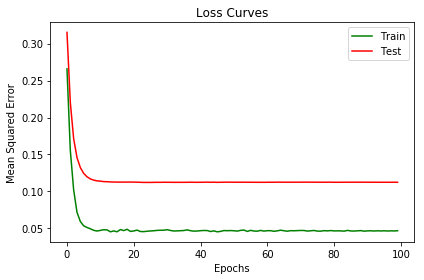


Traing with hyperparam config: 

[0.0003, 0.01, 0.99, 0.0, False, 21, 150, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



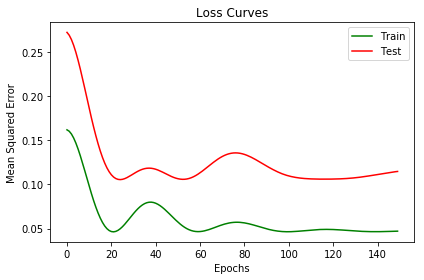


Traing with hyperparam config: 

[0.0001, 1e-05, 0.5, 0.0, True, 14, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



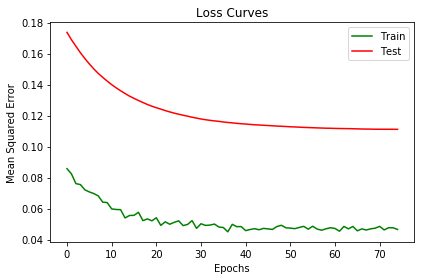


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, False, 28, 300, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



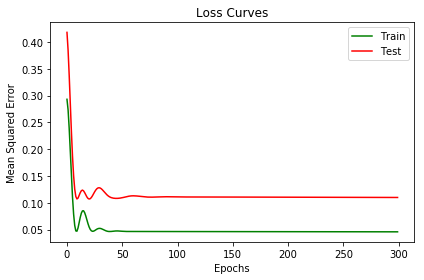


Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, False, 14, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



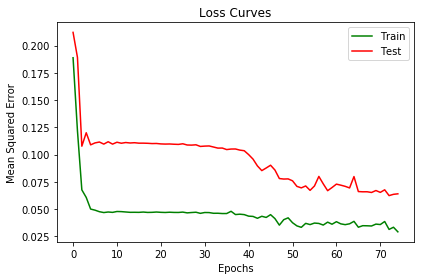


Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, True, 35, 250, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



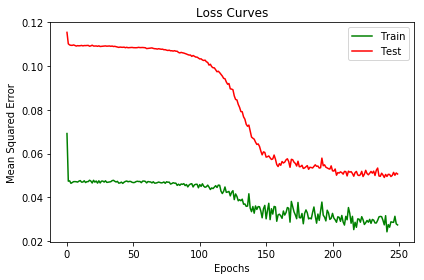


Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, False, 17, 350, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



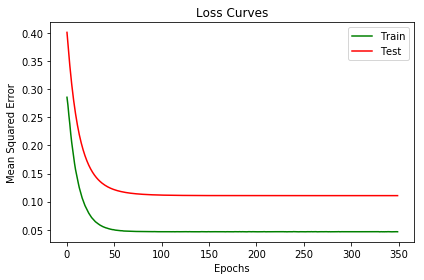


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 14, 250, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



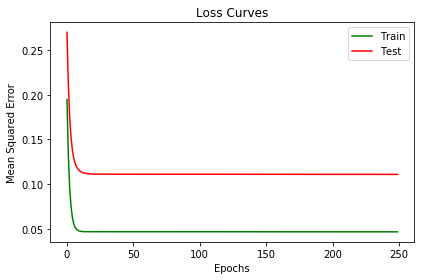


Traing with hyperparam config: 

[0.005, 0.001, 0.99, 0.0, False, 21, 100, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



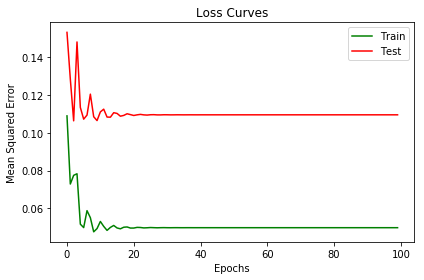


Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 35, 50, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



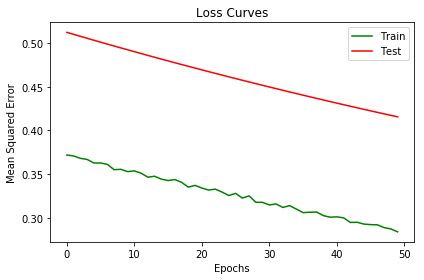


Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, True, 35, 325, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



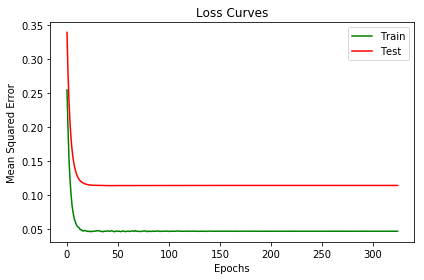


Traing with hyperparam config: 

[0.003, 0.01, 0.5, 0.0, True, 24, 175, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



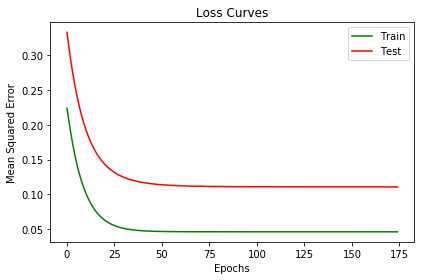


Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 14, 100, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



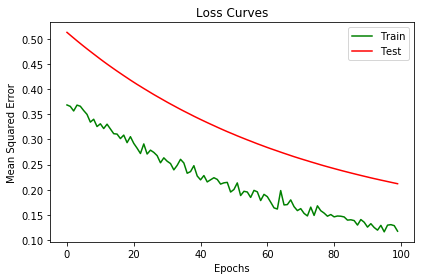


Traing with hyperparam config: 

[0.003, 1e-05, 0.5, 0.0, False, 28, 150, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



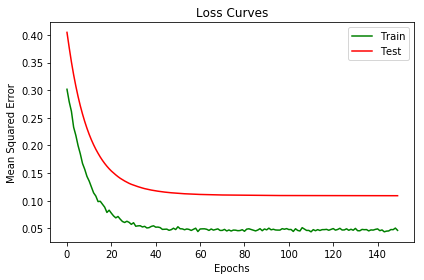


Traing with hyperparam config: 

[0.0001, 5e-05, 0.75, 0.0, True, 21, 200, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



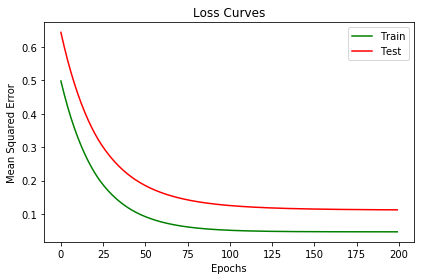


Traing with hyperparam config: 

[0.005, 0.05, 0.5, 0.0, True, 28, 300, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



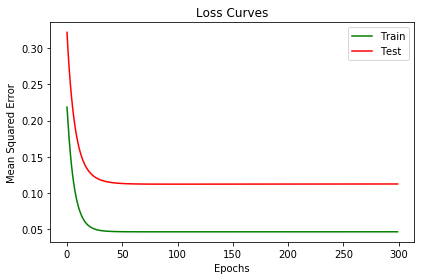


Traing with hyperparam config: 

[0.0001, 0.005, 0.5, 0.0, True, 17, 175, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



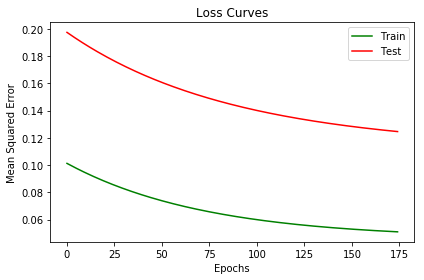


Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, True, 21, 50, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



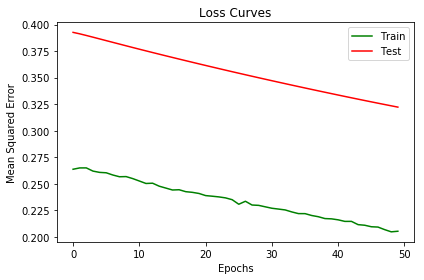


Traing with hyperparam config: 

[0.0005, 0.1, 0.5, 0.0, False, 28, 350, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



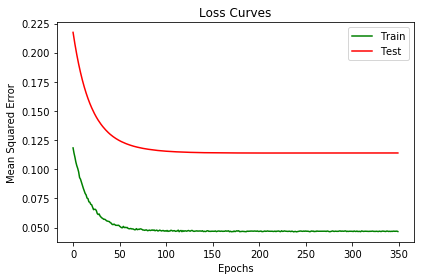


Traing with hyperparam config: 

[0.0005, 1e-05, 0.99, 0.0, True, 14, 225, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



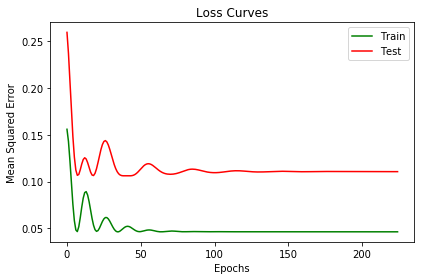


Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, True, 35, 150, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



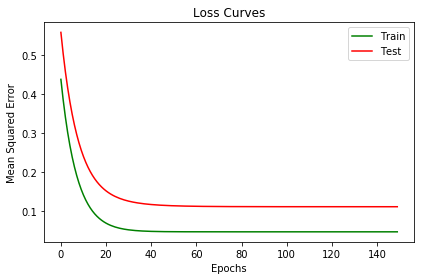


Traing with hyperparam config: 

[0.005, 1e-05, 0.5, 0.0, True, 21, 150, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



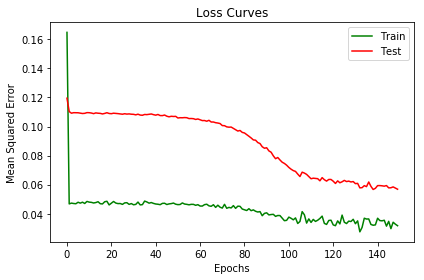


Traing with hyperparam config: 

[0.001, 0.001, 0.5, 0.0, True, 35, 175, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



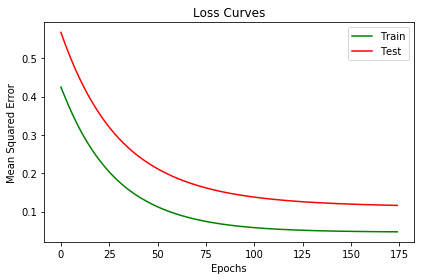


Traing with hyperparam config: 

[0.003, 1e-05, 0.5, 0.0, False, 35, 300, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



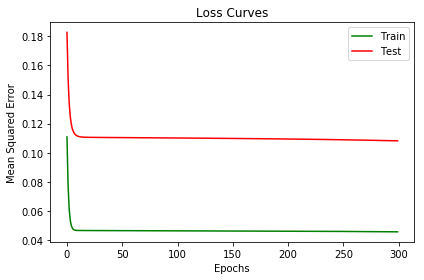


Traing with hyperparam config: 

[0.0003, 0.005, 0.99, 0.0, True, 14, 300, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



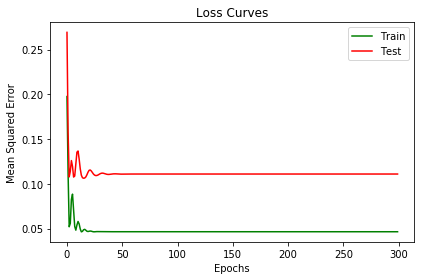


Traing with hyperparam config: 

[0.0001, 0.01, 0.99, 0.0, False, 21, 300, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



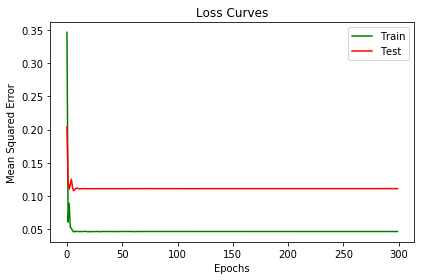


Traing with hyperparam config: 

[0.001, 0.005, 0.5, 0.0, True, 28, 175, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



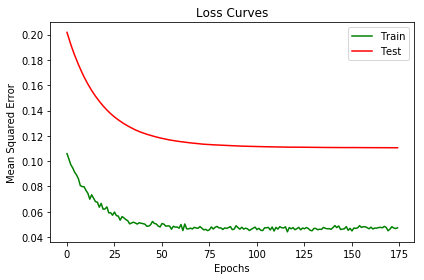


Traing with hyperparam config: 

[0.0003, 0.1, 0.75, 0.0, True, 35, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



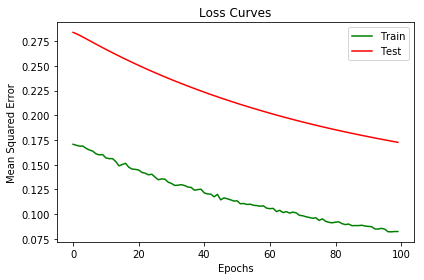


Traing with hyperparam config: 

[0.005, 0.005, 0.99, 0.0, False, 14, 250, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



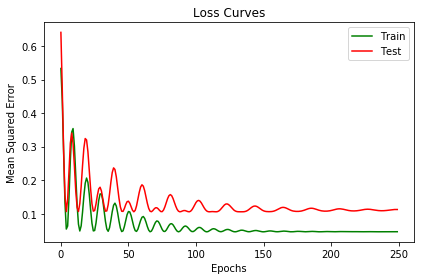


Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 17, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



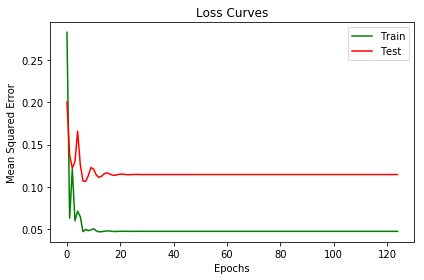


Traing with hyperparam config: 

[0.0003, 5e-05, 0.5, 0.0, False, 14, 175, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



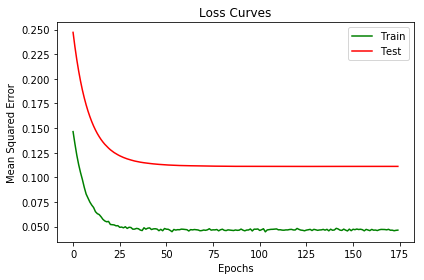


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 35, 350, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



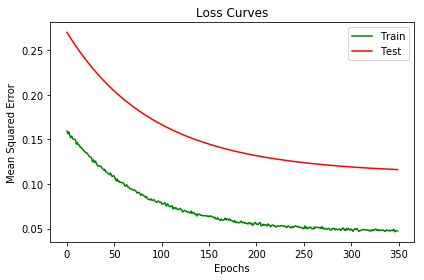


Traing with hyperparam config: 

[5e-05, 0.005, 0.99, 0.0, False, 28, 200, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



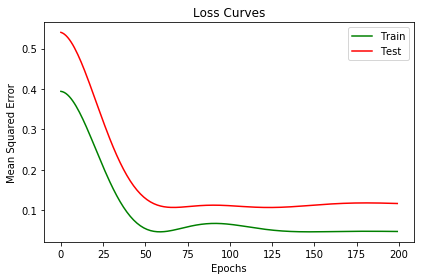


Traing with hyperparam config: 

[0.0001, 0.1, 0.75, 0.0, False, 14, 400, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



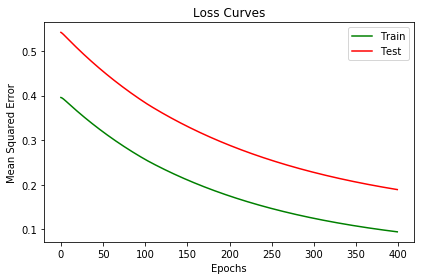


Traing with hyperparam config: 

[0.0001, 1e-05, 0.99, 0.0, False, 24, 200, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



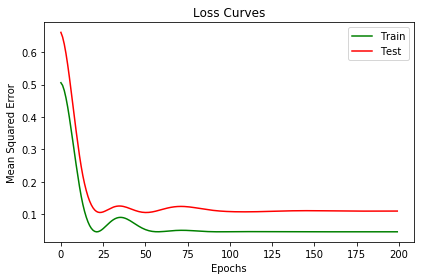


Traing with hyperparam config: 

[0.0005, 0.005, 0.75, 0.0, False, 21, 375, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



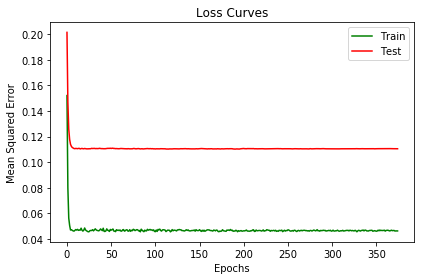


Traing with hyperparam config: 

[5e-05, 1e-05, 0.99, 0.0, True, 21, 75, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



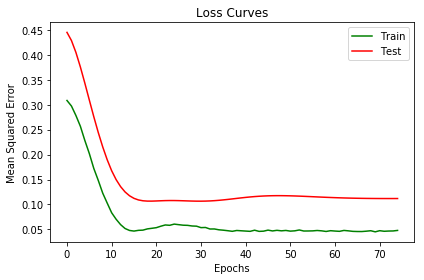


Traing with hyperparam config: 

[0.0005, 1e-05, 0.99, 0.0, False, 24, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



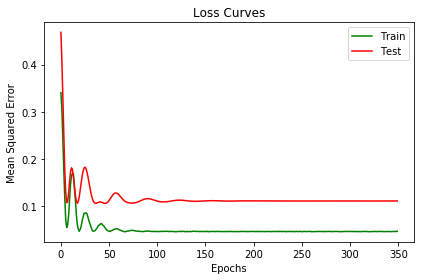


Traing with hyperparam config: 

[0.0005, 0.01, 0.5, 0.0, False, 17, 250, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



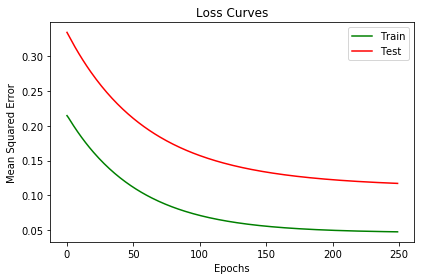


Traing with hyperparam config: 

[0.0001, 0.05, 0.99, 0.0, True, 24, 50, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



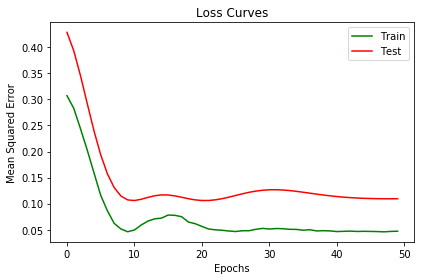


Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 21, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



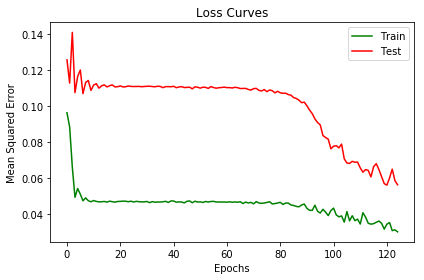


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 28, 225, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



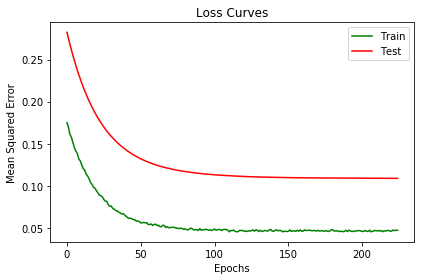


Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, False, 28, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



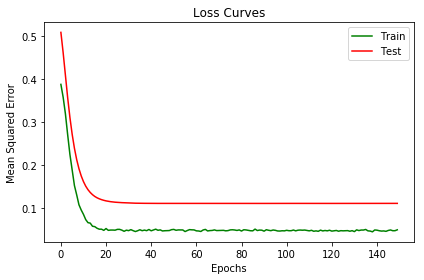


Traing with hyperparam config: 

[0.005, 5e-05, 0.75, 0.0, True, 17, 75, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



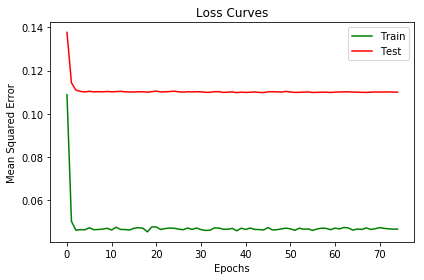


Traing with hyperparam config: 

[0.001, 0.1, 0.99, 0.0, False, 24, 325, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



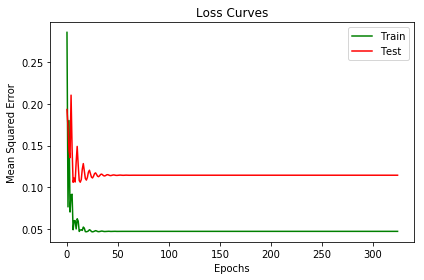


Traing with hyperparam config: 

[5e-05, 1e-05, 0.5, 0.0, True, 24, 50, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



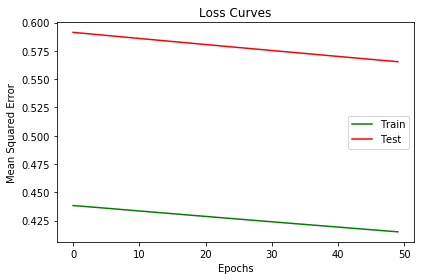


Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, True, 14, 125, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



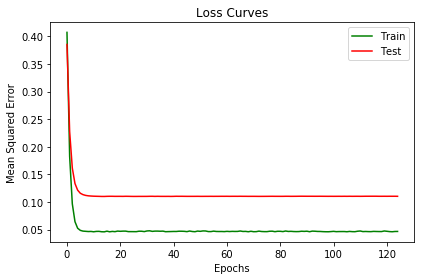


Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, False, 14, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



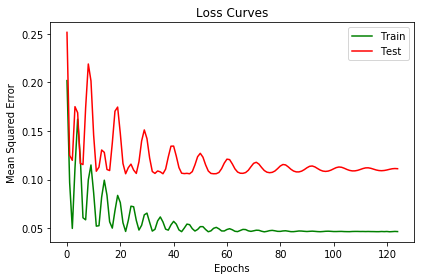


Traing with hyperparam config: 

[0.005, 0.001, 0.99, 0.0, False, 35, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



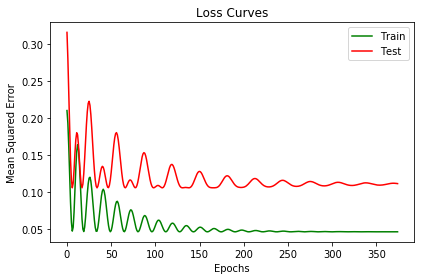


Traing with hyperparam config: 

[0.001, 1e-05, 0.75, 0.0, False, 17, 300, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



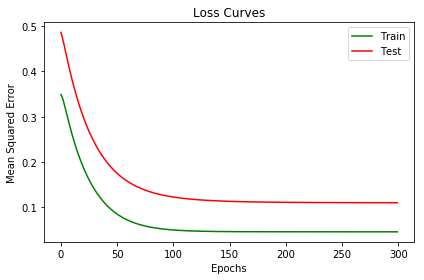


Traing with hyperparam config: 

[0.003, 1e-05, 0.99, 0.0, True, 14, 50, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



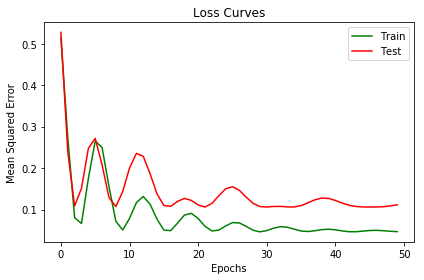


Traing with hyperparam config: 

[0.0001, 0.1, 0.75, 0.0, True, 35, 175, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



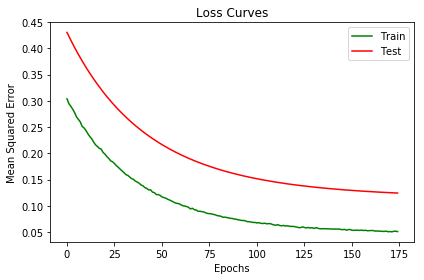


Traing with hyperparam config: 

[5e-05, 0.0001, 0.75, 0.0, False, 17, 50, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



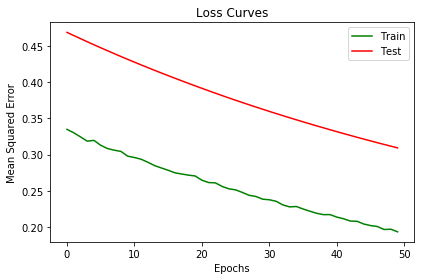


Traing with hyperparam config: 

[5e-05, 0.005, 0.75, 0.0, False, 21, 325, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



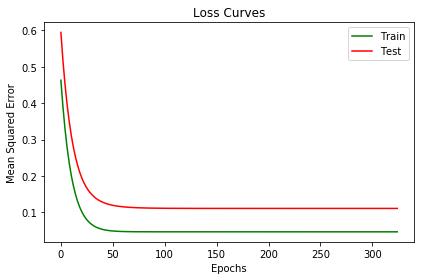


Traing with hyperparam config: 

[0.0003, 0.001, 0.75, 0.0, True, 14, 300, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



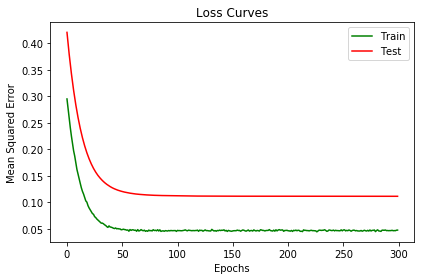


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 35, 325, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



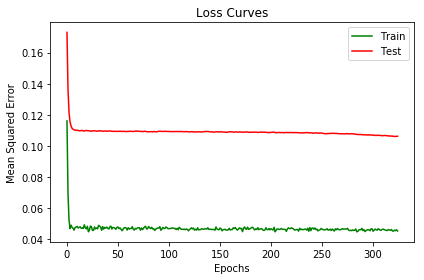


Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, False, 24, 200, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



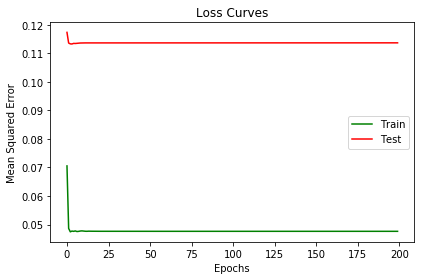


Traing with hyperparam config: 

[0.001, 0.01, 0.99, 0.0, False, 21, 225, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



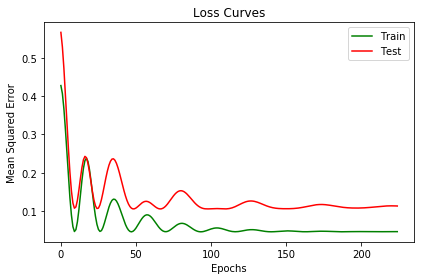


Traing with hyperparam config: 

[0.001, 0.1, 0.99, 0.0, False, 14, 300, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



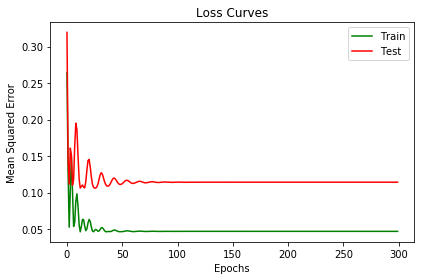


Traing with hyperparam config: 

[0.003, 0.001, 0.5, 0.0, True, 21, 200, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



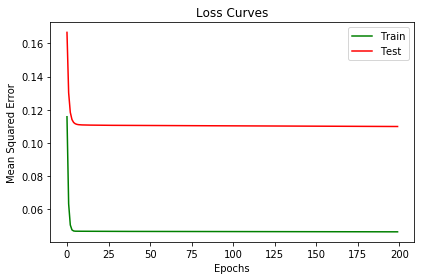


Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, False, 21, 325, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



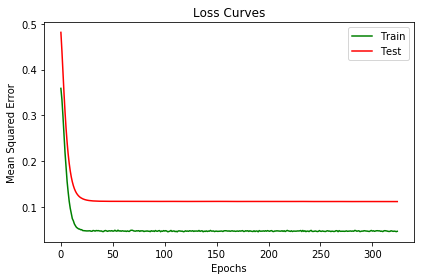


Traing with hyperparam config: 

[0.0005, 0.1, 0.5, 0.0, False, 21, 250, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



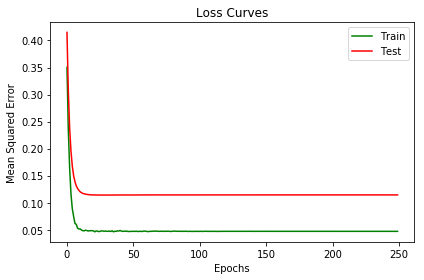


Traing with hyperparam config: 

[0.003, 1e-05, 0.99, 0.0, False, 24, 150, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



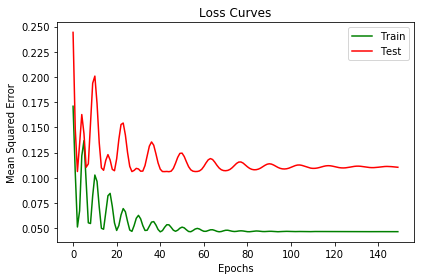


Traing with hyperparam config: 

[0.005, 0.1, 0.5, 0.0, False, 14, 350, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



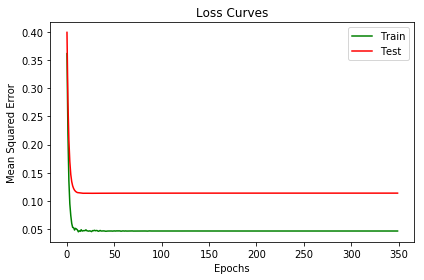


Traing with hyperparam config: 

[0.0003, 0.1, 0.99, 0.0, True, 24, 300, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



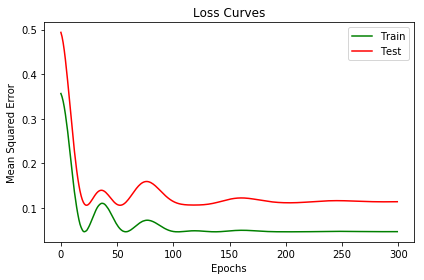


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, True, 35, 275, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



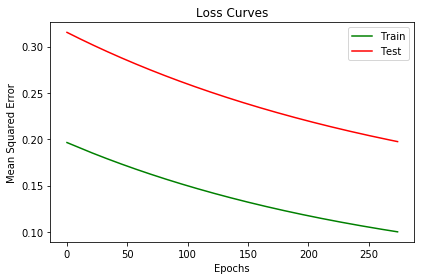


Traing with hyperparam config: 

[0.0001, 0.001, 0.75, 0.0, False, 28, 125, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



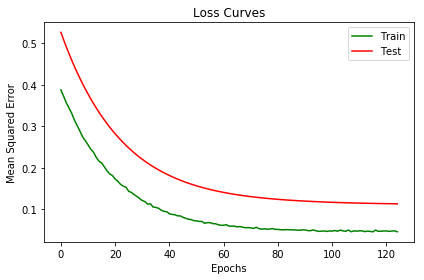


Traing with hyperparam config: 

[0.0005, 0.005, 0.5, 0.0, True, 14, 125, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



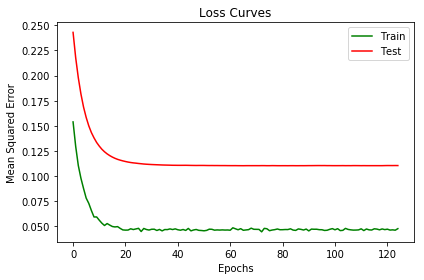


Traing with hyperparam config: 

[0.001, 0.001, 0.5, 0.0, True, 21, 125, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



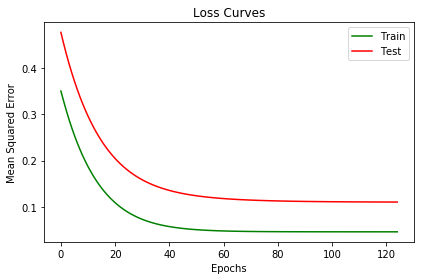


Traing with hyperparam config: 

[5e-05, 1e-05, 0.75, 0.0, True, 17, 225, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



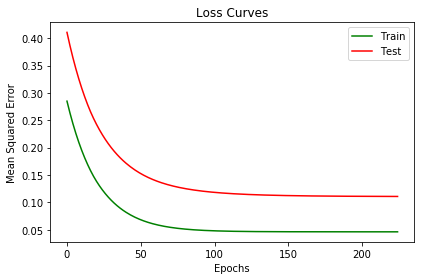


Traing with hyperparam config: 

[0.005, 0.0001, 0.75, 0.0, True, 17, 75, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



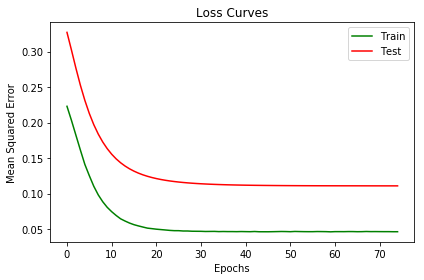


Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, True, 35, 200, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



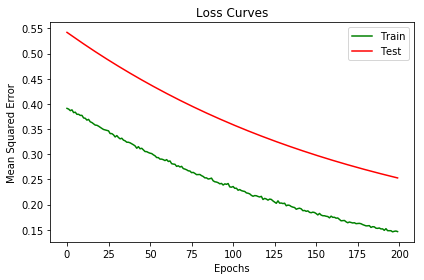


Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, True, 17, 225, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



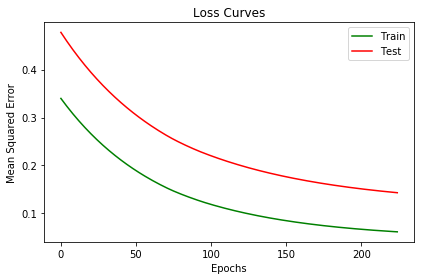


Traing with hyperparam config: 

[0.003, 5e-05, 0.99, 0.0, False, 24, 125, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



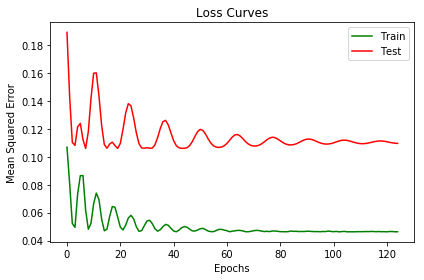


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 35, 375, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



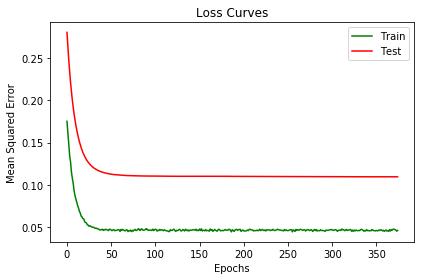


Traing with hyperparam config: 

[0.0003, 1e-05, 0.75, 0.0, True, 28, 175, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



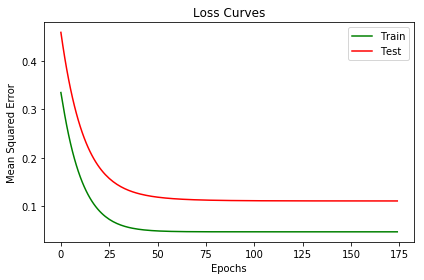


Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 14, 325, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



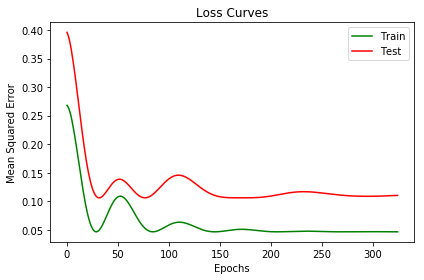


Traing with hyperparam config: 

[0.003, 1e-05, 0.75, 0.0, False, 35, 350, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



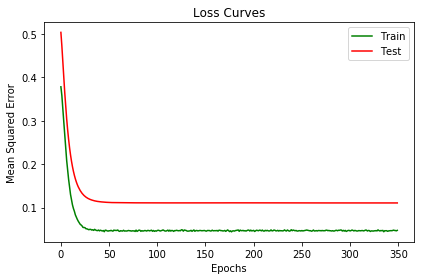


Traing with hyperparam config: 

[0.005, 0.005, 0.5, 0.0, False, 35, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



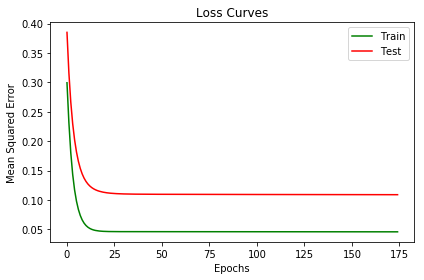


Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, True, 17, 375, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



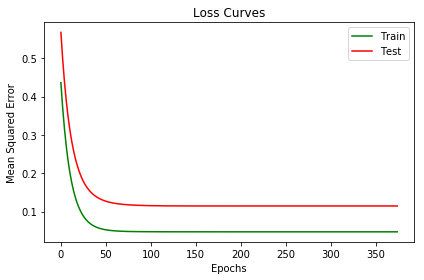


Traing with hyperparam config: 

[0.005, 0.005, 0.5, 0.0, False, 35, 200, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



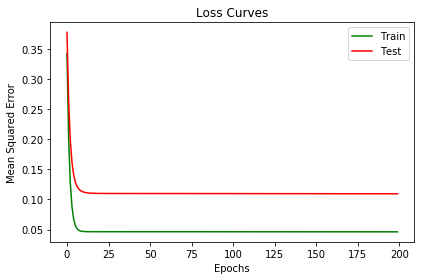


Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 35, 100, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



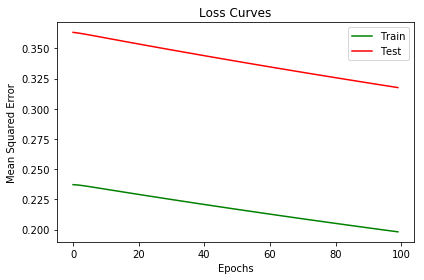


Traing with hyperparam config: 

[0.003, 0.005, 0.99, 0.0, True, 14, 275, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



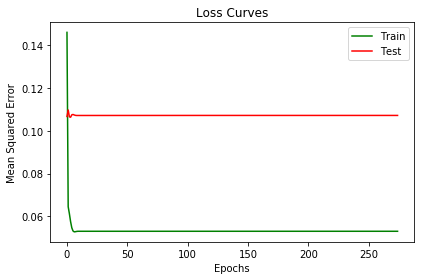


Traing with hyperparam config: 

[0.005, 0.005, 0.99, 0.0, True, 24, 50, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



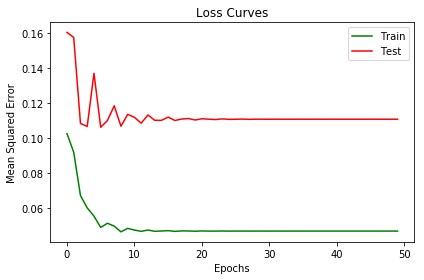


Traing with hyperparam config: 

[0.003, 0.05, 0.5, 0.0, False, 14, 200, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



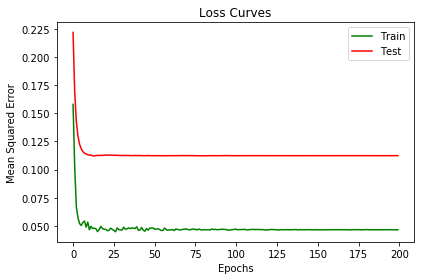


Traing with hyperparam config: 

[0.0003, 0.0001, 0.99, 0.0, True, 14, 150, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



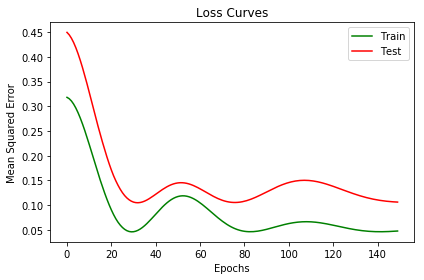


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 24, 75, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



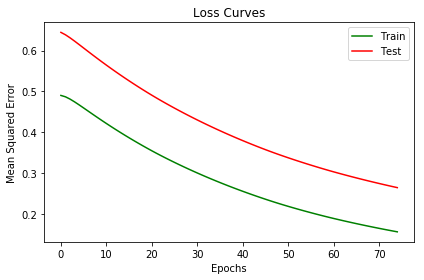


Traing with hyperparam config: 

[0.003, 0.0001, 0.5, 0.0, False, 21, 125, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



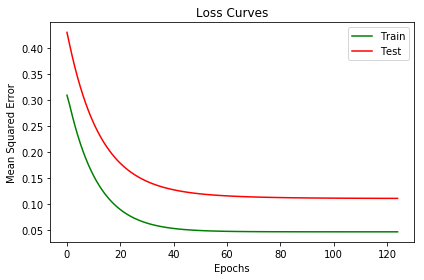


Traing with hyperparam config: 

[0.0001, 0.05, 0.5, 0.0, False, 14, 250, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



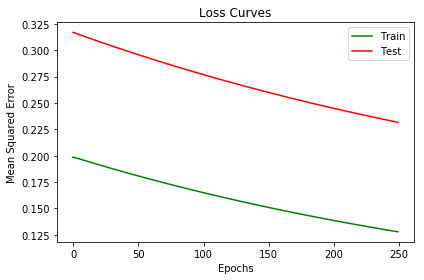


Traing with hyperparam config: 

[0.0001, 0.001, 0.5, 0.0, False, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



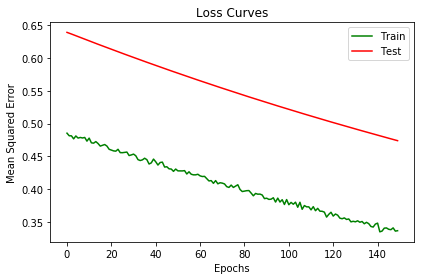


Traing with hyperparam config: 

[0.0003, 0.001, 0.99, 0.0, False, 28, 175, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



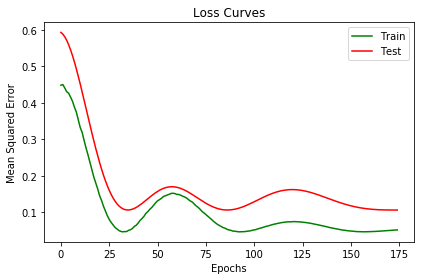


Traing with hyperparam config: 

[0.0005, 5e-05, 0.5, 0.0, False, 28, 125, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



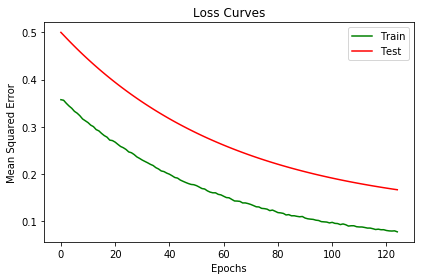


Traing with hyperparam config: 

[0.003, 5e-05, 0.5, 0.0, False, 24, 325, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



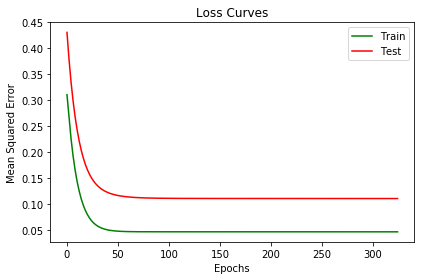


Traing with hyperparam config: 

[0.0001, 5e-05, 0.5, 0.0, False, 14, 175, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



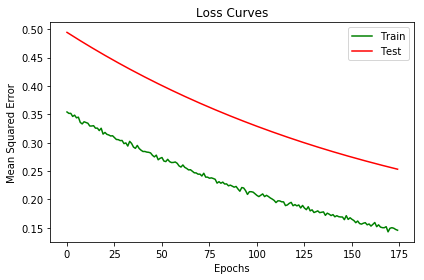


Traing with hyperparam config: 

[0.0005, 0.05, 0.99, 0.0, True, 17, 150, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



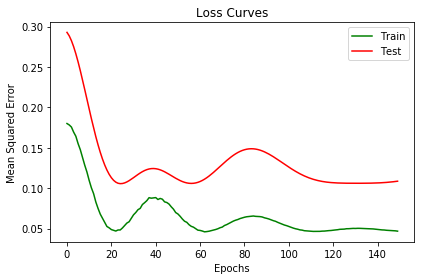


Traing with hyperparam config: 

[5e-05, 0.0001, 0.99, 0.0, True, 17, 50, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



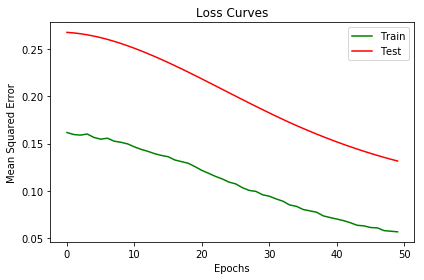


Traing with hyperparam config: 

[5e-05, 0.001, 0.5, 0.0, False, 35, 300, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



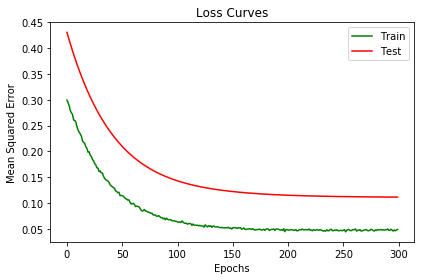


Traing with hyperparam config: 

[0.005, 0.005, 0.5, 0.0, True, 24, 300, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



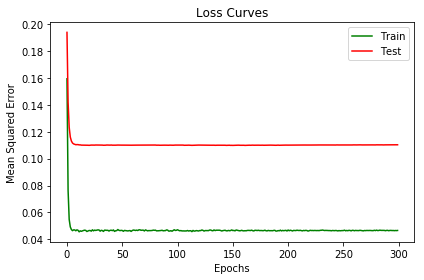


Traing with hyperparam config: 

[0.0001, 5e-05, 0.5, 0.0, False, 14, 300, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



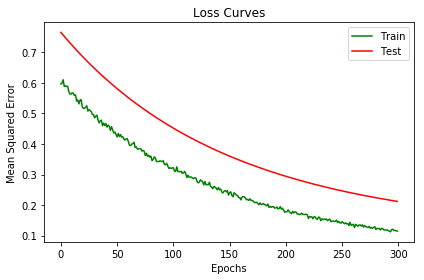


Traing with hyperparam config: 

[0.001, 0.01, 0.75, 0.0, True, 17, 325, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



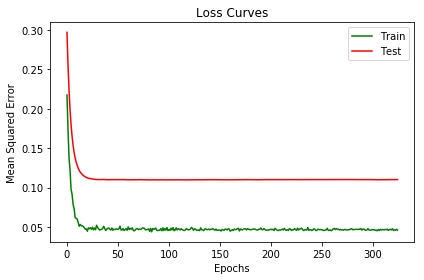


Traing with hyperparam config: 

[0.001, 0.1, 0.75, 0.0, True, 21, 275, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



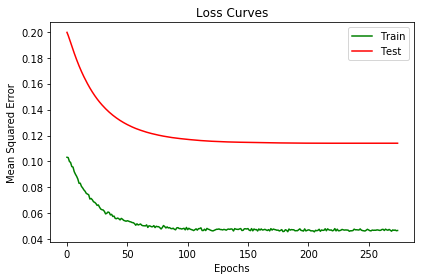


Traing with hyperparam config: 

[0.0001, 0.01, 0.5, 0.0, False, 28, 375, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



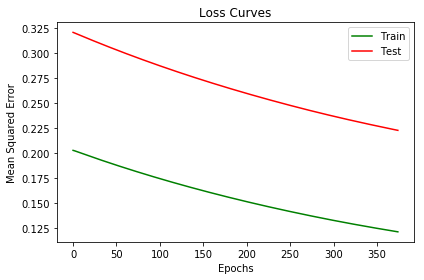


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 21, 75, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



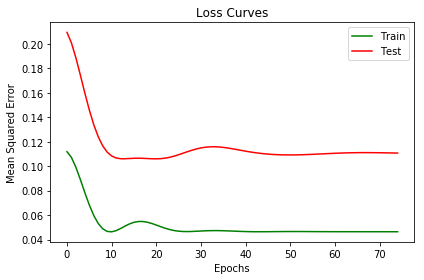


Traing with hyperparam config: 

[0.005, 1e-05, 0.75, 0.0, True, 35, 300, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



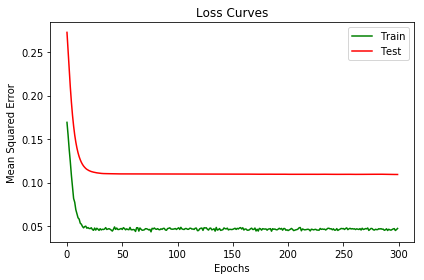


Traing with hyperparam config: 

[0.001, 1e-05, 0.99, 0.0, True, 35, 275, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



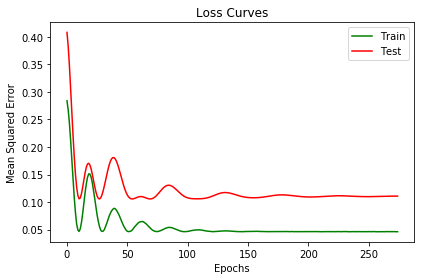


Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, False, 17, 400, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



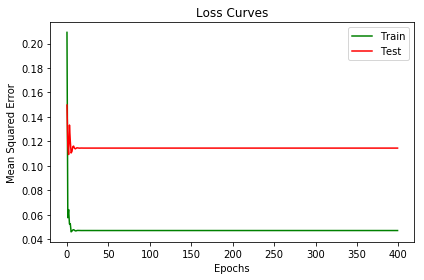


Traing with hyperparam config: 

[0.003, 1e-05, 0.99, 0.0, True, 35, 300, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



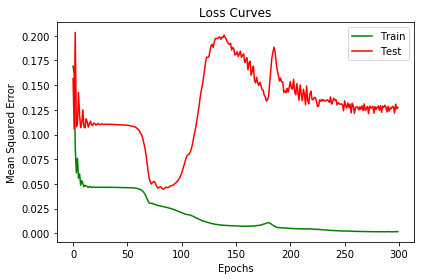


Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, False, 21, 325, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



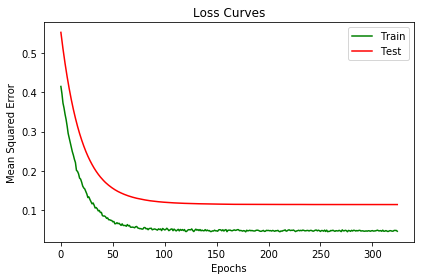


Traing with hyperparam config: 

[0.0005, 0.0001, 0.99, 0.0, False, 24, 75, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



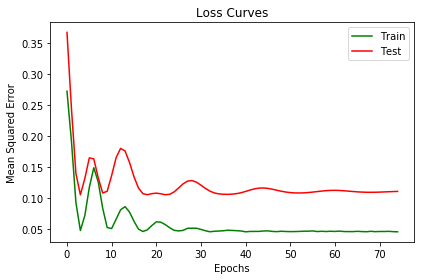


Traing with hyperparam config: 

[0.003, 0.001, 0.5, 0.0, True, 35, 200, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



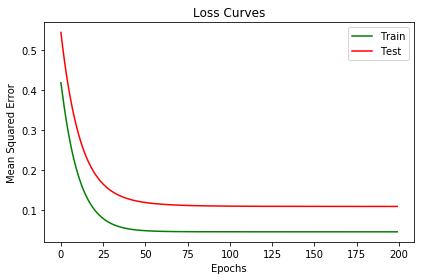


Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, False, 28, 400, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



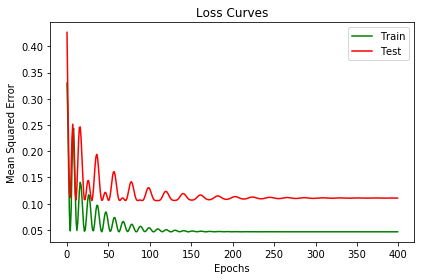


Traing with hyperparam config: 

[0.005, 0.05, 0.5, 0.0, False, 21, 175, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



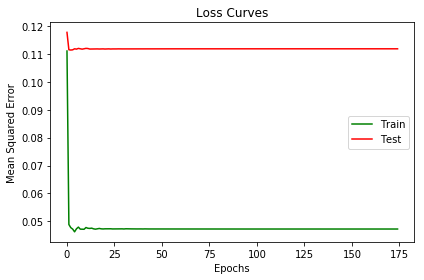


Traing with hyperparam config: 

[0.005, 0.01, 0.75, 0.0, False, 17, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



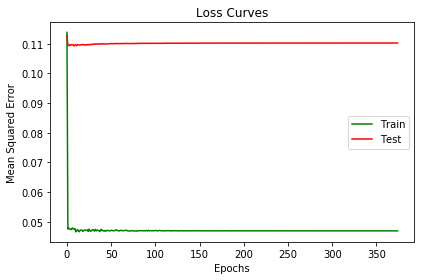


Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, True, 21, 125, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



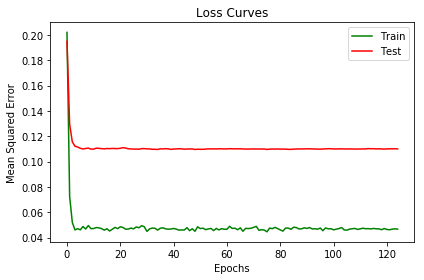


Traing with hyperparam config: 

[0.0001, 0.0001, 0.5, 0.0, True, 17, 50, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



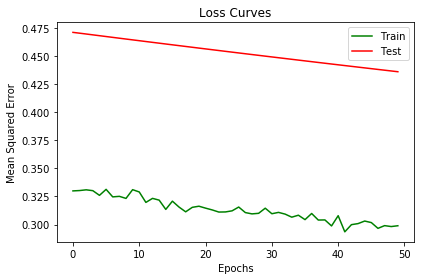


Traing with hyperparam config: 

[5e-05, 0.0001, 0.99, 0.0, True, 21, 50, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



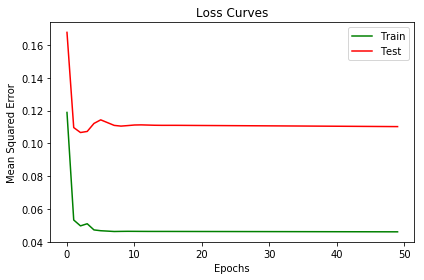


Traing with hyperparam config: 

[0.0003, 0.01, 0.99, 0.0, True, 14, 100, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



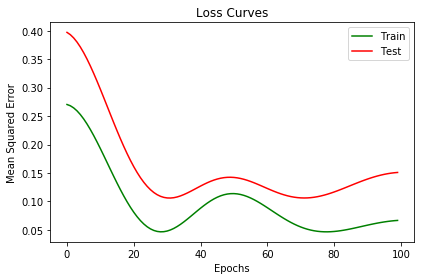


Traing with hyperparam config: 

[0.0005, 0.001, 0.99, 0.0, True, 14, 125, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



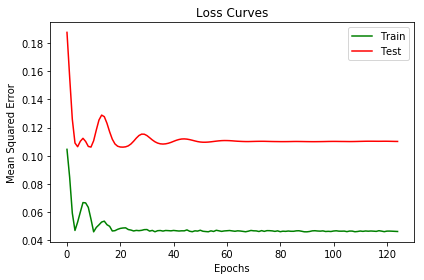


Traing with hyperparam config: 

[0.003, 0.05, 0.5, 0.0, True, 17, 300, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



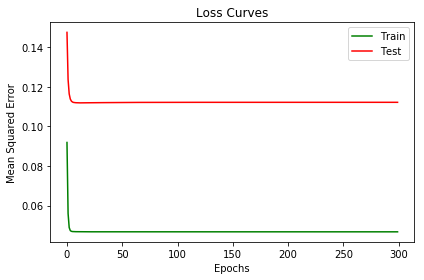


Traing with hyperparam config: 

[0.0005, 0.05, 0.99, 0.0, False, 28, 125, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



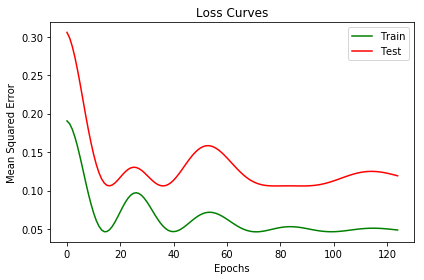


Traing with hyperparam config: 

[0.0001, 1e-05, 0.75, 0.0, True, 17, 250, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



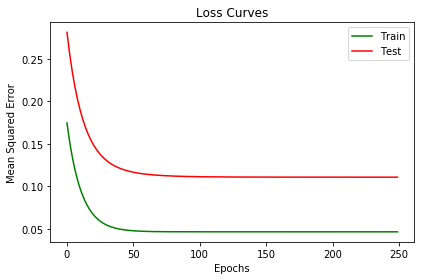


Traing with hyperparam config: 

[0.0001, 0.0001, 0.75, 0.0, False, 35, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



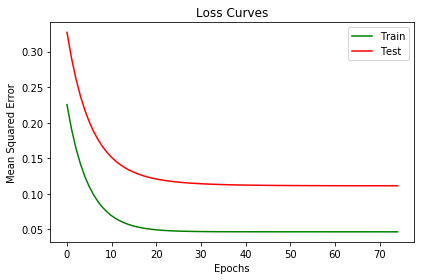


Traing with hyperparam config: 

[5e-05, 0.05, 0.99, 0.0, True, 35, 50, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



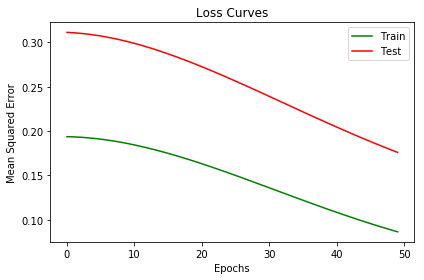


Traing with hyperparam config: 

[0.0003, 0.05, 0.5, 0.0, True, 35, 375, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



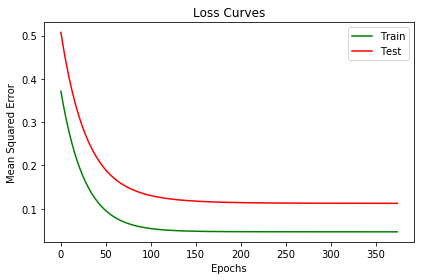


Traing with hyperparam config: 

[0.003, 0.01, 0.5, 0.0, False, 21, 375, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



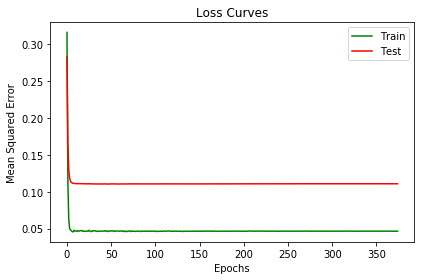


Traing with hyperparam config: 

[0.0001, 5e-05, 0.99, 0.0, True, 35, 275, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



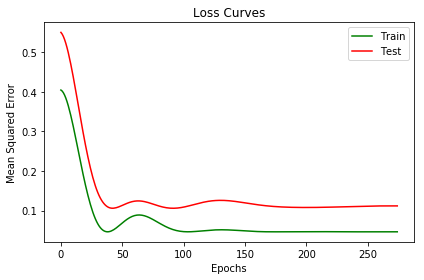


Traing with hyperparam config: 

[5e-05, 0.0001, 0.75, 0.0, False, 21, 100, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



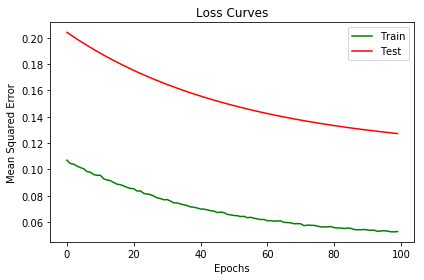


Traing with hyperparam config: 

[0.0003, 0.001, 0.75, 0.0, False, 28, 375, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



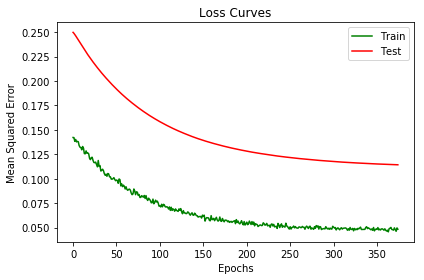


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, True, 17, 150, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



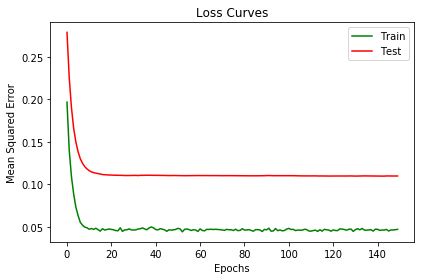


Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, True, 24, 125, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



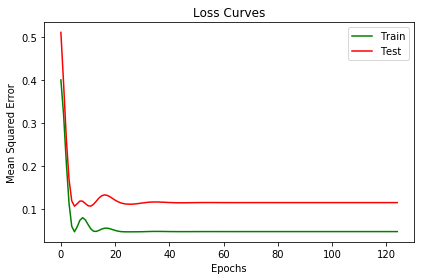


Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 24, 400, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



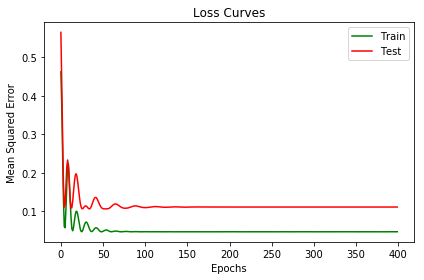


Traing with hyperparam config: 

[0.001, 0.0001, 0.99, 0.0, False, 21, 300, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



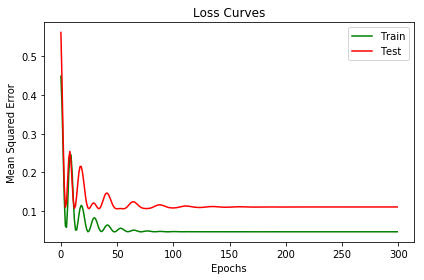


Traing with hyperparam config: 

[0.0001, 1e-05, 0.75, 0.0, False, 21, 250, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



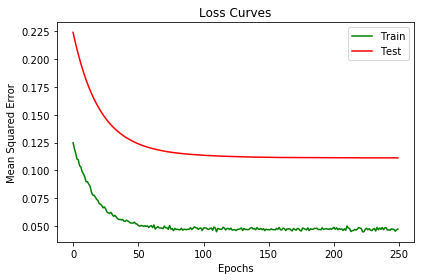


Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, True, 17, 300, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



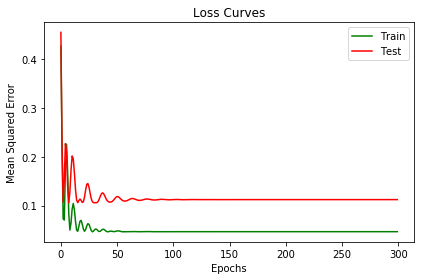


Traing with hyperparam config: 

[0.001, 0.005, 0.75, 0.0, True, 17, 350, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



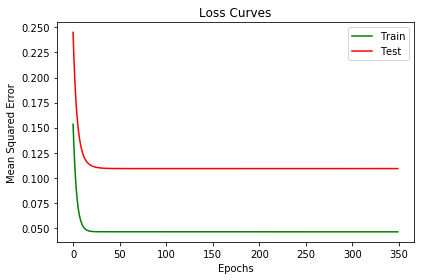


Traing with hyperparam config: 

[0.005, 0.005, 0.75, 0.0, True, 35, 300, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



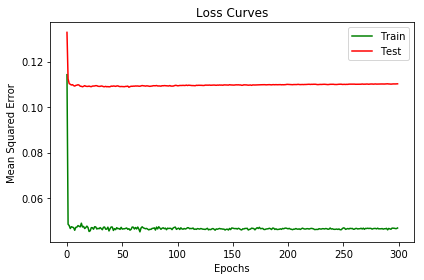


Traing with hyperparam config: 

[0.0001, 0.005, 0.99, 0.0, False, 21, 175, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



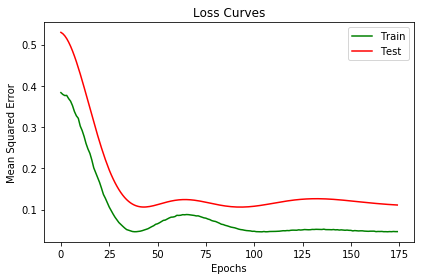


Traing with hyperparam config: 

[5e-05, 0.001, 0.99, 0.0, True, 14, 50, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



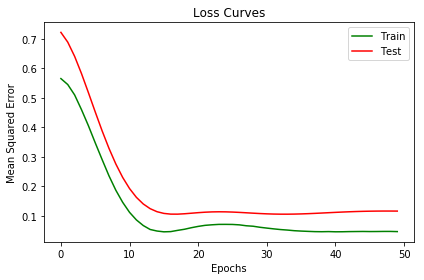


Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, False, 24, 325, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



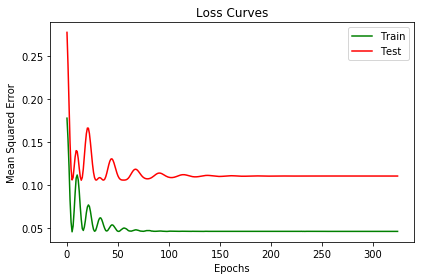


Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, False, 28, 275, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



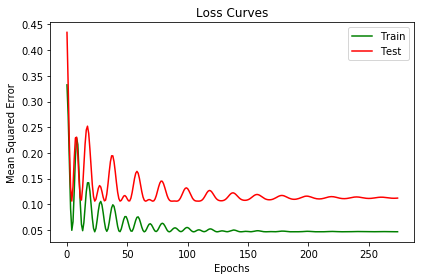


Traing with hyperparam config: 

[0.003, 0.1, 0.75, 0.0, False, 17, 100, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



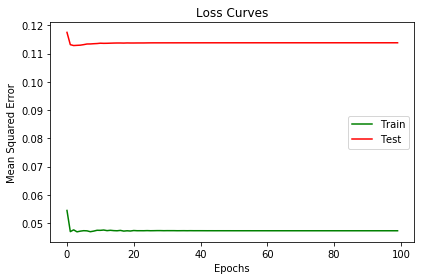


Traing with hyperparam config: 

[5e-05, 0.005, 0.75, 0.0, False, 35, 350, 0.0, 64, <class 'torch.optim.sgd.SGD'>] 



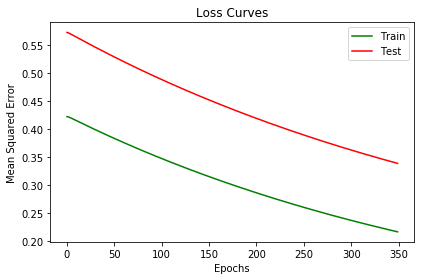


Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 28, 50, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



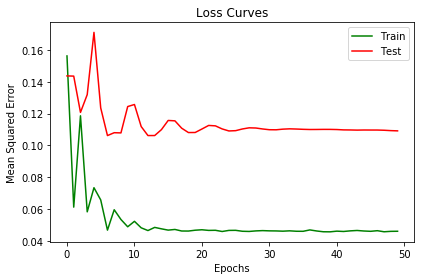


Traing with hyperparam config: 

[5e-05, 5e-05, 0.5, 0.0, False, 14, 400, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



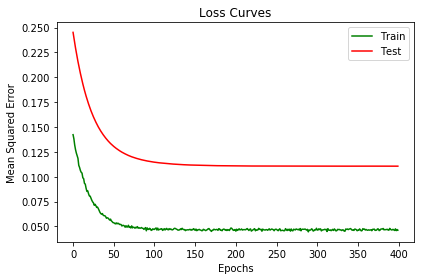


Traing with hyperparam config: 

[5e-05, 0.005, 0.75, 0.0, False, 21, 200, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



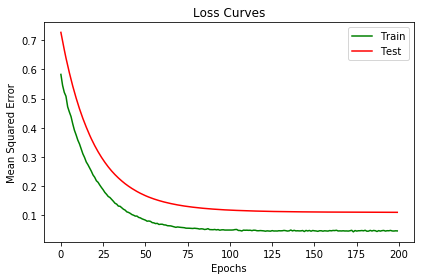


Traing with hyperparam config: 

[0.003, 0.001, 0.5, 0.0, False, 35, 150, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



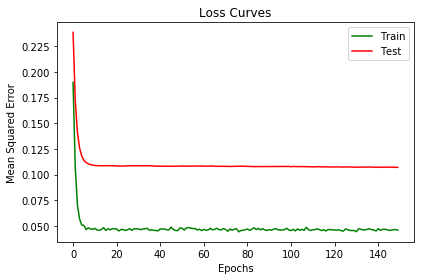


Traing with hyperparam config: 

[0.0001, 5e-05, 0.75, 0.0, False, 24, 250, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



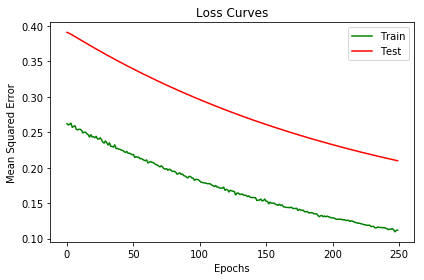


Traing with hyperparam config: 

[0.0003, 0.05, 0.75, 0.0, False, 21, 75, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



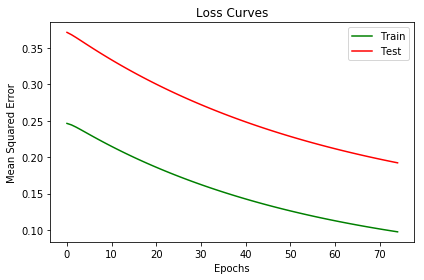


Traing with hyperparam config: 

[0.003, 0.0001, 0.5, 0.0, True, 14, 150, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



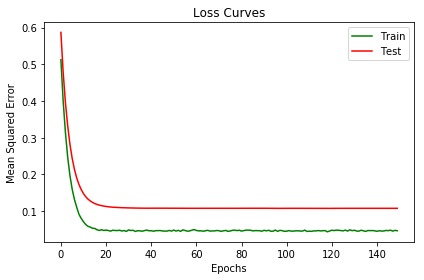


Traing with hyperparam config: 

[0.0005, 0.005, 0.75, 0.0, True, 24, 125, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



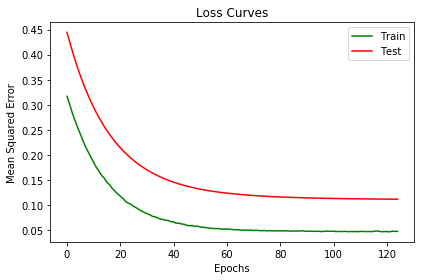


Traing with hyperparam config: 

[5e-05, 0.1, 0.75, 0.0, False, 24, 125, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



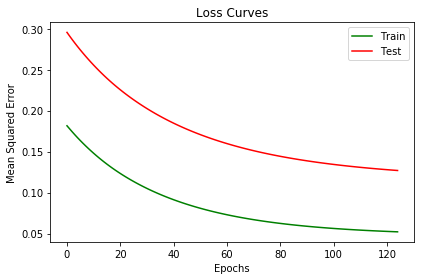


Traing with hyperparam config: 

[0.005, 0.001, 0.75, 0.0, True, 35, 125, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



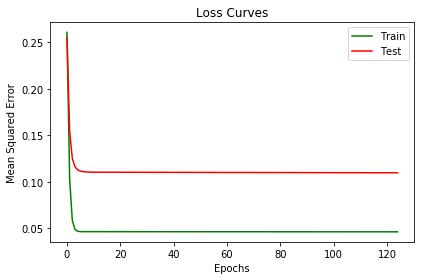


Traing with hyperparam config: 

[0.001, 0.005, 0.5, 0.0, True, 24, 300, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



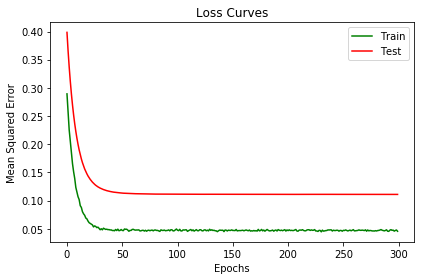


Traing with hyperparam config: 

[0.005, 1e-05, 0.99, 0.0, False, 24, 100, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



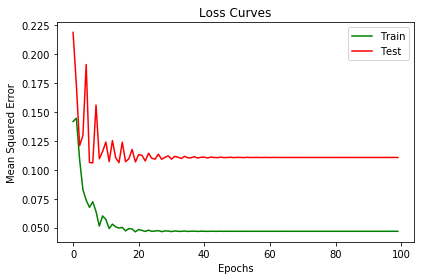


Traing with hyperparam config: 

[0.0003, 0.001, 0.5, 0.0, False, 14, 275, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



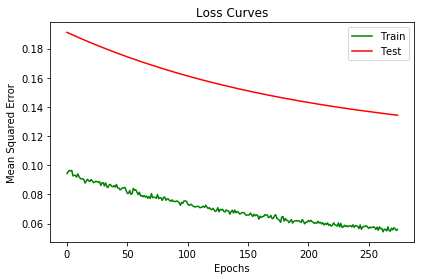


Traing with hyperparam config: 

[0.001, 0.01, 0.99, 0.0, True, 21, 400, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



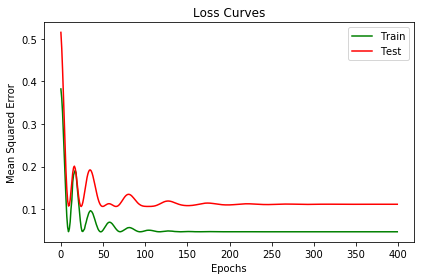


Traing with hyperparam config: 

[0.0005, 1e-05, 0.75, 0.0, True, 35, 275, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



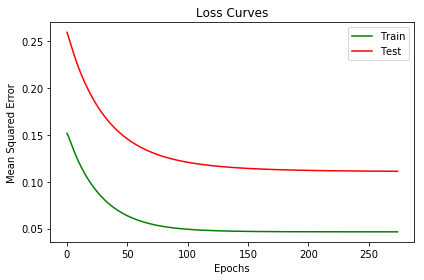


Traing with hyperparam config: 

[0.003, 5e-05, 0.75, 0.0, False, 14, 375, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



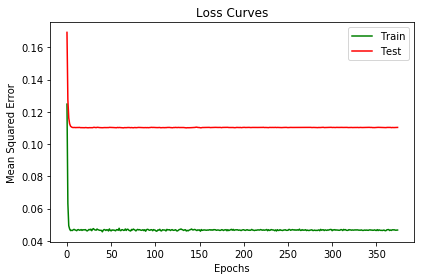


Traing with hyperparam config: 

[0.0003, 0.001, 0.75, 0.0, False, 24, 225, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



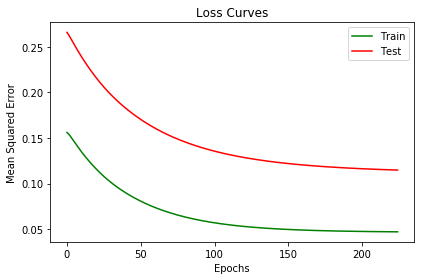


Traing with hyperparam config: 

[0.001, 0.05, 0.99, 0.0, True, 21, 300, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



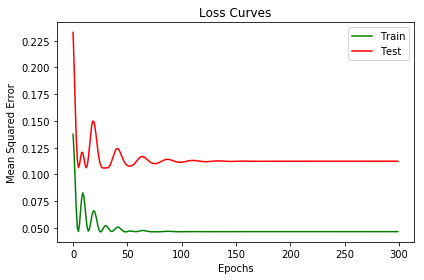


Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, True, 21, 400, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



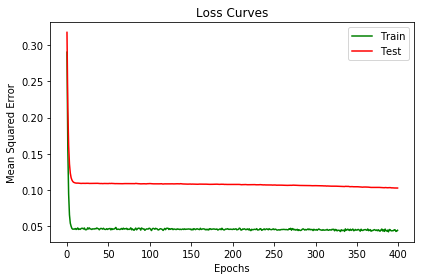


Traing with hyperparam config: 

[0.003, 0.05, 0.99, 0.0, False, 35, 50, 0.3, 2, <class 'torch.optim.sgd.SGD'>] 



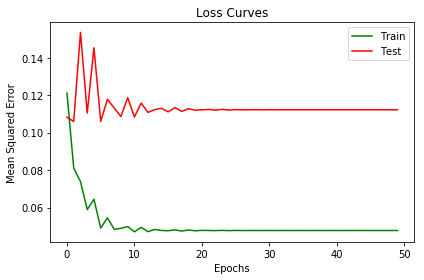


Traing with hyperparam config: 

[5e-05, 0.001, 0.99, 0.0, True, 24, 125, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



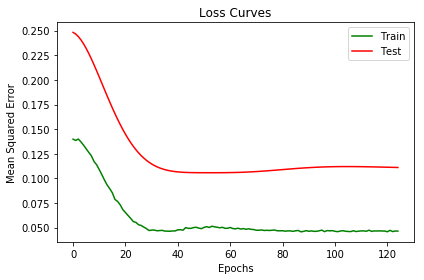


Traing with hyperparam config: 

[5e-05, 0.0001, 0.5, 0.0, True, 28, 350, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



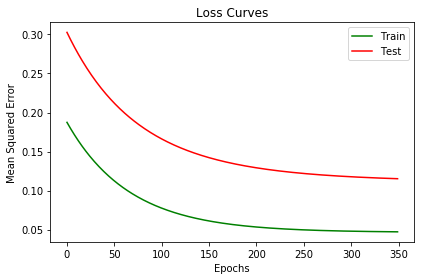


Traing with hyperparam config: 

[0.0005, 0.001, 0.99, 0.0, True, 28, 325, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



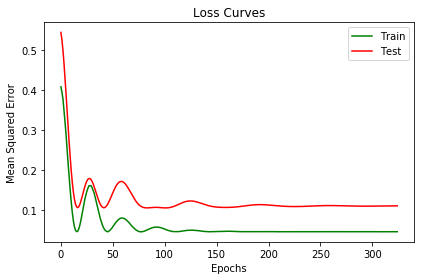


Traing with hyperparam config: 

[0.005, 0.001, 0.5, 0.0, True, 17, 100, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



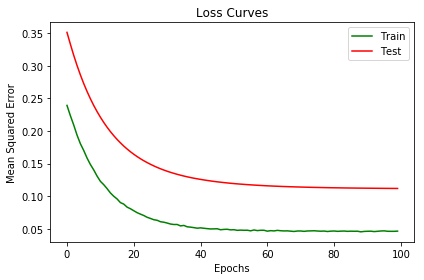


Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, False, 14, 225, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



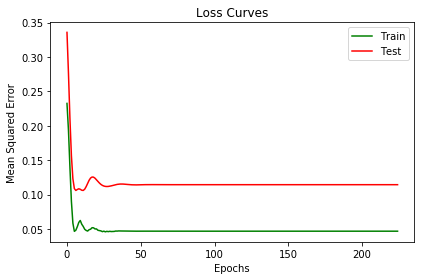


Traing with hyperparam config: 

[0.0001, 1e-05, 0.5, 0.0, True, 17, 150, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



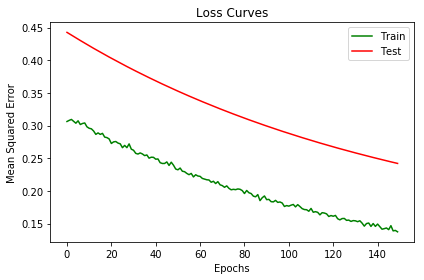


Traing with hyperparam config: 

[0.005, 0.1, 0.75, 0.0, True, 14, 150, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



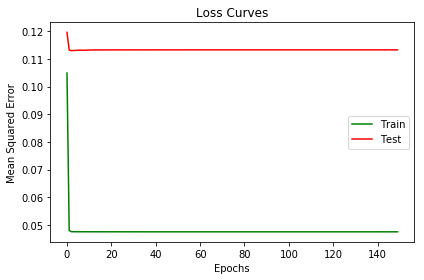


Traing with hyperparam config: 

[0.001, 0.1, 0.5, 0.0, True, 24, 75, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



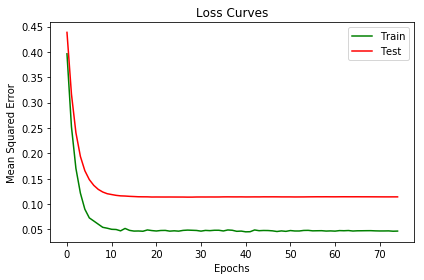


Traing with hyperparam config: 

[0.0003, 5e-05, 0.75, 0.0, True, 28, 100, 0.0, 2, <class 'torch.optim.sgd.SGD'>] 



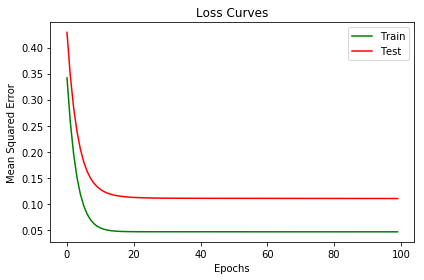


Traing with hyperparam config: 

[0.0001, 0.005, 0.75, 0.0, True, 14, 350, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



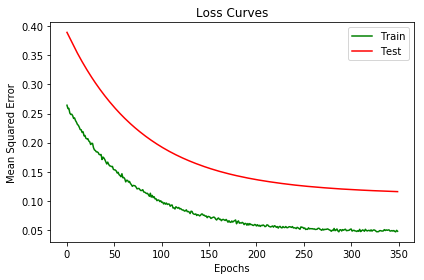


Traing with hyperparam config: 

[0.001, 0.001, 0.99, 0.0, True, 35, 325, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



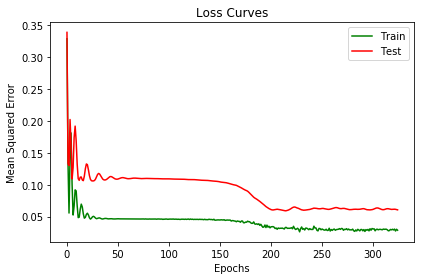


Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, True, 24, 75, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



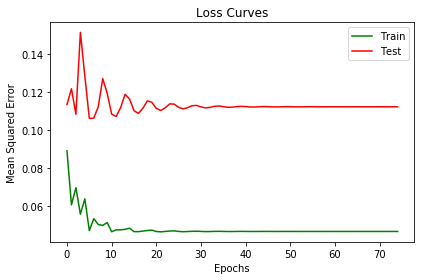


Traing with hyperparam config: 

[0.001, 0.005, 0.99, 0.0, True, 21, 325, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



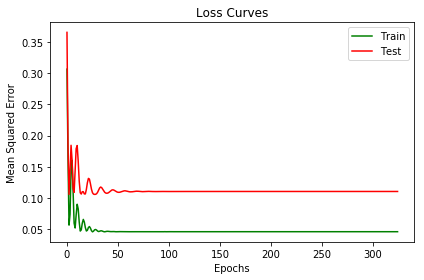


Traing with hyperparam config: 

[0.003, 0.01, 0.99, 0.0, True, 21, 175, 0.3, 32, <class 'torch.optim.sgd.SGD'>] 



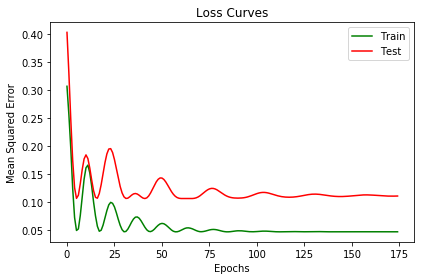


Traing with hyperparam config: 

[0.0001, 0.001, 0.99, 0.0, False, 17, 125, 0.3, 8, <class 'torch.optim.sgd.SGD'>] 



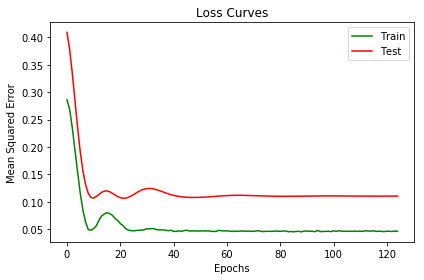


Traing with hyperparam config: 

[5e-05, 5e-05, 0.75, 0.0, False, 28, 225, 0.5, 64, <class 'torch.optim.sgd.SGD'>] 



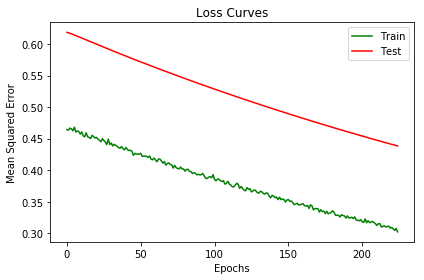


Traing with hyperparam config: 

[0.0005, 5e-05, 0.75, 0.0, False, 17, 75, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



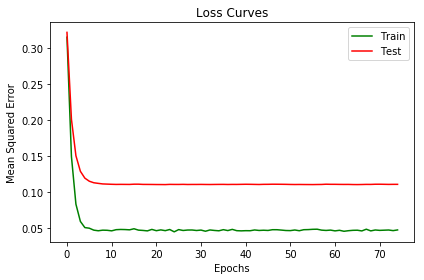


Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, False, 28, 225, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



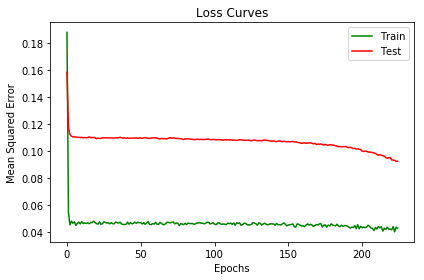


Traing with hyperparam config: 

[0.0005, 5e-05, 0.5, 0.0, False, 35, 100, 0.5, 1, <class 'torch.optim.sgd.SGD'>] 



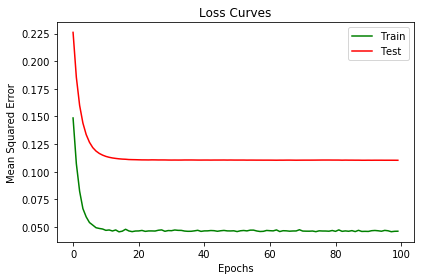


Traing with hyperparam config: 

[0.005, 0.05, 0.99, 0.0, True, 21, 325, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



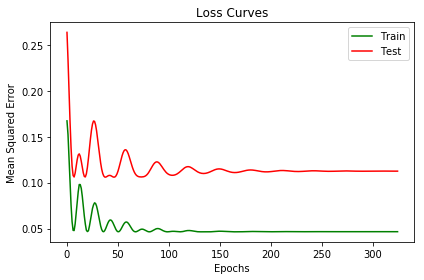


Traing with hyperparam config: 

[0.005, 0.1, 0.75, 0.0, False, 14, 250, 0.0, 32, <class 'torch.optim.sgd.SGD'>] 



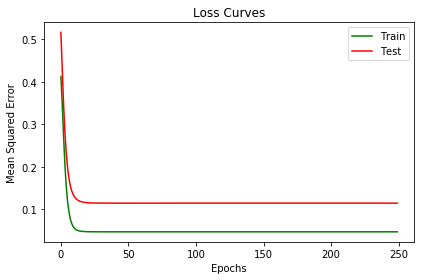


Traing with hyperparam config: 

[0.003, 0.0001, 0.99, 0.0, True, 24, 150, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



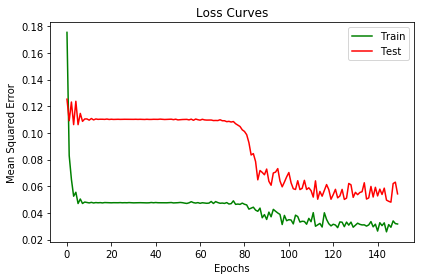


Traing with hyperparam config: 

[0.003, 0.0001, 0.75, 0.0, True, 28, 325, 0.5, 16, <class 'torch.optim.sgd.SGD'>] 



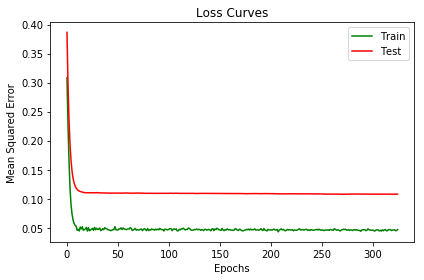


Traing with hyperparam config: 

[0.0003, 5e-05, 0.99, 0.0, True, 17, 175, 0.0, 16, <class 'torch.optim.sgd.SGD'>] 



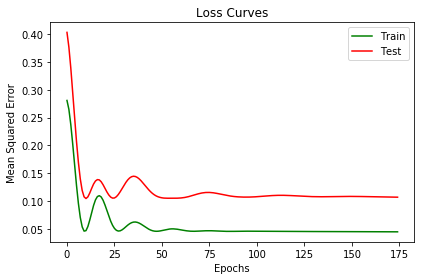


Traing with hyperparam config: 

[5e-05, 0.005, 0.5, 0.0, False, 28, 325, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



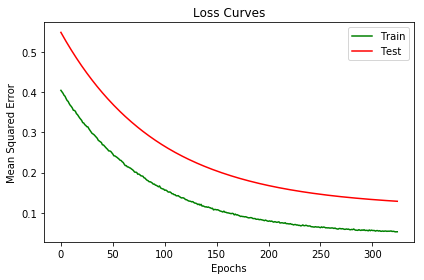


Traing with hyperparam config: 

[0.0005, 0.0001, 0.5, 0.0, True, 24, 350, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



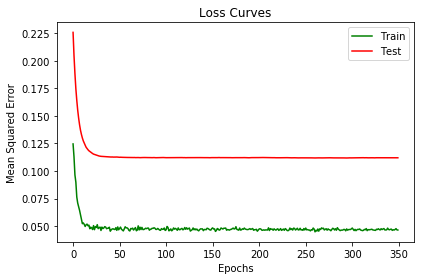


Traing with hyperparam config: 

[0.001, 0.0001, 0.5, 0.0, False, 21, 75, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



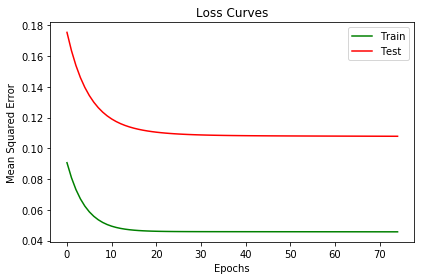


Traing with hyperparam config: 

[0.0001, 0.0001, 0.99, 0.0, False, 24, 125, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



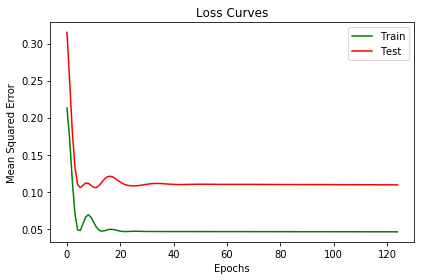


Traing with hyperparam config: 

[0.0005, 5e-05, 0.99, 0.0, True, 17, 200, 0.3, 4, <class 'torch.optim.sgd.SGD'>] 



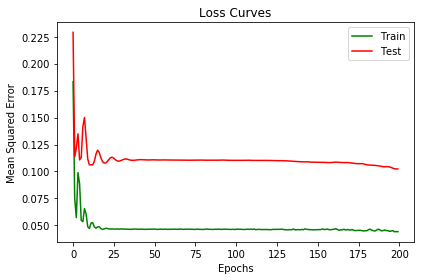


Traing with hyperparam config: 

[0.0001, 0.1, 0.99, 0.0, False, 24, 350, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 



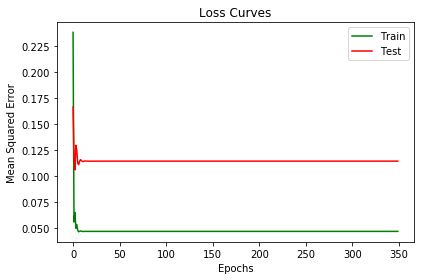


Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, False, 14, 250, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



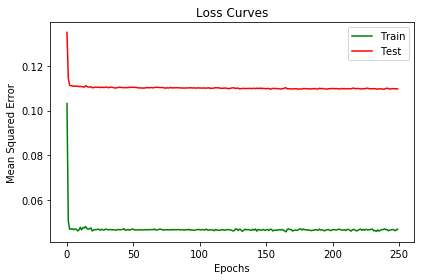


Traing with hyperparam config: 

[0.0001, 0.001, 0.99, 0.0, False, 35, 75, 0.0, 1, <class 'torch.optim.sgd.SGD'>] 



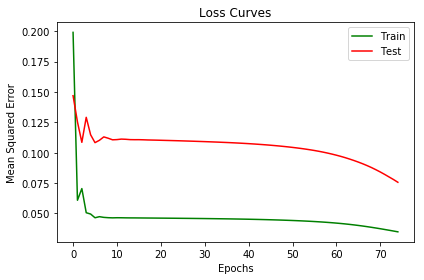


Traing with hyperparam config: 

[0.005, 5e-05, 0.75, 0.0, True, 17, 50, 0.0, 4, <class 'torch.optim.sgd.SGD'>] 



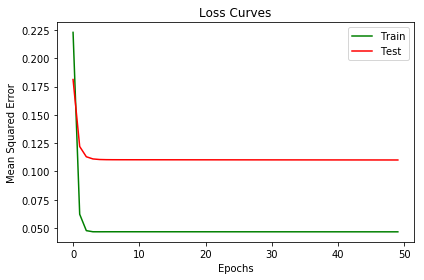


Traing with hyperparam config: 

[0.005, 5e-05, 0.5, 0.0, True, 21, 300, 0.3, 64, <class 'torch.optim.sgd.SGD'>] 



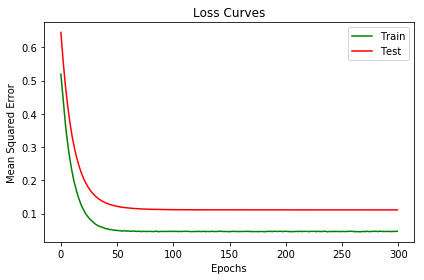


Traing with hyperparam config: 

[0.0005, 0.001, 0.75, 0.0, False, 17, 400, 0.5, 8, <class 'torch.optim.sgd.SGD'>] 



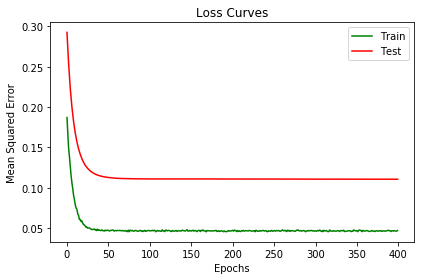


Traing with hyperparam config: 

[0.001, 1e-05, 0.5, 0.0, True, 17, 300, 0.0, 8, <class 'torch.optim.sgd.SGD'>] 



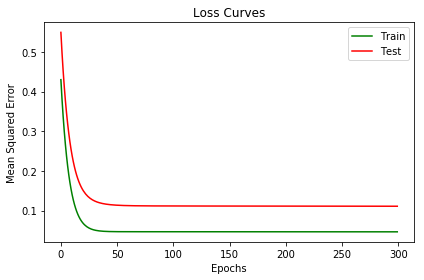


Traing with hyperparam config: 

[5e-05, 0.0001, 0.99, 0.0, True, 14, 400, 0.5, 32, <class 'torch.optim.sgd.SGD'>] 



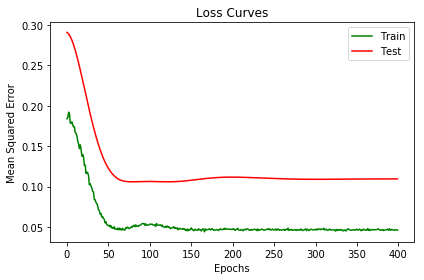


Traing with hyperparam config: 

[0.001, 5e-05, 0.5, 0.0, False, 14, 250, 0.3, 16, <class 'torch.optim.sgd.SGD'>] 



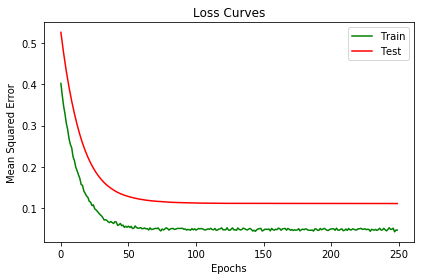


Traing with hyperparam config: 

[0.0003, 0.05, 0.5, 0.0, False, 17, 50, 0.5, 2, <class 'torch.optim.sgd.SGD'>] 



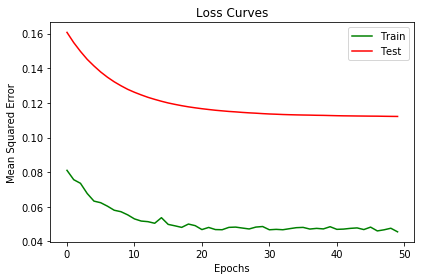


Traing with hyperparam config: 

[0.001, 5e-05, 0.75, 0.0, False, 24, 125, 0.5, 4, <class 'torch.optim.sgd.SGD'>] 



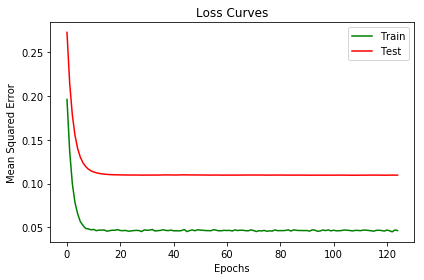


Traing with hyperparam config: 

[0.001, 5e-05, 0.99, 0.0, True, 28, 100, 0.3, 1, <class 'torch.optim.sgd.SGD'>] 

*********************Best hyperparam configuration training.**************


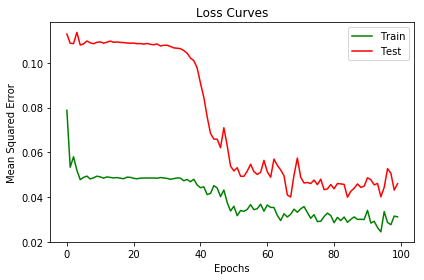

******************************************************************************


In [15]:
# Load the test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

# Separate test features and targets
X_testing = testing_data.iloc[:,0:num_features].values
Y_testing = pd.DataFrame(testing_data["Hardness"]).values



last_epoch_training_losses = []

for idxx in range(len(random_hyperparameter_configurations)):
    
    print("\nConfig no: " + str(idx4)+ ", Training with hyperparam config: \n")
    print(random_hyperparameter_configurations[idxx], "\n")
    
    if idxx == estimator_index_for_least_avg_mse:
        print("*********************Best hyperparam configuration training.**************")
    
    net = NeuralNetRegressor(       module=Regression_Module,
                        
                                    optimizer__lr = random_hyperparameter_configurations[idxx][0],
                                    optimizer__weight_decay = random_hyperparameter_configurations[idxx][1],
                                    optimizer__momentum = random_hyperparameter_configurations[idxx][2],
                                    optimizer__dampening = random_hyperparameter_configurations[idxx][3],
                                    optimizer__nesterov = random_hyperparameter_configurations[idxx][4],
                                    module__num_units = random_hyperparameter_configurations[idxx][5],
                                    max_epochs = random_hyperparameter_configurations[idxx][6],
                                    module__dropout = random_hyperparameter_configurations[idxx][7],
                                    iterator_train__batch_size = random_hyperparameter_configurations[idxx][8],
                                    optimizer = random_hyperparameter_configurations[idxx][9],
                                    verbose = 0,
                                    warm_start = False,
                             
                                    # Added when cross-validation not done
                                    device = device_to_use,
                                    
                                    callbacks=[Epoch_TestData_Loss(X_testing, Y_testing, idxx)], #  <-- Notice the callback.

                                    )

    net.fit(X = X_training.values, y = Y_training.values, )
    
    net.save_params(f_params="../Saved_Models/nn_model_" + str(idxx) + ".pkl")
    # https://skorch.readthedocs.io/en/stable/user/save_load.html
    
    if idxx == estimator_index_for_least_avg_mse:
        print("******************************************************************************")
    

## Use all 350 models to predict on every test sample

In [16]:
test_predictions_by_all_estimators = []

# Using each hyperparameter-config trained model, predict on all the test samples
for model_num in range(0,no_of_hyperparam_configs):
    # Load the test data
    testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
    testing_data.head()

    # Separate test features and targets
    X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
    Y_testing = pd.DataFrame(testing_data["Hardness"]).values
    
    
    loaded_net = NeuralNetRegressor(module=Regression_Module,
                        
                                    #optimizer__lr = random_hyperparameter_configurations[model_num][0],
                                    #optimizer__weight_decay = random_hyperparameter_configurations[model_num][1],
                                    #optimizer__momentum = random_hyperparameter_configurations[model_num][2],
                                    #optimizer__dampening = random_hyperparameter_configurations[model_num][3],
                                    #optimizer__nesterov = random_hyperparameter_configurations[model_num][4],
                                    module__num_units = random_hyperparameter_configurations[model_num][5],
                                    #max_epochs = random_hyperparameter_configurations[model_num][6],
                                    #module__dropout = random_hyperparameter_configurations[model_num][7],
                                    #iterator_train__batch_size = random_hyperparameter_configurations[model_num][8],
                                    #optimizer = random_hyperparameter_configurations[model_num][9],
                                    verbose = 0,
                                    warm_start = False,
                             
                                    # Added when cross-validation not done
                                    device = device_to_use,
                                    
                                    #callbacks=[Epoch_TestData_Loss(X_testing, Y_testing)], #  <-- Notice the callback.

                                    )
    
    
        
    # Initialize the estimator with the trained parameters
    loaded_net.initialize() # <-- This is important!
    loaded_net.load_params(f_params="../Saved_Models/nn_model_" + str(model_num) + ".pkl")
    
    # Since we are using a torch model that has dropout layers, important to switch to eval() mode before predicting
    loaded_net.module_.eval()
    
    # Predict using this estimator
    test_predictions = loaded_net.predict(X_testing.astype(np.float32))
    # Store the predictions
    test_predictions_by_all_estimators.append(test_predictions)
    

In [17]:
# Save the predictions made by all the estimators

with open('test_predictions_by_all_estimators.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(test_predictions_by_all_estimators)

# np_array_predictions = np.array(test_predictions_by_all_estimators)
# np.savetxt("test_predictions_by_all_estimators.csv", np_array_predictions, delimiter = ",")

## Plot Uncertainty among different models trained for each test sample


Test Sample No. : 0
Predictions for this sample by all models: [ 0.47451353  0.47608268  0.52973896  0.44717836  0.46671501  0.47558075
  0.46586543  0.46596038  0.41825399  0.44855255  0.47205013  0.47734874
  0.46480426  0.25854638  0.35779133  0.48427013  0.03649757  0.29386854
  0.45550266  0.47724977  0.4763391   0.47513112  0.47755584  0.47995427
  0.46316421  0.46386513  0.46773812  0.45930272  0.4481214   0.47491562
  0.47755164  0.47900617  0.42726147  0.48208123  0.47404248  0.48080379
  0.47902912 -0.10307755  0.42599154  0.47863823  0.47805202  0.23261708
  0.43199033  0.483843    0.47905588  0.45712781  0.45715651  0.47638816
  0.47177571  0.45610234  0.48335803  0.29414648  0.24765694  0.47878134
  0.17903182  0.47517461  0.47892994  0.10034969  0.48417598  0.47792059
  0.23331666  0.4652518   0.47132751  0.46520603  0.4722178   0.34613317
  0.4153291   0.16827533  0.45125991  0.21450441  0.29741427  0.4676348
  0.47232759  0.46914196  0.10931912  0.27708638  0.4820019  

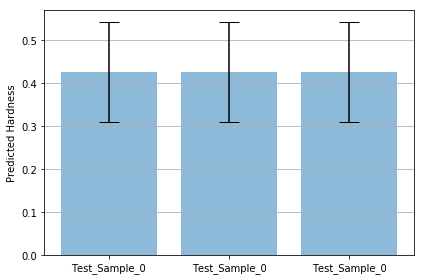


Test Sample No. : 1
Predictions for this sample by all models: [ 0.47457725  0.47595966  0.52793145  0.44675177  0.46681386  0.47889656
  0.46586543  0.46577185  0.41879526  0.44698584  0.48694533  0.47749481
  0.54337853  0.2607381   0.36097151  0.48823667  0.03619626  0.29377839
  0.45550266  0.47807908  0.47928464  0.47515699  0.47838831  0.47968763
  0.50215298  0.49365726  0.46773812  0.46066648  0.44883102  0.48113406
  0.47957817  0.47891116  0.42778966  0.48006484  0.530725    0.47939259
  0.47891119 -0.10226368  0.42636395  0.48062688  0.47837383  0.23347783
  0.43193462  0.53625441  0.4799099   0.45712781  0.45715651  0.47633329
  0.47141814  0.45610234  0.48337734  0.2912904   0.24511701  0.47879735
  0.17806287  0.47648072  0.48033351  0.10195675  0.48216423  0.48166838
  0.23579958  0.46734163  0.47107616  0.4656226   0.47190702  0.34359199
  0.41853356  0.06879634  0.4480496   0.21528719  0.29690689  0.46744725
  0.4791638   0.47169504  0.1110007   0.2777316   0.48206985

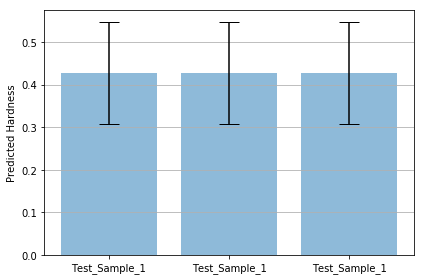


Test Sample No. : 2
Predictions for this sample by all models: [ 0.47597718  0.47522962  0.52792943  0.44642299  0.46685219  0.48115903
  0.46586543  0.46582752  0.41731849  0.44732264  0.48688692  0.47747669
  0.54590386  0.26009449  0.35896683  0.48760438  0.03557406  0.29285851
  0.45550266  0.47765985  0.47880492  0.4751581   0.47897863  0.47811311
  0.51773709  0.49152344  0.46773812  0.45963451  0.44916508  0.48220783
  0.4785834   0.47868392  0.4284099   0.48096159  0.61048365  0.47871134
  0.47948629 -0.10325547  0.42606676  0.48014742  0.4820092   0.23330015
  0.43174404  0.55526507  0.48032334  0.45712781  0.45715651  0.47640249
  0.47161904  0.45610234  0.48345178  0.29463238  0.24608678  0.47881123
  0.17801434  0.4770394   0.48265088  0.10115525  0.48101395  0.48194498
  0.23384783  0.46540838  0.47085953  0.46551275  0.47170609  0.34511572
  0.41974384  0.3728981   0.44919187  0.21480702  0.29564607  0.46732402
  0.4795821   0.47229686  0.11096237  0.27760297  0.48207921

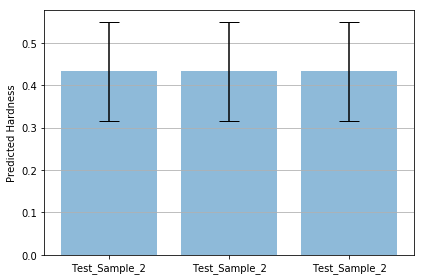


Test Sample No. : 3
Predictions for this sample by all models: [ 0.47979763  0.47526592  0.52977979  0.44702026  0.46669304  0.4767535
  0.46586543  0.46590954  0.41933876  0.44836658  0.46981332  0.47746977
  0.46042252  0.25808007  0.35793406  0.48707202  0.0363047   0.295688
  0.45550266  0.47845033  0.47764406  0.475133    0.47809887  0.47896492
  0.45803493  0.48261246  0.46773812  0.45950788  0.44921431  0.47334826
  0.47923824  0.4791151   0.4275254   0.47937235  0.47495013  0.4806909
  0.47807059 -0.10139392  0.42779765  0.4781411   0.47718641  0.234137
  0.43174252  0.44981614  0.47843438  0.45712781  0.45715651  0.47609857
  0.473077    0.45610234  0.48329484  0.28979939  0.24445942  0.47879377
  0.17831142  0.47487259  0.47906357  0.09984913  0.48265135  0.48017839
  0.23356786  0.46769965  0.4718172   0.46540898  0.47162518  0.34171081
  0.41505682  0.18451759  0.44969264  0.21495435  0.29717869  0.46766695
  0.47712511  0.4691245   0.10859536  0.27749592  0.481976    0.47

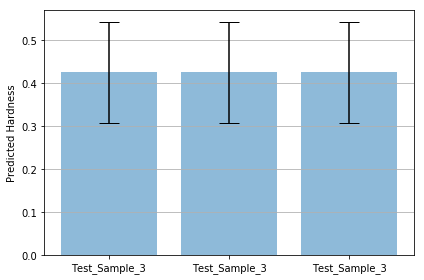


Test Sample No. : 4
Predictions for this sample by all models: [ 0.47762924  0.47432554  0.530137    0.4470658   0.46685636  0.48187825
  0.46586543  0.46580231  0.41720483  0.44776973  0.48459321  0.47743362
  0.54531252  0.26051509  0.35939515  0.48704386  0.03759722  0.29337645
  0.45550266  0.47743291  0.4784278   0.47515956  0.4781284   0.48092949
  0.50180084  0.48160559  0.46773812  0.46023619  0.44927359  0.48061544
  0.47706938  0.47874877  0.42854357  0.48088047  0.54133266  0.47900534
  0.47878835 -0.10304429  0.4262563   0.48106402  0.48203641  0.2333129
  0.43159258  0.55457193  0.47964591  0.45712781  0.45715651  0.47637734
  0.47153813  0.45610234  0.48341256  0.29314244  0.24814153  0.47883412
  0.17720589  0.47733653  0.47936967  0.10067995  0.48126438  0.48218501
  0.23502034  0.46518135  0.4716931   0.46535695  0.47173497  0.34546435
  0.41861859  0.34368873  0.44985467  0.21473292  0.29514176  0.46733946
  0.47802332  0.47206914  0.11159472  0.27753717  0.48202187 

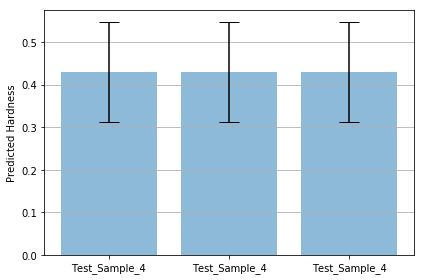


Test Sample No. : 5
Predictions for this sample by all models: [ 0.47756302  0.47524941  0.52728522  0.44634727  0.46683669  0.47999531
  0.46586543  0.46588436  0.41773513  0.44777957  0.48693818  0.47748312
  0.54254246  0.25977626  0.35947871  0.48744905  0.03493606  0.29310548
  0.45550266  0.4776693   0.47899732  0.4751499   0.47851151  0.47854498
  0.51509786  0.49249375  0.46773812  0.46053314  0.44906768  0.48211998
  0.47902811  0.47876853  0.42824802  0.48043668  0.58595967  0.47841448
  0.47957456 -0.10321026  0.42537993  0.47995058  0.48081404  0.23293889
  0.43130824  0.54968166  0.47999913  0.45712781  0.45715651  0.47639263
  0.47141939  0.45610234  0.48343453  0.294305    0.24621567  0.47881198
  0.17846052  0.47716957  0.48354048  0.10068455  0.48097643  0.48132181
  0.23348968  0.4655174   0.47124857  0.46568239  0.47214943  0.34485725
  0.41772225  0.30246353  0.44945371  0.21465875  0.29718319  0.46730453
  0.48003244  0.4718703   0.11042878  0.27780196  0.48207408

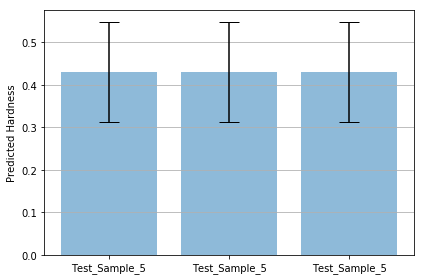


Test Sample No. : 6
Predictions for this sample by all models: [ 0.47665125  0.47465217  0.52876967  0.44626224  0.46690804  0.48256716
  0.46586543  0.46591151  0.41807753  0.44766551  0.48601007  0.47744018
  0.54366243  0.25871646  0.35855553  0.48724145  0.03562076  0.29242435
  0.45550266  0.47797412  0.47919324  0.47516039  0.47883451  0.47938979
  0.51064223  0.49073952  0.46773812  0.45964846  0.44924718  0.48173618
  0.47858647  0.47866169  0.42858621  0.48029348  0.58587265  0.47768173
  0.47925556 -0.10318922  0.42637017  0.48074144  0.4826923   0.23352918
  0.43133503  0.55567479  0.47963166  0.45712781  0.45715651  0.47651112
  0.47158134  0.45610234  0.48344934  0.29685509  0.24741171  0.47882608
  0.17776354  0.47723287  0.48332196  0.0999632   0.48095873  0.48140231
  0.23391744  0.46410871  0.47050101  0.46544591  0.47185725  0.34334975
  0.41886497  0.51167434  0.44845992  0.21459341  0.29534656  0.46736416
  0.47937065  0.47171515  0.11026151  0.27748001  0.48205012

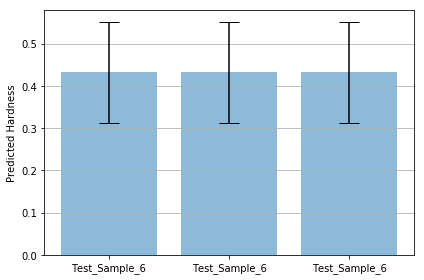


Test Sample No. : 7
Predictions for this sample by all models: [ 0.4802517   0.47510695  0.52646202  0.44641119  0.46666592  0.47595251
  0.46586543  0.46581569  0.41625288  0.44804236  0.47457844  0.47748771
  0.26780224  0.25748727  0.35937834  0.4825356   0.04020512  0.29350725
  0.45550266  0.477559    0.47430569  0.47515595  0.47096568  0.48002422
  0.42623353  0.461539    0.46773812  0.45996365  0.447101    0.47771579
  0.47502995  0.47858098  0.42810169  0.47987771  0.15074165  0.4777599
  0.479231   -0.10384808  0.42727894  0.48117331  0.47655451  0.23406512
  0.43108284  0.2853806   0.4797774   0.45712781  0.45715651  0.4760001
  0.47184336  0.45610234  0.48337841  0.28318229  0.24513486  0.47856739
  0.17688729  0.47409129  0.48064139  0.10091163  0.47929054  0.47674996
  0.23259369  0.4611004   0.47052491  0.46593803  0.47170168  0.34349546
  0.41854635  0.31050155  0.44887325  0.21505746  0.29420251  0.46716785
  0.47039491  0.4734537   0.1107379   0.27839911  0.48198488  

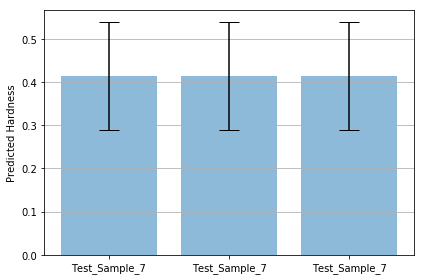


Test Sample No. : 8
Predictions for this sample by all models: [ 0.47526982  0.47570205  0.52758473  0.44658029  0.46684551  0.47899282
  0.46586543  0.4658103   0.41855413  0.44728744  0.48759663  0.47749415
  0.54287755  0.25947198  0.36026567  0.4879508   0.03501705  0.29326916
  0.45550266  0.47819561  0.47872189  0.47515339  0.47870719  0.47854537
  0.50865966  0.4959271   0.46773812  0.46087897  0.44902617  0.48178566
  0.47931853  0.47886756  0.42815119  0.48050827  0.55572546  0.47849095
  0.47936332 -0.10252059  0.42612234  0.48054063  0.47887295  0.23305151
  0.43165955  0.54109311  0.48008901  0.45712781  0.45715651  0.47636282
  0.47132319  0.45610234  0.48342454  0.29160798  0.24513645  0.47880819
  0.17838043  0.47672147  0.48250616  0.10131353  0.48161042  0.48159626
  0.23484388  0.4666453   0.4710165   0.46567333  0.47198236  0.34368795
  0.41914102  0.20808861  0.44831485  0.21524413  0.29698688  0.46748069
  0.47950161  0.47173363  0.11040507  0.27761123  0.48208052

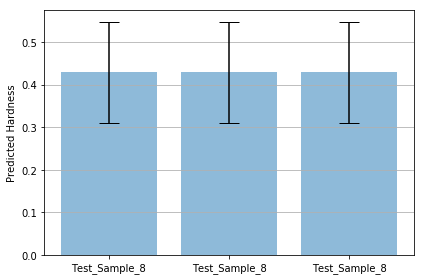


Test Sample No. : 9
Predictions for this sample by all models: [ 0.4784151   0.47458649  0.52838051  0.44648322  0.46685526  0.4826327
  0.46586543  0.46593753  0.41757315  0.44796583  0.48591742  0.47744736
  0.54180813  0.25984329  0.35954177  0.48679867  0.03648376  0.29307571
  0.45550266  0.47766846  0.47932178  0.47515881  0.47766107  0.4820255
  0.50408506  0.48504794  0.46773812  0.45997334  0.44926566  0.48177585
  0.47867742  0.47876161  0.42845127  0.48172581  0.57079041  0.47860569
  0.47897917 -0.10354415  0.42529064  0.48025641  0.48251128  0.23264146
  0.43127739  0.554124    0.47948751  0.45712781  0.45715651  0.47648942
  0.47159618  0.45610234  0.48343599  0.29702401  0.2474214   0.47882733
  0.17738973  0.47775251  0.48201162  0.09901453  0.48100016  0.4811987
  0.23382068  0.46503484  0.4713082   0.46543753  0.4718138   0.3448678
  0.41657108  0.20066693  0.44954973  0.21426016  0.29755118  0.46740553
  0.47830135  0.47228953  0.11123415  0.27811822  0.48205081  0.

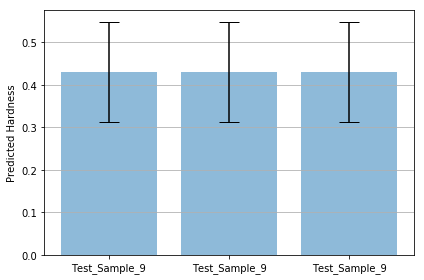


Test Sample No. : 10
Predictions for this sample by all models: [ 0.47743905  0.47546375  0.52769768  0.44665655  0.46679899  0.47983941
  0.46586543  0.46583876  0.41746861  0.44786191  0.48688737  0.47748455
  0.54326856  0.26067159  0.36032212  0.48739806  0.03617396  0.29387191
  0.45550266  0.47733489  0.47924507  0.47515121  0.47823346  0.47942251
  0.51410502  0.49062878  0.46773812  0.46058798  0.44885749  0.48175833
  0.47882879  0.47882557  0.42787224  0.48075128  0.5766201   0.47969294
  0.47943744 -0.10319319  0.42537808  0.48031533  0.48045531  0.23236328
  0.43121961  0.54874742  0.47976846  0.45712781  0.45715651  0.47636083
  0.47150272  0.45610234  0.48342806  0.29391789  0.2459991   0.47880438
  0.17820874  0.47714311  0.48164278  0.10161629  0.48138055  0.48148793
  0.23391508  0.46631792  0.47164953  0.46565324  0.47172856  0.34532389
  0.41733778  0.18611917  0.44965518  0.21491838  0.29745615  0.46736571
  0.47908813  0.47219211  0.11094593  0.27812469  0.4820877

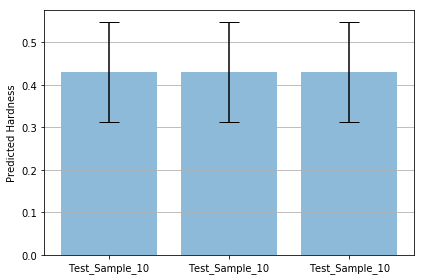


Test Sample No. : 11
Predictions for this sample by all models: [ 0.47629943  0.4755578   0.52593392  0.44553953  0.46660155  0.47324395
  0.46586543  0.46581548  0.41528839  0.44782698  0.46065396  0.47749442
  0.28034177  0.25748527  0.35702538  0.48373395  0.03872605  0.29390609
  0.45550266  0.47592911  0.47235188  0.47513902  0.47379494  0.47881567
  0.4027794   0.46099377  0.46773812  0.46031615  0.44903108  0.47739029
  0.47569662  0.4787977   0.42739651  0.4803988   0.1795857   0.47880077
  0.47857124 -0.1028843   0.42478788  0.48415697  0.47635627  0.23117977
  0.43092299  0.26644188  0.47847474  0.45712781  0.45715651  0.47622082
  0.47189927  0.45610234  0.48345065  0.28769946  0.24313134  0.47857964
  0.1778027   0.47456002  0.48247159  0.10234013  0.47904715  0.47629604
  0.23370427  0.46165243  0.46847588  0.46543565  0.47247958  0.34391654
  0.41914475  0.04725885  0.44863394  0.2153374   0.29616594  0.46734583
  0.47107625  0.4685064   0.11098908  0.27841407  0.4819827

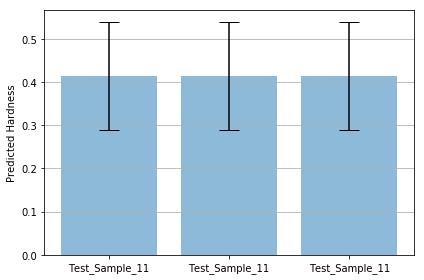

In [18]:
no_of_test_samples = len(testing_data)



for test_sample_num in range(no_of_test_samples):
    print("\nTest Sample No. : {}".format(test_sample_num))
    
    np_array_test_predictions_by_all_estimators = np.array(test_predictions_by_all_estimators).squeeze()
    # squeeze() to remove the Channel dimension of torch

    predictions_for_this_test_sample = np_array_test_predictions_by_all_estimators[:,test_sample_num]
    
    print("Predictions for this sample by all models: {}".format(predictions_for_this_test_sample))
    
    mean_prediction_for_this_test_sample = np.mean(predictions_for_this_test_sample)
    print("mean_prediction_for_this_test_sample: {}".format(mean_prediction_for_this_test_sample))

    std_of_all_predictions_for_this_test_sample = np.std(predictions_for_this_test_sample)
    print("std_of_all_predictions_for_this_test_sample: {}".format(std_of_all_predictions_for_this_test_sample))

    # Define individual_agents_name_list, positions, bar heights and list_of_standard_deviations_of_costs_of_all_agents bar heights
    test_samples_name_list = ["Test_Sample_" + str(test_sample_num),"Test_Sample_" + str(test_sample_num), "Test_Sample_" + str(test_sample_num),]
    x_pos = np.arange(len(test_samples_name_list))
    list_of_means = [mean_prediction_for_this_test_sample, mean_prediction_for_this_test_sample, mean_prediction_for_this_test_sample,]
    list_of_standard_deviations = [std_of_all_predictions_for_this_test_sample, std_of_all_predictions_for_this_test_sample, std_of_all_predictions_for_this_test_sample,]
    
    import matplotlib.pyplot as plt2
    
    # Build the plot
    fig, ax = plt2.subplots()
    ax.bar(x_pos, list_of_means,
           yerr=list_of_standard_deviations,
           align='center',
           alpha=0.5,
           ecolor='black',
           capsize=10
          )
    ax.set_ylabel('Predicted Hardness')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(test_samples_name_list)
    ax.set_title('')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt2.tight_layout()
    plt2.savefig('../plots/bar_plot_with_error_bars_for_test_sample_' + str(test_sample_num) + '.png')
    plt2.show()
    

## Target Predictions for all test samples by the "best hyperparam" model

In [19]:
best_hyperparam_predictions = test_predictions_by_all_estimators[estimator_index_for_least_avg_mse]

#The maximum and minimum targets of the training data were [983.91] and [116.] from feature engineering file

max_hardness = 983.91
min_hardness = 116.

def convert_to_original_scale(scaled_hardness):
    original_scale_hardness = (scaled_hardness * (max_hardness - min_hardness)) + min_hardness
    return original_scale_hardness

for test_sample in range(len(best_hyperparam_predictions)):
    print("True Hardness: {}".format(convert_to_original_scale(Y_testing[test_sample])))
    print("Predicted Hardness: {}".format(convert_to_original_scale(best_hyperparam_predictions[test_sample])))
    print("")

True Hardness: [373.65640529]
Predicted Hardness: [554.52780305]

True Hardness: [517.04779606]
Predicted Hardness: [648.60721843]

True Hardness: [891.0696757]
Predicted Hardness: [674.3125845]

True Hardness: [373.65640529]
Predicted Hardness: [547.25601416]

True Hardness: [540.71297677]
Predicted Hardness: [668.16181651]

True Hardness: [983.91]
Predicted Hardness: [667.92255848]

True Hardness: [972.56751694]
Predicted Hardness: [671.32788577]

True Hardness: [194.41716683]
Predicted Hardness: [277.78580544]

True Hardness: [602.74655695]
Predicted Hardness: [653.32016202]

True Hardness: [871.18532268]
Predicted Hardness: [667.31517932]

True Hardness: [654.13780736]
Predicted Hardness: [664.02795496]

True Hardness: [116.]
Predicted Hardness: [291.60236211]



### MSE for the test samples by the "best hyperparam" model

In [20]:
# get Root Mean Squared Error
MSE(Y_testing,best_hyperparam_predictions)**(1/2)

0.214522689298415

## R2 plot for the best model

True test targets: 
[[0.29686996]
 [0.46208454]
 [0.89303001]
 [0.29686996]
 [0.4893514 ]
 [1.        ]
 [0.98693127]
 [0.09035173]
 [0.56082607]
 [0.87011939]
 [0.62003872]
 [0.        ]]

Best hyperparam-trained model predictions of test targets: 
[[0.50526875]
 [0.61366642]
 [0.64328396]
 [0.49689025]
 [0.63619709]
 [0.63592142]
 [0.63984501]
 [0.1864085 ]
 [0.61909664]
 [0.6352216 ]
 [0.63143408]
 [0.20232785]]
Best-hyperparam R2 score: 0.5657868908132004


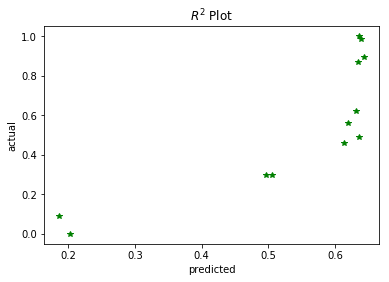

In [22]:
# R^2 plot
print("True test targets: \n{}".format(Y_testing))
print("\nBest hyperparam-trained model predictions of test targets: \n{}".format(best_hyperparam_predictions))

print("Best-hyperparam R2 score: {}".format(r2_score(Y_testing,best_hyperparam_predictions)))

import matplotlib.pyplot as plt3
plt3.plot(best_hyperparam_predictions,Y_testing,'g*')
plt3.xlabel('predicted')
plt3.ylabel('actual')
plt3.title('$R^{2}$ Plot');

# IGNORE ANYTHING BELOW THIS

In [ ]:
common_param_grid = {
    
    "lr" : lr,
    "max_epochs" : max_epochs,
    
    
    
    #list all the formal arguments of the torch module that u pass to skorch regressor here beginning with module__
    "module__num_units" : no_of_nodes_per_layer,
    "module__dropout" : dropout_probability_per_node,
    #not passing the activation here though
    
    
    
    "optimizer" : optimizers,
    "optimizer__weight_decay": weight_decay_for_regularization,
    "optimizer__momentum" : momentum_vals,
    "optimizer__dampening" : momentum_dampening,
    "optimizer__nesterov" : nesterov, 
    
    
    
    "iterator_train__batch_size": minibatch_size,
    #"callbacks__scheduler__epoch": [10, 50, 100], #learning rate scheduler    
}

#### Create a Randomized Search Instance and pass the estimator, thehyperparameters' grid, the no of random samples to take from the grid, and the value of k for k-Fold cross-validation.

In [ ]:
sgd_randomized_search = RandomizedSearchCV(estimator = skorch_regressor,
                                          scoring = "neg_mean_squared_error", #negative since the scorer tries to maximize this
                                          param_distributions = common_param_grid,
                                          n_iter = 1, #350,  #no of random samples to take from the grid                                                    
                                          cv = 2, #20,
                                          return_train_score = True # produce metrics on the train set as well
                                          )

#skorch_regressor.get_params().keys()

### Train the models.

In [ ]:
assert len(X_training) == len(Y_training)
randomized_search_result = sgd_randomized_search.fit(X_training.values, Y_training.values)

#dataframe.values gives the underlying numpy array of the data frame, doing this conversion since pandas data frame 
#is not supported.

### Save and view the best parameters and hyperparameters obtained from randomized search.

In [ ]:
# Import the parameter combinations and the corresponding results into a pandas dataframe
pd.DataFrame(randomized_search_result.cv_results_)

#Each row of this dataframe gives one combination of the hyperparameters used and the corresponding performance of the
#estimator used.

### Interpretation of cv_results_
Column "mean_test_score" is the average of columns split_0_test_score, split_1_test_score, split_2_test_score...split_k_test_score for "this" hyperparameter configuration.<br><br>
"randomized_search_result.best_score_" will return the max value of the column mean_test_score.<br><br>
Column "rank_test_score" ranks all hyperparameter combinations by the values of mean_test_score.<br><br>
Column "std_test_score" is the standard deviation of split_0_test_score, split_1_test_score,...., split_k_test_score. It shows how consistently "this" set of hyperparameters is performing on the hold-out data of each k-fold validation.

### Save the results

In [ ]:
#saving the best estimator i.e., the best neural network parameters
# randomized_search_result.best_estimator_ gives the neural net with best parameters
joblib.dump(randomized_search_result.best_estimator_, 'best_params_of_NN_by_randomized_search.pkl', compress = 1)

#saving the hyperparameters that were used to get this best estimator
# randomized_search_result.best_params_ gives the best hyperparameters that were used to get this best estimator
joblib.dump(randomized_search_result.best_params_, 'best_hyperparams_for_NN_by_randomized_search.pkl', compress = 1)

#saving all 350 models' hyperparameter configurations and the neural network parameters



# Displaying the best hyperparameters configuration
randomized_search_result.best_params_

In [ ]:
def report(results, num_of_top_results_to_report = 5):
    #this utility method was found online.
    
    for idx1 in range(0, num_of_top_results_to_report):
        candidates = np.flatnonzero(results['rank_test_score'] == idx1)
        for candidate in candidates:
            print("Model with rank: {0}".format(idx1))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [ ]:
report(sgd_randomized_search.cv_results_,num_of_top_results_to_report = 3)

### Visualize training and validation loss

In [ ]:
# get training and validation loss
epochs = [i for i in range(len(sgd_randomized_search.best_estimator_.history))]
training_loss = sgd_randomized_search.best_estimator_.history[:,'train_loss']
validation_loss = sgd_randomized_search.best_estimator_.history[:,'valid_loss']

In [ ]:
plt.plot(epochs,training_loss,'g-');
plt.plot(epochs,validation_loss,'r-');
plt.title('Training and Validation Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Mean Squared Error');
plt.legend(['Train','Validation']);

## Test on Test Data

In [ ]:
# Predict on test data
testing_data = pd.read_csv("normalized_testing_features_and_targets.csv", sep = ",")
testing_data.head()

In [ ]:
# Separate features and targets
X_testing = testing_data.iloc[:,0:num_features].values #notice retaining only the underlying numpy arrays
Y_testing = pd.DataFrame(testing_data["Hardness"]).values

Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [ ]:
Y_predictions_on_test_data = sgd_randomized_search.best_estimator_.predict(X_testing.astype(np.float32))

In [ ]:
Y_testing

In [ ]:
Y_predictions_on_test_data

In [ ]:
# get Root Mean Squared Error
MSE(Y_testing,Y_predictions_on_test_data)**(1/2)

In [ ]:
# Kernel Density Estimation Plot

# sns.kdeplot(Y_predictions_on_test_data.squeeze(), label='predictions of the model', shade=True)
# sns.kdeplot(Y_testing.squeeze(), label='true values', shade=True)
# plt.xlabel('Hardness');

In [ ]:
# Dist Plot

# sns.distplot(Y_testing.squeeze()-Y_predictions_on_test_data.squeeze(),label='error', bins = 10);
# plt.xlabel('Error');

In [ ]:
# R^2 plot

print(r2_score(Y_testing,Y_predictions_on_test_data))

plt.plot(Y_predictions_on_test_data,Y_testing,'g*')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('$R^{2}$ Plot');

#### View the actual values vs predicted values in real scale

In [ ]:
#The maximum and minimum targets of the training data were [983.91] and [116.] from feature engineering file

max_hardness = 983.91
min_hardness = 116.

def convert_to_original_scale(scaled_hardness):
    original_scale_hardness = (scaled_hardness * (max_hardness - min_hardness)) + min_hardness
    return original_scale_hardness

for test_sample in range(len(Y_predictions_on_test_data)):
    print("True Hardness: {}".format(convert_to_original_scale(Y_testing[test_sample])))
    print("Predicted Hardness: {}".format(convert_to_original_scale(Y_predictions_on_test_data[test_sample])))
    print("")